In [5]:
%matplotlib inline

In [6]:
import numpy as np
from scipy.stats import norm, uniform
import matplotlib.pyplot as plt
from dsge.StateSpaceModel import StateSpaceModel
import pandas as p

TT = lambda x: np.array([[x[0]]])
RR = lambda x: np.array([[1.0]])
QQ = lambda x: np.array([[x[1]**2]])
DD = lambda x: np.array([0])
ZZ = lambda x: np.array([[1]])
HH = lambda x: np.array([[0.1**2*x[1]**2]])

simpleAR1 = StateSpaceModel(np.zeros((100,)),TT, RR, QQ, DD, ZZ, HH)



In [7]:
yy = simpleAR1.simulate([0.8, 1], nsim=50)
simpleAR1.yy = yy

In [8]:
print "Exact likelihood: ", simpleAR1.log_lik([0.8,1])

Exact likelihood:  -72.097188373


In [17]:
import sys, types
sys.path.append('/home/eherbst/Dropbox/DSGE Book (1)/dsge-book/code/helper')
from dsge.StateSpaceModel import dlyap
import scipy as sp
resample = resampling.resampling.multinomial_resampling
def log_lik_pf(self, para, *args, **kwargs):

    t0 = kwargs.pop('t0', self.t0)
    npart = kwargs.pop('npart', 1000)
    yy = kwargs.pop('y', self.yy)
    P0 = kwargs.pop('P0', 'unconditional')
    filt = kwargs.pop('filt', 'bootstrap')
    rcond = kwargs.pop('rcond',1e-7)
  
  
    data = np.asarray(yy)
    data = np.atleast_2d(data)
    seed = kwargs.pop('seed', None)
    scale = kwargs.pop('scale', 10)
    init_s_w = kwargs.pop('init_s_w', None)
  
    TT, RR, QQ, DD, ZZ, HH = self.system_matrices(para, *args, **kwargs)
  
    if P0=='unconditional':
        P0, info = dlyap.dlyap(TT, RR.dot(QQ).dot(RR.T))
  
    if seed is not None:
        np.random.seed(seed)
  
    from scipy.stats import multivariate_normal
  
    RQR = RR.dot(QQ).dot(RR.T)
    P0 = TT.dot(P0).dot(TT.T) + RQR
    nobs = data.shape[0]
    ny = data.shape[1]
    neps = QQ.shape[0]
    ns = TT.shape[0]
  
    St = np.zeros((nobs+1, ns, npart))
  
    U,s,V = sp.linalg.svd(P0)
    L = U.dot(np.diag(np.sqrt(s)))
    St[0,:,:] = L.dot(np.random.normal(size=(ns,npart)))
  
  
  
    RRcQQ = RR.dot(np.linalg.cholesky(QQ))
    iRQR = np.linalg.pinv(RQR,rcond=1e-7)
    U,S,V = np.linalg.svd(RQR,full_matrices=0)
    detRQR = np.sum(np.log(S[S>1e-7]))
  
    ps = multivariate_normal(cov=RQR, allow_singular=True)

    # container variables
    resamp = np.zeros((nobs))
    wtsim = np.ones((nobs+1,npart))
    incwt = np.zeros((nobs,npart))
    incwtaux = np.zeros((nobs,npart))
  
    #------------------------------------------------------------
    # p(yt|st) [in terms of dev from mean]
    #------------------------------------------------------------
    py = multivariate_normal(cov=HH)
    ESS = np.zeros((nobs))
    loglh = np.zeros((nobs))
    loglhalt = np.zeros((nobs))
  
    #------------------------------------------------------------
    # Helper Functions
    #------------------------------------------------------------
    demeaned_data = data - np.tile(np.squeeze(DD), (nobs, 1))
    fcst_error = lambda i: np.tile(demeaned_data[i].T, (1, npart))-ZZ.dot(TT.dot(St[i, ...]))
    if filt=='cond-opt':
        Pt = RQR
        Ft = np.dot(np.dot(ZZ, Pt), ZZ.T) + HH
        iFt = np.linalg.inv(Ft)
        PtZZpiFt = Pt.dot(ZZ.T).dot(iFt)
        Pt = Pt - Pt.dot(ZZ.T).dot(iFt).dot(ZZ).dot(Pt)
        pys = multivariate_normal(cov=Pt, allow_singular=True)
  
  
    #------------------------------------------------------------
    # AUXILIARY PARTICLE FILTER
    #------------------------------------------------------------
    if filt == 'auxsimp':
        ptilde = multivariate_normal(cov=scale*HH)
        fcst_error = lambda i: np.tile(demeaned_data[i].T, (1, npart))-ZZ.dot(TT.dot(St[i, ...]))
  
        phatold = ptilde.logpdf(fcst_error(0).T)
  
        wtsim[0, :] = np.exp(phatold)
        wtsim[0, :] = wtsim[0, :]/(wtsim[0, :].mean())
  
    if init_s_w is not None:
        St[0, :, :] = init_s_w[0]
        wtsim[0, :] = init_s_w[1]
  
    for t in range(nobs):
        if filt=='bootstrap':
            St[t+1,...] = TT.dot(St[t,...]) + ps.rvs(size=npart).T
        elif filt=='cond-opt':
            nut = fcst_error(t)
            Stbar = TT.dot(St[t,...]) + PtZZpiFt.dot(nut)
            St[t+1, ...] = Stbar + pys.rvs(size=npart).T
            lng = pys.logpdf( (St[t+1, ...]-Stbar).T )
  
        elif filt=='auxsimp':
            #------------------------------------------------------------
            # Simulate
            #------------------------------------------------------------
            St[t+1,...] = TT.dot(St[t,...]) + ps.rvs(size=npart).T
  
            phatold = ptilde.logpdf(fcst_error(t).T)
            if t < nobs-1:
                phat = ptilde.logpdf(fcst_error(t+1).T)
  
  
  
        nut = (np.tile(demeaned_data[t].T, (1, npart))
                       - ZZ.dot(St[t+1,...]))
  
        incwt[t,:] = py.logpdf(nut.T)
  
        if filt=='cond-opt':
            eta = St[t+1,...] - TT.dot(St[t,...])
            lnps = (-0.5*neps*np.log(2.0*np.pi) - 0.5*detRQR
                    -0.5*np.einsum('ji,ji->i', np.dot(iRQR,eta),eta))
            incwt[t,:] = incwt[t,:] + lnps - lng
  
        elif filt=='auxsimp':
            incwtaux = incwt[t,:] - phatold
            incwt[t, :] = incwt[t,:] + phat - phatold
  
        # Equation 7.7
        wtsim[t+1,:] = np.exp(incwt[t,:]) * wtsim[t,:]
        wtsim[t+1,:] = wtsim[t+1,:]/np.mean(wtsim[t+1,:])
  
        ESS[t] = npart / np.mean(wtsim[t+1,:]**2)
        loglh[t] = np.log(np.mean(np.exp(incwt[t,:])*wtsim[t,:]))
  
        if filt=='auxsimp':
            if t==0:
                loglh[t] = (np.log(np.mean(np.exp(phatold))) +
                            np.log(np.mean(np.exp(incwtaux)*wtsim[t,:])))
                loglhalt[t] = np.log(np.mean(np.exp(incwt[t, :])*wtsim[t, :])) + np.log(np.mean(np.exp(phatold)))
            elif t==nobs-1:
                loglh[t] = (-np.log(np.mean((1/np.exp(phatold))*wtsim[t, :])) +
                            np.log(np.mean(np.exp(incwtaux)*wtsim[t,:])) )
  
                loglhalt[t] = np.log(np.mean(np.exp(incwtaux)*wtsim[t, :]))
            else:
                loglh[t] = (-np.log(np.mean((1/np.exp(phatold))*wtsim[t, :])) +
                            np.log(np.mean(np.exp(incwtaux)*wtsim[t,:])) )
                loglhalt[t] = np.log(np.mean(np.exp(incwt[t, :])*wtsim[t, :]))
  
        if ESS[t] < npart/2:
            ind = resample(wtsim[t+1,:]/sum(wtsim[t+1,:]), np.random.rand(npart,))
            if ns == 1:
                St[t+1,...] = np.squeeze(St[t+1,:,ind-1])
            else:
                St[t+1,...] = St[t+1,...][:,ind-1]
  
            wtsim[t+1,:] = 1
            wtsim[t, :] = wtsim[t, ind-1]
            incwt[t, :] = incwt[t, ind-1]
            if t > 0:
                wtsim[t-1, :] = wtsim[t-1, ind-1]
                incwt[t-1, :] = incwt[t-1, ind-1]
  
    filtered_states = TT.dot(St[:-1,...,...]) * wtsim[:-1,:]
    filtered_states = filtered_states.mean(2).T
  
    if isinstance(yy,p.DataFrame):
        loglh = p.DataFrame(loglh,columns=['Log Lik.'])
        loglh.index = yy.index
  
        ESS = p.DataFrame(ESS,columns=['ESS'])
        ESS.index = yy.index
  
        filtered_states = p.DataFrame(filtered_states, columns=self.state_names)
        filtered_states.index = yy.index
  
    results = {}
    results['log_lik'] = loglh
    results['log_likalt'] = loglhalt
    results['ESS'] = ESS
    results['filtered_states'] = filtered_states
    results['St'] = St[t+1, ...]
    results['wt'] = wtsim[t+1, ...]
    results['incwt'] = incwt
    return results

simpleAR1.log_lik_pf = types.MethodType(log_lik_pf, simpleAR1)

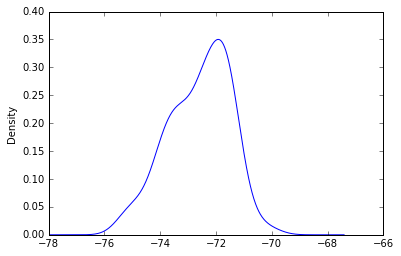

/home/eherbst/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:170: DeprecationWarning: an index can only have a single Ellipsis (`...`); replace all but one with slices (`:`).


count    100.000000
mean     -72.608143
std        1.105821
min      -75.329115
25%      -73.411915
50%      -72.416113
75%      -71.741439
max      -70.048535
dtype: float64


In [28]:
nsim = 100
ll = np.zeros((nsim,))
for i in range(nsim):
    ll[i] = simpleAR1.log_lik_pf([0.8,1])['log_lik'].sum()
    
ll = p.Series(ll)
print ll.describe()
ll.plot(kind='kde')

In [678]:
def log_lik_temp_pf(self, para, *args, **kwargs):

    t0 = kwargs.pop('t0', self.t0)
    npart = kwargs.pop('npart', 1000)
    yy = kwargs.pop('y', self.yy)
    P0 = kwargs.pop('P0', 'unconditional')
    filt = kwargs.pop('filt', 'bootstrap')
    rcond = kwargs.pop('rcond',1e-7)
    phi = kwargs.pop('phi',np.linspace(9,1,10))
    NOSTAGE = kwargs.pop('NOSTAGE', False)
    data = np.asarray(yy)
    data = np.atleast_2d(data)
    seed = kwargs.pop('seed', None)
    scale = kwargs.pop('scale', 10)
    init_s_w = kwargs.pop('init_s_w', None)
  
    TT, RR, QQ, DD, ZZ, HH = self.system_matrices(para, *args, **kwargs)
  
    if P0=='unconditional':
        P0, info = dlyap.dlyap(TT, RR.dot(QQ).dot(RR.T))
  
    if seed is not None:
        np.random.seed(seed)
  
    from scipy.stats import multivariate_normal
  
    RQR = RR.dot(QQ).dot(RR.T)
    P0 = TT.dot(P0).dot(TT.T) + RQR
    nobs = data.shape[0]
    ny = data.shape[1]
    neps = QQ.shape[0]
    ns = TT.shape[0]
  
    St = np.zeros((nobs+1, ns, npart))
  
    U,s,V = sp.linalg.svd(P0)
    L = U.dot(np.diag(np.sqrt(s)))
    St[0,:,:] = L.dot(np.random.normal(size=(ns,npart)))
    
  
    RRcQQ = RR.dot(np.linalg.cholesky(QQ))
    iRQR = np.linalg.pinv(RQR,rcond=1e-7)
    U,S,V = np.linalg.svd(RQR,full_matrices=0)
    detRQR = np.sum(np.log(S[S>1e-7]))
  
    ps = multivariate_normal(cov=RQR, allow_singular=True)
    eps = multivariate_normal(cov=QQ)

    # container variables
    resamp = np.zeros((nobs))
    wtsim = np.ones((nobs+1,npart))
    incwt = np.zeros((nobs,npart))

  
    #------------------------------------------------------------
    # p(yt|st) [in terms of dev from mean]
    #------------------------------------------------------------
    py = multivariate_normal(cov=HH)
    ESS = np.zeros((nobs))
    loglh = np.zeros((nobs))
    loglhalt = np.zeros((nobs))
  
    #------------------------------------------------------------
    # Helper Functions
    #------------------------------------------------------------
    demeaned_data = data - np.tile(np.squeeze(DD), (nobs, 1))
  
    if init_s_w is not None:
        St[0, :, :] = init_s_w[0]
        wtsim[0, :] = init_s_w[1]
  
	


    nstage = phi.size

    wtold = np.ones((npart,))
    Stold = St[0,...]
    
    loglh = 0


    #phi = np.ones_like(phi)


    for t in range(nobs):
	Stold_t = Stold.copy()

	pyst_n_old = 0
	epsi = np.atleast_2d(eps.rvs(size=npart).T)
	wtold_t = wtold.copy()
	converged = False
	phiold = 100
	while converged==False: #for j in range(nstage):

	     
	    St1 = TT.dot(Stold_t) + RR.dot(epsi)
  	    nut = np.tile(demeaned_data[t].T, (1, npart)) - ZZ.dot(St1)
	    #print 'fdsf', demeaned_data[t].T, St1.mean(), St1.std()
	    # correction
	    def ess(phi):
		pyst_n = multivariate_normal(cov=HH*phi).logpdf(nut.squeeze())
		wjt = pyst_n - pyst_n_old
		wt = np.exp(wjt) * wtold
		Zt = np.mean(np.exp(wjt)*wtold)
		wt = wt / Zt
		ESSj = npart / np.mean(wt**2)

		return ESSj - npart / 3.0

	    #print t, ess(0.01), ess(100), npart
	    if ess(1.0) > 0 or NOSTAGE == True:
		print "At time ", t, "no need to search, ESS(1.0) = ", ess(1.0) + npart / 3.0
		phihat = 1.0
		converged = True
	    else:

		lb = 1.0
		#if np.isnan(ess(lb)): lb = 5
		if ess(phiold) < 0: phiold = phiold*100
		
		phihat = brentq(ess, lb, phiold)
		print "At time ", t, "searching in [", lb, phiold, "], FOUND: ", phihat

		if phihat < 1.0:
		    phihat = 1.0
		    converged = True
		#print t, phihat, ess(phihat)+npart/2

	    phiold = phihat
	    pyst_n = multivariate_normal(cov=HH*phihat).logpdf(nut.squeeze())
	    wjt = pyst_n - pyst_n_old
	    wt = np.exp(wjt) * wtold
	    Zt = np.mean(np.exp(wjt)*wtold)
	    wt = wt / Zt
	    ESSj = npart / np.mean(wt**2)


	    loglh += np.log(Zt) #np.mean(np.exp(pyst_n - pyst_n_old) * wtold))
	    # selection
	    ESSj = npart / np.mean(wt**2)
	    # print t,j,ESSj
	    if ESSj < npart/2.0:
		ind = resample(wt/sum(wt), np.random.rand(npart,))

		# resample
		St1 = St1[:,ind-1]
		epsi = epsi[:,ind-1]
		Stold_t = Stold_t[:,ind-1]

		pyst_n = pyst_n[ind-1]
		wt = np.ones((npart,))

	    # mutation
	    c = 0.1
	    epsprop = epsi.copy()+multivariate_normal(cov=c*np.eye(neps), allow_singular=True).rvs(size=npart).T
	    epsprop = np.atleast_2d(epsprop)
	    Stprop = TT.dot(Stold_t) + RR.dot(epsprop)
	    nutprop = np.tile(demeaned_data[t].T, (1, npart)) - ZZ.dot(Stprop)
	    pyst_n_prop = multivariate_normal(cov=HH*phihat).logpdf(nutprop.squeeze())
	    alp = np.exp( (pyst_n_prop+eps.logpdf(epsprop.squeeze()))
			  - (pyst_n+eps.logpdf(epsi.squeeze())))
	    acpt = 0
	    for k in range(npart):
		if uniform.rvs() < alp[k]:
		    epsi[:,k] = epsprop[:,k]
		    St1[:,k] = Stprop[:,k]
		    #wjt[k] = wjtprop[k]
		    pyst_n[k] = pyst_n_prop[k]
		    acpt +=1
		    #print j, acpt
	     
	    Stold = St1.copy()
	    wtold = wt.copy()
	    pyst_n_old = pyst_n.copy()

	    if t==3: z = (Stold * wtold).mean()

    return loglh,z

simpleAR1.log_lik_temp_pf = types.MethodType(log_lik_temp_pf, simpleAR1)

In [679]:
nsim = 100
no_outlier = simpleAR1.yy[:10,:].copy()
some_outlier = simpleAR1.yy[:10,:].copy()
some_outlier[3,:] = 3 
ll = np.zeros((nsim,))
fs = np.zeros((nsim,))
l2 = np.zeros((nsim,))
f2 = np.zeros((nsim,))
for i in range(nsim):
    ll[i], fs[i] = simpleAR1.log_lik_temp_pf([0.8,1], y=outlier,npart=500)
    l2[i] = simpleAR1.log_lik_pf([0.8,1], y=outlier,npart=500)['log_lik'].sum()

truth = simpleAR1.log_lik([0.8,1],y=outlier)
results = p.DataFrame([ll-truth, l2-truth]).T
print results.describe()

#ll.plot(kind='kde')

/home/eherbst/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:170: DeprecationWarning: an index can only have a single Ellipsis (`...`); replace all but one with slices (`:`).


 9 no need to search, ESS(1.0) =  488.776215173
                0           1
count  100.000000  100.000000
mean    -7.287785 -153.597495
std      3.294201   48.193330
min    -14.153054 -266.839666
25%     -9.442493 -185.411706
50%     -7.521790 -145.448008
75%     -4.919539 -118.764223
max      0.793537  -46.163339

 9 searching in [ 1.0 100 ], FOUND:  39.9845859408
At time  9 searching in [ 1.0 39.9845859408 ], FOUND:  1.33819131769
At time 

 8 searching in [ 1.0 100 ], FOUND:  7.75206238458
At time  8 no need to search, ESS(1.0) =  252.323316022
At time 

 7 searching in [ 1.0 100 ], FOUND:  9.77468472461
At time  7 no need to search, ESS(1.0) =  228.629242397
At time 

 6 searching in [ 1.0 18.1544261606 ], FOUND:  1.15757701253
At time  6 no need to search, ESS(1.0) =  494.805424456
At time 

 5 no need to search, ESS(1.0) =  442.081713224
At time  6 searching in [ 1.0 100 ], FOUND:  18.1544261606
At time 

 5 searching in [ 1.0 100 ], FOUND:  31.8158432698
At time  5 searching in [ 1.0 31.8158432698 ], FOUND:  2.05085326363
At time 

 4 searching in [ 1.0 5.86800276763 ], FOUND:  1.57934547924
At time  4 no need to search, ESS(1.0) =  435.303048776
At time 

 4 searching in [ 1.0 26.0653036963 ], FOUND:  13.993244877
At time  4 searching in [ 1.0 13.993244877 ], FOUND:  5.86800276763
At time 

 4 searching in [ 1.0 113.623934855 ], FOUND:  50.2461809096
At time  4 searching in [ 1.0 50.2461809096 ], FOUND:  26.0653036963
At time 

 4 searching in [ 1.0 10000 ], FOUND:  302.20240084
At time  4 searching in [ 1.0 302.20240084 ], FOUND:  113.623934855
At time 

 3 no need to search, ESS(1.0) =  478.339299389
At time 

 3 searching in [ 1.0 10.8205437061 ], FOUND:  5.38951108462
At time  3 searching in [ 1.0 5.38951108462 ], FOUND:  1.29116019068
At time 

 3 searching in [ 1.0 18.7081275082 ], FOUND:  10.8205437061
At time 

 3 searching in [ 1.0 50.5731027439 ], FOUND:  29.1273927679
At time  3 searching in [ 1.0 29.1273927679 ], FOUND:  18.7081275082
At time 

 3 searching in [ 1.0 124.440797066 ], FOUND:  50.5731027439
At time 

 3 searching in [ 1.0 456.495927924 ], FOUND:  124.440797066
At time 

 3 searching in [ 1.0 10000 ], FOUND:  456.495927924
At time 

 2 searching in [ 1.0 100 ], FOUND:  6.01658625697
At time  2 no need to search, ESS(1.0) =  294.78419826
At time 

 1 searching in [ 1.0 100 ], FOUND:  8.29610147726
At time  1 no need to search, ESS(1.0) =  236.934196092
At time 

 0 searching in [ 1.0 100 ], FOUND:  17.160715649
At time  0 no need to search, ESS(1.0) =  175.707478941
At time 

 9 searching in [ 1.0 36.2934255963 ], FOUND:  2.08203570608
At time  9 no need to search, ESS(1.0) =  436.165441937
At time 

 8 no need to search, ESS(1.0) =  261.535078845
At time  9 searching in [ 1.0 100 ], FOUND:  36.2934255963
At time 

 7 no need to search, ESS(1.0) =  210.865466231
At time  8 searching in [ 1.0 100 ], FOUND:  7.6576416133
At time 

 6 no need to search, ESS(1.0) =  491.354811475
At time  7 searching in [ 1.0 100 ], FOUND:  9.95627282786
At time 

 6 searching in [ 1.0 100 ], FOUND:  19.650387843
At time  6 searching in [ 1.0 19.650387843 ], FOUND:  1.24944060816
At time 

 5 searching in [ 1.0 26.6926620192 ], FOUND:  1.29637167785
At time  5 no need to search, ESS(1.0) =  486.672172047
At time 

 4 no need to search, ESS(1.0) =  469.365369242
At time  5 searching in [ 1.0 100 ], FOUND:  26.6926620192
At time 

 4 searching in [ 1.0 12.5445273275 ], FOUND:  5.32611471907
At time  4 searching in [ 1.0 5.32611471907 ], FOUND:  1.33859336845
At time 

 4 searching in [ 1.0 51.7491804204 ], FOUND:  24.5895413055
At time  4 searching in [ 1.0 24.5895413055 ], FOUND:  12.5445273275
At time 

 4 searching in [ 1.0 305.560550812 ], FOUND:  115.103370206
At time  4 searching in [ 1.0 115.103370206 ], FOUND:  51.7491804204
At time 

 3 no need to search, ESS(1.0) =  191.575535876
At time  4 searching in [ 1.0 10000 ], FOUND:  305.560550812
At time 

 3 searching in [ 1.0 17.9427360149 ], FOUND:  9.44518010448
At time  3 searching in [ 1.0 9.44518010448 ], FOUND:  4.08801971969
At time 

 3 searching in [ 1.0 59.0305894101 ], FOUND:  30.3055648305
At time  3 searching in [ 1.0 30.3055648305 ], FOUND:  17.9427360149
At time 

 3 searching in [ 1.0 518.527959693 ], FOUND:  148.739928069
At time  3 searching in [ 1.0 148.739928069 ], FOUND:  59.0305894101
At time 

 2 no need to search, ESS(1.0) =  259.725348949
At time  3 searching in [ 1.0 10000 ], FOUND:  518.527959693
At time 

 1 no need to search, ESS(1.0) =  249.264133111
At time  2 searching in [ 1.0 100 ], FOUND:  7.23245873231
At time 

 0 no need to search, ESS(1.0) =  498.428503841
At time  1 searching in [ 1.0 100 ], FOUND:  8.22481387018
At time 

 0 searching in [ 1.0 100 ], FOUND:  18.1175213907
At time  0 searching in [ 1.0 18.1175213907 ], FOUND:  1.08481007241
At time 

 9 no need to search, ESS(1.0) =  257.240657087
At time 

 8 no need to search, ESS(1.0) =  485.145298069
At time  9 searching in [ 1.0 100 ], FOUND:  8.3554243337
At time 

 8 searching in [ 1.0 100 ], FOUND:  27.2269208966
At time  8 searching in [ 1.0 27.2269208966 ], FOUND:  1.29576168326
At time 

 7 searching in [ 1.0 100 ], FOUND:  7.1329605112
At time  7 no need to search, ESS(1.0) =  265.500546957
At time 

 6 searching in [ 1.0 20.6646353762 ], FOUND:  1.22438390406
At time  6 no need to search, ESS(1.0) =  490.534930929
At time 

 5 no need to search, ESS(1.0) =  434.969370548
At time  6 searching in [ 1.0 100 ], FOUND:  20.6646353762
At time 

 5 searching in [ 1.0 100 ], FOUND:  31.0386946214
At time  5 searching in [ 1.0 31.0386946214 ], FOUND:  2.04913776278
At time 

 4 searching in [ 1.0 5.77005468318 ], FOUND:  1.60728044195
At time  4 no need to search, ESS(1.0) =  430.463763518
At time 

 4 searching in [ 1.0 27.3173332554 ], FOUND:  13.4123042977
At time  4 searching in [ 1.0 13.4123042977 ], FOUND:  5.77005468318
At time 

 4 searching in [ 1.0 122.650689647 ], FOUND:  54.8331823342
At time  4 searching in [ 1.0 54.8331823342 ], FOUND:  27.3173332554
At time 

 4 searching in [ 1.0 10000 ], FOUND:  336.541846156
At time  4 searching in [ 1.0 336.541846156 ], FOUND:  122.650689647
At time 

 3 searching in [ 1.0 5.88087123982 ], FOUND:  1.65377907421
At time  3 no need to search, ESS(1.0) =  428.753163444
At time 

 3 searching in [ 1.0 25.5834761967 ], FOUND:  13.8478435146
At time  3 searching in [ 1.0 13.8478435146 ], FOUND:  5.88087123982
At time 

 3 searching in [ 1.0 120.191744405 ], FOUND:  50.9923573577
At time  3 searching in [ 1.0 50.9923573577 ], FOUND:  25.5834761967
At time 

 3 searching in [ 1.0 10000 ], FOUND:  324.700853818
At time  3 searching in [ 1.0 324.700853818 ], FOUND:  120.191744405
At time 

 2 searching in [ 1.0 100 ], FOUND:  8.26932325053
At time  2 no need to search, ESS(1.0) =  226.088607819
At time 

 1 searching in [ 1.0 100 ], FOUND:  8.91626258868
At time  1 no need to search, ESS(1.0) =  216.670915626
At time 

 0 searching in [ 1.0 100 ], FOUND:  15.4240753831
At time  0 no need to search, ESS(1.0) =  197.650970957
At time 

 9 searching in [ 1.0 31.9008597684 ], FOUND:  1.91855179664
At time  9 no need to search, ESS(1.0) =  438.14028652
At time 

 8 no need to search, ESS(1.0) =  262.989225717
At time  9 searching in [ 1.0 100 ], FOUND:  31.9008597684
At time 

 7 no need to search, ESS(1.0) =  233.820598212
At time  8 searching in [ 1.0 100 ], FOUND:  7.23923970727
At time 

 6 no need to search, ESS(1.0) =  495.348990826
At time  7 searching in [ 1.0 100 ], FOUND:  9.19715586293
At time 

 6 searching in [ 1.0 100 ], FOUND:  14.7225297425
At time  6 searching in [ 1.0 14.7225297425 ], FOUND:  1.13656411836
At time 

 5 searching in [ 1.0 22.9088193198 ], FOUND:  1.03451493606
At time  5 no need to search, ESS(1.0) =  499.757268547
At time 

 4 no need to search, ESS(1.0) =  169.761446929
At time  5 searching in [ 1.0 100 ], FOUND:  22.9088193198
At time 

 4 searching in [ 1.0 23.77158374 ], FOUND:  10.8811777351
At time  4 searching in [ 1.0 10.8811777351 ], FOUND:  4.76506738772
At time 

 4 searching in [ 1.0 115.638172208 ], FOUND:  54.1995770609
At time  4 searching in [ 1.0 54.1995770609 ], FOUND:  23.77158374
At time 

 4 searching in [ 1.0 10000 ], FOUND:  304.220499619
At time  4 searching in [ 1.0 304.220499619 ], FOUND:  115.638172208
At time 

 3 searching in [ 1.0 5.20232565742 ], FOUND:  1.1937828389
At time  3 no need to search, ESS(1.0) =  488.442726767
At time 

 3 searching in [ 1.0 30.3061660168 ], FOUND:  13.0516592907
At time  3 searching in [ 1.0 13.0516592907 ], FOUND:  5.20232565742
At time 

 3 searching in [ 1.0 167.545474076 ], FOUND:  68.4256817409
At time  3 searching in [ 1.0 68.4256817409 ], FOUND:  30.3061660168
At time 

 3 searching in [ 1.0 10000 ], FOUND:  558.585928928
At time  3 searching in [ 1.0 558.585928928 ], FOUND:  167.545474076
At time 

 2 searching in [ 1.0 100 ], FOUND:  6.74407747335
At time  2 no need to search, ESS(1.0) =  265.904533819
At time 

 1 searching in [ 1.0 100 ], FOUND:  8.40848132557
At time  1 no need to search, ESS(1.0) =  235.728954559
At time 

 0 searching in [ 1.0 100 ], FOUND:  15.4193393624
At time  0 no need to search, ESS(1.0) =  196.404220349
At time 

 9 searching in [ 1.0 41.199405972 ], FOUND:  2.01899348262
At time  9 no need to search, ESS(1.0) =  417.730670154
At time 

 8 no need to search, ESS(1.0) =  252.165449035
At time  9 searching in [ 1.0 100 ], FOUND:  41.199405972
At time 

 7 no need to search, ESS(1.0) =  246.023309854
At time  8 searching in [ 1.0 100 ], FOUND:  7.37666739029
At time 

 6 no need to search, ESS(1.0) =  177.473592497
At time  7 searching in [ 1.0 100 ], FOUND:  8.03141640949
At time 

 5 no need to search, ESS(1.0) =  435.015194406
At time  6 searching in [ 1.0 100 ], FOUND:  16.4729103735
At time 

 5 searching in [ 1.0 100 ], FOUND:  44.0774829995
At time  5 searching in [ 1.0 44.0774829995 ], FOUND:  2.02039205695
At time 

 4 searching in [ 1.0 7.22436454619 ], FOUND:  2.16087473505
At time  4 no need to search, ESS(1.0) =  359.413292242
At time 

 4 searching in [ 1.0 31.9625755427 ], FOUND:  15.6236393533
At time  4 searching in [ 1.0 15.6236393533 ], FOUND:  7.22436454619
At time 

 4 searching in [ 1.0 150.602923292 ], FOUND:  67.3521059994
At time  4 searching in [ 1.0 67.3521059994 ], FOUND:  31.9625755427
At time 

 4 searching in [ 1.0 10000 ], FOUND:  497.495861557
At time  4 searching in [ 1.0 497.495861557 ], FOUND:  150.602923292
At time 

 3 searching in [ 1.0 8.66846443126 ], FOUND:  3.16262692454
At time  3 no need to search, ESS(1.0) =  271.926672922
At time 

 3 searching in [ 1.0 29.662056009 ], FOUND:  16.8263850837
At time  3 searching in [ 1.0 16.8263850837 ], FOUND:  8.66846443126
At time 

 3 searching in [ 1.0 156.11785988 ], FOUND:  62.5577197817
At time  3 searching in [ 1.0 62.5577197817 ], FOUND:  29.662056009
At time 

 3 searching in [ 1.0 10000 ], FOUND:  509.231200437
At time  3 searching in [ 1.0 509.231200437 ], FOUND:  156.11785988
At time 

 2 searching in [ 1.0 100 ], FOUND:  6.40838545833
At time  2 no need to search, ESS(1.0) =  275.197212744
At time 

 1 searching in [ 1.0 100 ], FOUND:  8.00483234633
At time  1 no need to search, ESS(1.0) =  241.837215005
At time 

 0 searching in [ 1.0 100 ], FOUND:  16.1623070085
At time  0 no need to search, ESS(1.0) =  194.808231133
At time 

 9 searching in [ 1.0 100 ], FOUND:  7.25930720865
At time  9 no need to search, ESS(1.0) =  276.08055804
At time 

 8 searching in [ 1.0 100 ], FOUND:  8.69770074078
At time  8 no need to search, ESS(1.0) =  213.499818192
At time 

 7 searching in [ 1.0 100 ], FOUND:  8.11975441169
At time  7 no need to search, ESS(1.0) =  241.973809589
At time 

 6 searching in [ 1.0 19.8150771034 ], FOUND:  1.04458699595
At time  6 no need to search, ESS(1.0) =  499.567668141
At time 

 5 no need to search, ESS(1.0) =  414.325745461
At time  6 searching in [ 1.0 100 ], FOUND:  19.8150771034
At time 

 5 searching in [ 1.0 100 ], FOUND:  29.3496697192
At time  5 searching in [ 1.0 29.3496697192 ], FOUND:  2.25819714769
At time 

 4 searching in [ 1.0 6.10451706277 ], FOUND:  1.5574639326
At time  4 no need to search, ESS(1.0) =  448.349277306
At time 

 4 searching in [ 1.0 22.4788748694 ], FOUND:  12.6471249318
At time  4 searching in [ 1.0 12.6471249318 ], FOUND:  6.10451706277
At time 

 4 searching in [ 1.0 107.7235498 ], FOUND:  47.9902461518
At time  4 searching in [ 1.0 47.9902461518 ], FOUND:  22.4788748694
At time 

 4 searching in [ 1.0 10000 ], FOUND:  284.708809177
At time  4 searching in [ 1.0 284.708809177 ], FOUND:  107.7235498
At time 

 3 searching in [ 1.0 10.9852313245 ], FOUND:  4.56382342647
At time  3 no need to search, ESS(1.0) =  180.162376465
At time 

 3 searching in [ 1.0 50.1031143764 ], FOUND:  21.8971618682
At time  3 searching in [ 1.0 21.8971618682 ], FOUND:  10.9852313245
At time 

 3 searching in [ 1.0 325.762421792 ], FOUND:  119.621185208
At time  3 searching in [ 1.0 119.621185208 ], FOUND:  50.1031143764
At time 

 2 no need to search, ESS(1.0) =  483.543745623
At time  3 searching in [ 1.0 10000 ], FOUND:  325.762421792
At time 

 2 searching in [ 1.0 100 ], FOUND:  30.0894049805
At time  2 searching in [ 1.0 30.0894049805 ], FOUND:  1.36537578669
At time 

 1 searching in [ 1.0 100 ], FOUND:  8.09422936097
At time  1 no need to search, ESS(1.0) =  262.75922017
At time 

 0 searching in [ 1.0 100 ], FOUND:  18.3341042114
At time  0 no need to search, ESS(1.0) =  167.631450215
At time 

 9 no need to search, ESS(1.0) =  180.140854479
At time 

 8 no need to search, ESS(1.0) =  278.403351023
At time  9 searching in [ 1.0 100 ], FOUND:  23.3023577363
At time 

 7 no need to search, ESS(1.0) =  199.344740763
At time  8 searching in [ 1.0 100 ], FOUND:  6.04021537833
At time 

 6 no need to search, ESS(1.0) =  496.741558322
At time  7 searching in [ 1.0 100 ], FOUND:  11.9172979344
At time 

 6 searching in [ 1.0 100 ], FOUND:  26.3806458347
At time  6 searching in [ 1.0 26.3806458347 ], FOUND:  1.1337513182
At time 

 5 searching in [ 1.0 52.6824531544 ], FOUND:  3.42446667431
At time  5 no need to search, ESS(1.0) =  366.708889457
At time 

 4 no need to search, ESS(1.0) =  345.462617938
At time  5 searching in [ 1.0 100 ], FOUND:  52.6824531544
At time 

 4 searching in [ 1.0 20.8273345237 ], FOUND:  7.99508191522
At time  4 searching in [ 1.0 7.99508191522 ], FOUND:  2.34795783835
At time 

 4 searching in [ 1.0 172.782042055 ], FOUND:  76.3324949906
At time  4 searching in [ 1.0 76.3324949906 ], FOUND:  20.8273345237
At time 

 4 searching in [ 1.0 10000 ], FOUND:  446.665940358
At time  4 searching in [ 1.0 446.665940358 ], FOUND:  172.782042055
At time 

 3 searching in [ 1.0 7.52107440282 ], FOUND:  2.54955552765
At time  3 no need to search, ESS(1.0) =  309.710266195
At time 

 3 searching in [ 1.0 30.3323585626 ], FOUND:  14.6323228076
At time  3 searching in [ 1.0 14.6323228076 ], FOUND:  7.52107440282
At time 

 3 searching in [ 1.0 175.68908463 ], FOUND:  71.8829620256
At time  3 searching in [ 1.0 71.8829620256 ], FOUND:  30.3323585626
At time 

 3 searching in [ 1.0 10000 ], FOUND:  558.875719298
At time  3 searching in [ 1.0 558.875719298 ], FOUND:  175.68908463
At time 

 2 searching in [ 1.0 100 ], FOUND:  6.17308628794
At time  2 no need to search, ESS(1.0) =  273.744881231
At time 

 1 searching in [ 1.0 100 ], FOUND:  7.92118053686
At time  1 no need to search, ESS(1.0) =  214.481982526
At time 

 0 searching in [ 1.0 100 ], FOUND:  17.7234181227
At time  0 no need to search, ESS(1.0) =  181.280887408
At time 

 9 searching in [ 1.0 100 ], FOUND:  8.8746866344
At time  9 no need to search, ESS(1.0) =  230.545590513
At time 

 8 searching in [ 1.0 100 ], FOUND:  7.57070324951
At time  8 no need to search, ESS(1.0) =  249.022956482
At time 

 7 searching in [ 1.0 100 ], FOUND:  9.74813541037
At time  7 no need to search, ESS(1.0) =  218.098772281
At time 

 6 searching in [ 1.0 23.3920186925 ], FOUND:  1.50840855682
At time  6 no need to search, ESS(1.0) =  470.502766394
At time 

 5 no need to search, ESS(1.0) =  442.456477953
At time  6 searching in [ 1.0 100 ], FOUND:  23.3920186925
At time 

 5 searching in [ 1.0 100 ], FOUND:  27.0308866921
At time  5 searching in [ 1.0 27.0308866921 ], FOUND:  1.83302324142
At time 

 4 searching in [ 1.0 10.2399055538 ], FOUND:  3.91811286331
At time  4 no need to search, ESS(1.0) =  196.384180703
At time 

 4 searching in [ 1.0 66.5167141886 ], FOUND:  24.0260284009
At time  4 searching in [ 1.0 24.0260284009 ], FOUND:  10.2399055538
At time 

 4 searching in [ 1.0 453.718182371 ], FOUND:  156.278255481
At time  4 searching in [ 1.0 156.278255481 ], FOUND:  66.5167141886
At time 

 3 no need to search, ESS(1.0) =  339.32531406
At time  4 searching in [ 1.0 10000 ], FOUND:  453.718182371
At time 

 3 searching in [ 1.0 20.1359875886 ], FOUND:  8.59131706627
At time  3 searching in [ 1.0 8.59131706627 ], FOUND:  2.54424850426
At time 

 3 searching in [ 1.0 131.480470976 ], FOUND:  60.6054413673
At time  3 searching in [ 1.0 60.6054413673 ], FOUND:  20.1359875886
At time 

 3 searching in [ 1.0 10000 ], FOUND:  337.850699498
At time  3 searching in [ 1.0 337.850699498 ], FOUND:  131.480470976
At time 

 2 searching in [ 1.0 35.2143550085 ], FOUND:  1.57441922712
At time  2 no need to search, ESS(1.0) =  458.959256179
At time 

 1 no need to search, ESS(1.0) =  250.596647645
At time  2 searching in [ 1.0 100 ], FOUND:  35.2143550085
At time 

 0 no need to search, ESS(1.0) =  486.85463461
At time  1 searching in [ 1.0 100 ], FOUND:  7.85013835102
At time 

 0 searching in [ 1.0 100 ], FOUND:  21.3445630351
At time  0 searching in [ 1.0 21.3445630351 ], FOUND:  1.27370064303
At time 

 9 no need to search, ESS(1.0) =  421.430905729
At time 

 9 searching in [ 1.0 100 ], FOUND:  42.2345900344
At time  9 searching in [ 1.0 42.2345900344 ], FOUND:  2.13070498559
At time 

 8 searching in [ 1.0 100 ], FOUND:  8.27281185566
At time  8 no need to search, ESS(1.0) =  255.242195084
At time 

 7 searching in [ 1.0 100 ], FOUND:  10.6120240184
At time  7 no need to search, ESS(1.0) =  212.18758554
At time 

 6 searching in [ 1.0 24.9213005553 ], FOUND:  1.2678667575
At time  6 no need to search, ESS(1.0) =  487.903296567
At time 

 5 no need to search, ESS(1.0) =  382.713491902
At time  6 searching in [ 1.0 100 ], FOUND:  24.9213005553
At time 

 5 searching in [ 1.0 100 ], FOUND:  38.0618900705
At time  5 searching in [ 1.0 38.0618900705 ], FOUND:  2.52308945241
At time 

 4 searching in [ 1.0 6.15770259891 ], FOUND:  1.88568799286
At time  4 no need to search, ESS(1.0) =  403.543782318
At time 

 4 searching in [ 1.0 28.591903561 ], FOUND:  13.3941176505
At time  4 searching in [ 1.0 13.3941176505 ], FOUND:  6.15770259891
At time 

 4 searching in [ 1.0 128.64099185 ], FOUND:  64.1401884155
At time  4 searching in [ 1.0 64.1401884155 ], FOUND:  28.591903561
At time 

 4 searching in [ 1.0 10000 ], FOUND:  327.974122214
At time  4 searching in [ 1.0 327.974122214 ], FOUND:  128.64099185
At time 

 3 searching in [ 1.0 6.44441310954 ], FOUND:  1.9334896226
At time  3 no need to search, ESS(1.0) =  392.25044203
At time 

 3 searching in [ 1.0 27.6375890198 ], FOUND:  13.9341313723
At time  3 searching in [ 1.0 13.9341313723 ], FOUND:  6.44441310954
At time 

 3 searching in [ 1.0 120.183538058 ], FOUND:  54.9735742806
At time  3 searching in [ 1.0 54.9735742806 ], FOUND:  27.6375890198
At time 

 3 searching in [ 1.0 10000 ], FOUND:  315.130863386
At time  3 searching in [ 1.0 315.130863386 ], FOUND:  120.183538058
At time 

 2 searching in [ 1.0 33.3535542524 ], FOUND:  1.52687408964
At time  2 no need to search, ESS(1.0) =  467.73425942
At time 

 1 no need to search, ESS(1.0) =  250.850784238
At time  2 searching in [ 1.0 100 ], FOUND:  33.3535542524
At time 

 0 no need to search, ESS(1.0) =  498.465882207
At time  1 searching in [ 1.0 100 ], FOUND:  7.98920330537
At time 

 0 searching in [ 1.0 100 ], FOUND:  20.3312174635
At time  0 searching in [ 1.0 20.3312174635 ], FOUND:  1.09209029764
At time 

 9 no need to search, ESS(1.0) =  458.337711006
At time 

 9 searching in [ 1.0 100 ], FOUND:  35.2827663848
At time  9 searching in [ 1.0 35.2827663848 ], FOUND:  1.6651673216
At time 

 8 searching in [ 1.0 100 ], FOUND:  7.04408095331
At time  8 no need to search, ESS(1.0) =  264.794859715
At time 

 7 searching in [ 1.0 100 ], FOUND:  8.66539988244
At time  7 no need to search, ESS(1.0) =  236.514641805
At time 

 6 searching in [ 1.0 15.2111223296 ], FOUND:  1.00652037047
At time  6 no need to search, ESS(1.0) =  499.989759313
At time 

 5 no need to search, ESS(1.0) =  493.211894543
At time  6 searching in [ 1.0 100 ], FOUND:  15.2111223296
At time 

 5 searching in [ 1.0 100 ], FOUND:  22.2884078794
At time  5 searching in [ 1.0 22.2884078794 ], FOUND:  1.19769342396
At time 

 4 searching in [ 1.0 5.4367882394 ], FOUND:  1.11521429775
At time  4 no need to search, ESS(1.0) =  496.27458261
At time 

 4 searching in [ 1.0 27.5113532683 ], FOUND:  13.6546318087
At time  4 searching in [ 1.0 13.6546318087 ], FOUND:  5.4367882394
At time 

 4 searching in [ 1.0 114.373203567 ], FOUND:  56.1949846654
At time  4 searching in [ 1.0 56.1949846654 ], FOUND:  27.5113532683
At time 

 4 searching in [ 1.0 10000 ], FOUND:  285.815154603
At time  4 searching in [ 1.0 285.815154603 ], FOUND:  114.373203567
At time 

 3 searching in [ 1.0 6.24376829944 ], FOUND:  1.23921839885
At time  3 no need to search, ESS(1.0) =  486.245245015
At time 

 3 searching in [ 1.0 24.147223183 ], FOUND:  13.2556112081
At time  3 searching in [ 1.0 13.2556112081 ], FOUND:  6.24376829944
At time 

 3 searching in [ 1.0 118.629984172 ], FOUND:  49.5377135266
At time  3 searching in [ 1.0 49.5377135266 ], FOUND:  24.147223183
At time 

 3 searching in [ 1.0 10000 ], FOUND:  320.432055358
At time  3 searching in [ 1.0 320.432055358 ], FOUND:  118.629984172
At time 

 2 searching in [ 1.0 36.9017615116 ], FOUND:  1.14474291022
At time  2 no need to search, ESS(1.0) =  496.694565744
At time 

 1 no need to search, ESS(1.0) =  257.90127071
At time  2 searching in [ 1.0 100 ], FOUND:  36.9017615116
At time 

 0 no need to search, ESS(1.0) =  499.161217311
At time  1 searching in [ 1.0 100 ], FOUND:  7.05691722225
At time 

 0 searching in [ 1.0 100 ], FOUND:  18.0057064145
At time  0 searching in [ 1.0 18.0057064145 ], FOUND:  1.06528812676
At time 

 9 no need to search, ESS(1.0) =  250.412076724
At time 

 8 no need to search, ESS(1.0) =  249.629171537
At time  9 searching in [ 1.0 100 ], FOUND:  8.36500044774
At time 

 7 no need to search, ESS(1.0) =  218.258896548
At time  8 searching in [ 1.0 100 ], FOUND:  6.41939244882
At time 

 6 no need to search, ESS(1.0) =  422.301080662
At time  7 searching in [ 1.0 100 ], FOUND:  12.0253526467
At time 

 6 searching in [ 1.0 100 ], FOUND:  44.2186160554
At time  6 searching in [ 1.0 44.2186160554 ], FOUND:  2.30804767151
At time 

 5 searching in [ 1.0 55.6248502584 ], FOUND:  4.31751267936
At time  5 no need to search, ESS(1.0) =  300.571413546
At time 

 4 no need to search, ESS(1.0) =  331.266505212
At time  5 searching in [ 1.0 100 ], FOUND:  55.6248502584
At time 

 4 searching in [ 1.0 14.944446183 ], FOUND:  7.1182129618
At time  4 searching in [ 1.0 7.1182129618 ], FOUND:  2.46364587278
At time 

 4 searching in [ 1.0 64.1686937069 ], FOUND:  30.0461907258
At time  4 searching in [ 1.0 30.0461907258 ], FOUND:  14.944446183
At time 

 4 searching in [ 1.0 435.439719651 ], FOUND:  143.701883331
At time  4 searching in [ 1.0 143.701883331 ], FOUND:  64.1686937069
At time 

 3 no need to search, ESS(1.0) =  304.096234527
At time  4 searching in [ 1.0 10000 ], FOUND:  435.439719651
At time 

 3 searching in [ 1.0 13.8607311395 ], FOUND:  7.12436730164
At time  3 searching in [ 1.0 7.12436730164 ], FOUND:  2.52905407351
At time 

 3 searching in [ 1.0 47.2695123527 ], FOUND:  23.7453896312
At time  3 searching in [ 1.0 23.7453896312 ], FOUND:  13.8607311395
At time 

 3 searching in [ 1.0 330.388477348 ], FOUND:  109.829695858
At time  3 searching in [ 1.0 109.829695858 ], FOUND:  47.2695123527
At time 

 2 no need to search, ESS(1.0) =  433.455240115
At time  3 searching in [ 1.0 10000 ], FOUND:  330.388477348
At time 

 2 searching in [ 1.0 100 ], FOUND:  39.1137778288
At time  2 searching in [ 1.0 39.1137778288 ], FOUND:  1.98181541698
At time 

 1 searching in [ 1.0 100 ], FOUND:  8.54390809168
At time  1 no need to search, ESS(1.0) =  256.685694769
At time 

 0 searching in [ 1.0 100 ], FOUND:  17.7245000448
At time  0 no need to search, ESS(1.0) =  181.696107266
At time 

 9 searching in [ 1.0 31.7093043739 ], FOUND:  1.82555246494
At time  9 no need to search, ESS(1.0) =  452.270667027
At time 

 8 no need to search, ESS(1.0) =  272.022204669
At time  9 searching in [ 1.0 100 ], FOUND:  31.7093043739
At time 

 7 no need to search, ESS(1.0) =  226.714595724
At time  8 searching in [ 1.0 100 ], FOUND:  6.78407683058
At time 

 6 no need to search, ESS(1.0) =  450.564733985
At time  7 searching in [ 1.0 100 ], FOUND:  8.51115461862
At time 

 6 searching in [ 1.0 100 ], FOUND:  27.6692043352
At time  6 searching in [ 1.0 27.6692043352 ], FOUND:  1.79551184216
At time 

 5 searching in [ 1.0 44.5177157033 ], FOUND:  2.23798921944
At time  5 no need to search, ESS(1.0) =  414.557130278
At time 

 4 no need to search, ESS(1.0) =  359.555918679
At time  5 searching in [ 1.0 100 ], FOUND:  44.5177157033
At time 

 4 searching in [ 1.0 13.9319656848 ], FOUND:  6.73995449029
At time  4 searching in [ 1.0 6.73995449029 ], FOUND:  2.16128000927
At time 

 4 searching in [ 1.0 47.4182992631 ], FOUND:  25.4762624409
At time  4 searching in [ 1.0 25.4762624409 ], FOUND:  13.9319656848
At time 

 4 searching in [ 1.0 302.396300116 ], FOUND:  103.652466615
At time  4 searching in [ 1.0 103.652466615 ], FOUND:  47.4182992631
At time 

 3 no need to search, ESS(1.0) =  462.206900634
At time  4 searching in [ 1.0 10000 ], FOUND:  302.396300116
At time 

 3 searching in [ 1.0 12.298163071 ], FOUND:  5.87992408005
At time  3 searching in [ 1.0 5.87992408005 ], FOUND:  1.46522659008
At time 

 3 searching in [ 1.0 50.2658678636 ], FOUND:  22.3389587394
At time  3 searching in [ 1.0 22.3389587394 ], FOUND:  12.298163071
At time 

 3 searching in [ 1.0 289.298954979 ], FOUND:  114.123771932
At time  3 searching in [ 1.0 114.123771932 ], FOUND:  50.2658678636
At time 

 2 no need to search, ESS(1.0) =  463.368318671
At time  3 searching in [ 1.0 10000 ], FOUND:  289.298954979
At time 

 2 searching in [ 1.0 100 ], FOUND:  30.6742675827
At time  2 searching in [ 1.0 30.6742675827 ], FOUND:  1.58357350592
At time 

 1 searching in [ 1.0 100 ], FOUND:  6.73944240169
At time  1 no need to search, ESS(1.0) =  260.06098108
At time 

 0 no need to search, ESS(1.0) =  499.981698666
At time 

 0 searching in [ 1.0 100 ], FOUND:  18.9979246555
At time  0 searching in [ 1.0 18.9979246555 ], FOUND:  1.00946509562
At time 

 9 no need to search, ESS(1.0) =  494.12489609
At time 

 9 searching in [ 1.0 100 ], FOUND:  31.5308402507
At time  9 searching in [ 1.0 31.5308402507 ], FOUND:  1.17810093935
At time 

 8 searching in [ 1.0 100 ], FOUND:  6.46716065446
At time  8 no need to search, ESS(1.0) =  270.616872989
At time 

 7 searching in [ 1.0 100 ], FOUND:  10.2648173326
At time  7 no need to search, ESS(1.0) =  220.35979098
At time 

 6 searching in [ 1.0 18.9213969317 ], FOUND:  1.45063563943
At time  6 no need to search, ESS(1.0) =  471.887342706
At time 

 5 no need to search, ESS(1.0) =  448.361060094
At time  6 searching in [ 1.0 100 ], FOUND:  18.9213969317
At time 

 5 searching in [ 1.0 100 ], FOUND:  25.2504655114
At time  5 searching in [ 1.0 25.2504655114 ], FOUND:  1.85250431627
At time 

 4 searching in [ 1.0 5.39061746337 ], FOUND:  1.54333991623
At time  4 no need to search, ESS(1.0) =  431.541102823
At time 

 4 searching in [ 1.0 24.2274313819 ], FOUND:  11.9591848185
At time  4 searching in [ 1.0 11.9591848185 ], FOUND:  5.39061746337
At time 

 4 searching in [ 1.0 166.333145576 ], FOUND:  55.0498301499
At time  4 searching in [ 1.0 55.0498301499 ], FOUND:  24.2274313819
At time 

 4 searching in [ 1.0 10000 ], FOUND:  554.797886556
At time  4 searching in [ 1.0 554.797886556 ], FOUND:  166.333145576
At time 

 3 searching in [ 1.0 9.63807175854 ], FOUND:  3.38210085625
At time  3 no need to search, ESS(1.0) =  268.022126557
At time 

 3 searching in [ 1.0 48.7534572423 ], FOUND:  21.5007450912
At time  3 searching in [ 1.0 21.5007450912 ], FOUND:  9.63807175854
At time 

 3 searching in [ 1.0 360.097493404 ], FOUND:  136.376026555
At time  3 searching in [ 1.0 136.376026555 ], FOUND:  48.7534572423
At time 

 2 no need to search, ESS(1.0) =  459.117752229
At time  3 searching in [ 1.0 10000 ], FOUND:  360.097493404
At time 

 2 searching in [ 1.0 100 ], FOUND:  36.4325822264
At time  2 searching in [ 1.0 36.4325822264 ], FOUND:  1.60685366613
At time 

 1 searching in [ 1.0 100 ], FOUND:  8.40241269904
At time  1 no need to search, ESS(1.0) =  256.665238098
At time 

 0 searching in [ 1.0 100 ], FOUND:  18.1524360135
At time  0 no need to search, ESS(1.0) =  169.306144939
At time 

 9 no need to search, ESS(1.0) =  385.909100252
At time 

 9 searching in [ 1.0 100 ], FOUND:  46.6819053673
At time  9 searching in [ 1.0 46.6819053673 ], FOUND:  2.43927777701
At time 

 8 searching in [ 1.0 100 ], FOUND:  6.84386053601
At time  8 no need to search, ESS(1.0) =  255.205533291
At time 

 7 searching in [ 1.0 100 ], FOUND:  12.4526946857
At time  7 no need to search, ESS(1.0) =  197.090200406
At time 

 6 searching in [ 1.0 24.4737935479 ], FOUND:  1.74132719163
At time  6 no need to search, ESS(1.0) =  438.716265611
At time 

 5 no need to search, ESS(1.0) =  427.083276824
At time  6 searching in [ 1.0 100 ], FOUND:  24.4737935479
At time 

 5 searching in [ 1.0 100 ], FOUND:  28.5988051578
At time  5 searching in [ 1.0 28.5988051578 ], FOUND:  2.0205268977
At time 

 4 searching in [ 1.0 5.85162969443 ], FOUND:  1.36303510158
At time  4 no need to search, ESS(1.0) =  472.746431384
At time 

 4 searching in [ 1.0 24.565977167 ], FOUND:  12.3866845595
At time  4 searching in [ 1.0 12.3866845595 ], FOUND:  5.85162969443
At time 

 4 searching in [ 1.0 111.886357203 ], FOUND:  48.4920680486
At time  4 searching in [ 1.0 48.4920680486 ], FOUND:  24.565977167
At time 

 4 searching in [ 1.0 10000 ], FOUND:  310.152519935
At time  4 searching in [ 1.0 310.152519935 ], FOUND:  111.886357203
At time 

 3 searching in [ 1.0 10.3878875423 ], FOUND:  3.9802682629
At time  3 no need to search, ESS(1.0) =  200.494285467
At time 

 3 searching in [ 1.0 31.2550872637 ], FOUND:  18.5627728636
At time  3 searching in [ 1.0 18.5627728636 ], FOUND:  10.3878875423
At time 

 3 searching in [ 1.0 148.583677688 ], FOUND:  58.5714380898
At time  3 searching in [ 1.0 58.5714380898 ], FOUND:  31.2550872637
At time 

 3 searching in [ 1.0 10000 ], FOUND:  509.444959599
At time  3 searching in [ 1.0 509.444959599 ], FOUND:  148.583677688
At time 

 2 searching in [ 1.0 100 ], FOUND:  5.66647622956
At time  2 no need to search, ESS(1.0) =  277.056726689
At time 

 1 searching in [ 1.0 100 ], FOUND:  8.40962087502
At time  1 no need to search, ESS(1.0) =  240.18668112
At time 

 0 searching in [ 1.0 100 ], FOUND:  16.626254545
At time  0 no need to search, ESS(1.0) =  168.739200306
At time 

 9 no need to search, ESS(1.0) =  454.396076637
At time 

 9 searching in [ 1.0 100 ], FOUND:  38.2782342751
At time  9 searching in [ 1.0 38.2782342751 ], FOUND:  1.80078159283
At time 

 8 searching in [ 1.0 100 ], FOUND:  6.57250975593
At time  8 no need to search, ESS(1.0) =  266.385928969
At time 

 7 searching in [ 1.0 100 ], FOUND:  10.1740531079
At time  7 no need to search, ESS(1.0) =  221.700128864
At time 

 6 searching in [ 1.0 100 ], FOUND:  12.4120514027
At time  6 no need to search, ESS(1.0) =  192.108035212
At time 

 5 searching in [ 1.0 27.0337976098 ], FOUND:  1.21698918874
At time  5 no need to search, ESS(1.0) =  492.697810692
At time 

 4 no need to search, ESS(1.0) =  444.125989504
At time  5 searching in [ 1.0 100 ], FOUND:  27.0337976098
At time 

 4 searching in [ 1.0 14.912571985 ], FOUND:  6.35187192437
At time  4 searching in [ 1.0 6.35187192437 ], FOUND:  1.57129644269
At time 

 4 searching in [ 1.0 53.0126828305 ], FOUND:  26.9535635641
At time  4 searching in [ 1.0 26.9535635641 ], FOUND:  14.912571985
At time 

 4 searching in [ 1.0 333.407749404 ], FOUND:  117.876791848
At time  4 searching in [ 1.0 117.876791848 ], FOUND:  53.0126828305
At time 

 4 searching in [ 1.0 10000 ], FOUND:  333.407749404
At time 

 3 searching in [ 1.0 5.62803234663 ], FOUND:  1.72902078549
At time  3 no need to search, ESS(1.0) =  421.622769316
At time 

 3 searching in [ 1.0 22.921398978 ], FOUND:  12.1321055075
At time  3 searching in [ 1.0 12.1321055075 ], FOUND:  5.62803234663
At time 

 3 searching in [ 1.0 49.8051005594 ], FOUND:  22.921398978
At time 

 3 searching in [ 1.0 119.730760436 ], FOUND:  49.8051005594
At time 

 3 searching in [ 1.0 320.989160633 ], FOUND:  119.730760436
At time 

 3 searching in [ 1.0 10000 ], FOUND:  320.989160633
At time 

 2 no need to search, ESS(1.0) =  485.882633067
At time 

 2 searching in [ 1.0 100 ], FOUND:  31.0317476914
At time  2 searching in [ 1.0 31.0317476914 ], FOUND:  1.34213562419
At time 

 1 no need to search, ESS(1.0) =  265.999106459
At time 

 1 searching in [ 1.0 100 ], FOUND:  6.43341349908
At time 

 0 no need to search, ESS(1.0) =  202.147850975
At time 

 0 searching in [ 1.0 100 ], FOUND:  14.517501432
At time 

 9 no need to search, ESS(1.0) =  488.682506823
At time 

 9 searching in [ 1.0 38.3428125485 ], FOUND:  1.26649451047
At time 

 9 searching in [ 1.0 100 ], FOUND:  38.3428125485
At time 

 8 searching in [ 1.0 100 ], FOUND:  7.25643570423
At time  8 no need to search, ESS(1.0) =  269.679553926
At time 

 7 searching in [ 1.0 100 ], FOUND:  9.06075445213
At time  7 no need to search, ESS(1.0) =  238.591383077
At time 

 6 searching in [ 1.0 16.8537933976 ], FOUND:  1.06977324855
At time  6 no need to search, ESS(1.0) =  498.795404104
At time 

 6 searching in [ 1.0 100 ], FOUND:  16.8537933976
At time 

 5 searching in [ 1.0 28.3867670627 ], FOUND:  1.53317235336
At time  5 no need to search, ESS(1.0) =  466.569112651
At time 

 4 no need to search, ESS(1.0) =  460.509808419
At time  5 searching in [ 1.0 100 ], FOUND:  28.3867670627
At time 

 4 searching in [ 1.0 12.1397773517 ], FOUND:  6.05785481373
At time  4 searching in [ 1.0 6.05785481373 ], FOUND:  1.47592485665
At time 

 4 searching in [ 1.0 21.5123516106 ], FOUND:  12.1397773517
At time 

 4 searching in [ 1.0 40.3727131972 ], FOUND:  21.5123516106
At time 

 4 searching in [ 1.0 104.43052177 ], FOUND:  40.3727131972
At time 

 4 searching in [ 1.0 321.802359622 ], FOUND:  104.43052177
At time 

 4 searching in [ 1.0 10000 ], FOUND:  321.802359622
At time 

 3 searching in [ 1.0 10.8974331372 ], FOUND:  3.58783842822
At time  3 no need to search, ESS(1.0) =  232.254089324
At time 

 3 searching in [ 1.0 22.4553860063 ], FOUND:  10.8974331372
At time 

 3 searching in [ 1.0 47.722342332 ], FOUND:  22.4553860063
At time 

 3 searching in [ 1.0 120.79893054 ], FOUND:  47.722342332
At time 

 3 searching in [ 1.0 350.826402347 ], FOUND:  120.79893054
At time 

 3 searching in [ 1.0 10000 ], FOUND:  350.826402347
At time 

 2 no need to search, ESS(1.0) =  472.469539078
At time 

 2 searching in [ 1.0 100 ], FOUND:  33.882962811
At time  2 searching in [ 1.0 33.882962811 ], FOUND:  1.46831953652
At time 

 1 searching in [ 1.0 100 ], FOUND:  7.49443924867
At time  1 no need to search, ESS(1.0) =  253.820794533
At time 

 0 searching in [ 1.0 100 ], FOUND:  15.5963245917
At time  0 no need to search, ESS(1.0) =  167.428950218
At time 

 9 searching in [ 1.0 100 ], FOUND:  8.43610538789
At time  9 no need to search, ESS(1.0) =  236.396463431
At time 

 8 searching in [ 1.0 100 ], FOUND:  8.18798747485
At time  8 no need to search, ESS(1.0) =  239.127377044
At time 

 7 searching in [ 1.0 100 ], FOUND:  8.89344593273
At time  7 no need to search, ESS(1.0) =  240.495643189
At time 

 6 no need to search, ESS(1.0) =  174.668759695
At time 

 6 searching in [ 1.0 100 ], FOUND:  16.0046073863
At time 

 5 no need to search, ESS(1.0) =  455.986375487
At time 

 5 searching in [ 1.0 29.481832737 ], FOUND:  1.65253258344
At time 

 5 searching in [ 1.0 100 ], FOUND:  29.481832737
At time 

 4 no need to search, ESS(1.0) =  441.121820882
At time 

 4 searching in [ 1.0 5.91312439658 ], FOUND:  1.56873665249
At time 

 4 searching in [ 1.0 11.0850612432 ], FOUND:  5.91312439658
At time 

 4 searching in [ 1.0 19.8252900101 ], FOUND:  11.0850612432
At time 

 4 searching in [ 1.0 127.269946115 ], FOUND:  43.3687580457
At time  4 searching in [ 1.0 43.3687580457 ], FOUND:  19.8252900101
At time 

 4 searching in [ 1.0 10000 ], FOUND:  388.09232662
At time  4 searching in [ 1.0 388.09232662 ], FOUND:  127.269946115
At time 

 3 searching in [ 1.0 6.39312204738 ], FOUND:  1.85063546265
At time  3 no need to search, ESS(1.0) =  406.005771807
At time 

 3 searching in [ 1.0 24.2647333139 ], FOUND:  13.3446873903
At time  3 searching in [ 1.0 13.3446873903 ], FOUND:  6.39312204738
At time 

 3 searching in [ 1.0 48.5119703829 ], FOUND:  24.2647333139
At time 

 3 searching in [ 1.0 300.380638173 ], FOUND:  108.498945045
At time  3 searching in [ 1.0 108.498945045 ], FOUND:  48.5119703829
At time 

 3 searching in [ 1.0 10000 ], FOUND:  300.380638173
At time 

 2 searching in [ 1.0 26.422560926 ], FOUND:  1.29275936101
At time  2 no need to search, ESS(1.0) =  486.735144496
At time 

 2 searching in [ 1.0 100 ], FOUND:  26.422560926
At time 

 1 searching in [ 1.0 100 ], FOUND:  7.68538007092
At time  1 no need to search, ESS(1.0) =  274.250285001
At time 

 0 searching in [ 1.0 16.2539431487 ], FOUND:  1.01241133418
At time  0 no need to search, ESS(1.0) =  499.959319576
At time 

 0 searching in [ 1.0 100 ], FOUND:  16.2539431487
At time 

 9 no need to search, ESS(1.0) =  487.707096158
At time 

 9 searching in [ 1.0 100 ], FOUND:  34.8747089055
At time  9 searching in [ 1.0 34.8747089055 ], FOUND:  1.28465459814
At time 

 8 searching in [ 1.0 100 ], FOUND:  7.09304685495
At time  8 no need to search, ESS(1.0) =  255.175393285
At time 

 7 searching in [ 1.0 100 ], FOUND:  9.53143878372
At time  7 no need to search, ESS(1.0) =  213.851057315
At time 

 6 searching in [ 1.0 17.580763619 ], FOUND:  1.11691743112
At time  6 no need to search, ESS(1.0) =  496.598684482
At time 

 5 no need to search, ESS(1.0) =  449.450312233
At time  6 searching in [ 1.0 100 ], FOUND:  17.580763619
At time 

 5 searching in [ 1.0 23.2053783983 ], FOUND:  1.72593285593
At time 

 5 searching in [ 1.0 100 ], FOUND:  23.2053783983
At time 

searching in [ 1.0 9.33033578721 ], FOUND:  3.52275993145
At time  4 no need to search, ESS(1.0) =  237.270215593
At time 

 4 searching in [ 1.0 21.7148549709 ], FOUND:  9.33033578721
At time  4 

 4 searching in [ 1.0 119.580501661 ], FOUND:  55.2826104016
At time  4 searching in [ 1.0 55.2826104016 ], FOUND:  21.7148549709
At time 

 4 searching in [ 1.0 309.579926142 ], FOUND:  119.580501661
At time 

 4 searching in [ 1.0 10000 ], FOUND:  309.579926142
At time 

 3 searching in [ 1.0 9.82396979949 ], FOUND:  3.62484957277
At time  3 no need to search, ESS(1.0) =  245.973097075
At time 

 3 searching in [ 1.0 55.0327932804 ], FOUND:  22.1877747022
At time  3 searching in [ 1.0 22.1877747022 ], FOUND:  9.82396979949
At time 

 3 searching in [ 1.0 126.190136398 ], FOUND:  55.0327932804
At time 

 3 searching in [ 1.0 315.828172224 ], FOUND:  126.190136398
At time 

 3 searching in [ 1.0 10000 ], FOUND:  315.828172224
At time 

 2 searching in [ 1.0 100 ], FOUND:  24.5856166827
At time  2 no need to search, ESS(1.0) =  174.432016869
At time 

 1 searching in [ 1.0 100 ], FOUND:  5.86308530913
At time  1 no need to search, ESS(1.0) =  275.134128082
At time 

 0 searching in [ 1.0 100 ], FOUND:  15.9227456736
At time  0 no need to search, ESS(1.0) =  179.378481178
At time 

 9 no need to search, ESS(1.0) =  472.608899981
At time 

 9 searching in [ 1.0 100 ], FOUND:  33.2666736126
At time  9 searching in [ 1.0 33.2666736126 ], FOUND:  1.44376550509
At time 

 8 searching in [ 1.0 100 ], FOUND:  6.65414794418
At time  8 no need to search, ESS(1.0) =  263.335081571
At time 

 7 no need to search, ESS(1.0) =  226.7780274
At time 

 6 no need to search, ESS(1.0) =  493.565243136
At time  7 searching in [ 1.0 100 ], FOUND:  9.58228573877
At time 

 6 searching in [ 1.0 100 ], FOUND:  18.0099341352
At time  6 searching in [ 1.0 18.0099341352 ], FOUND:  1.19213512305
At time 

 5 searching in [ 1.0 25.0246897956 ], FOUND:  1.54764238041
At time  5 no need to search, ESS(1.0) =  473.718593206
At time 

 4 no need to search, ESS(1.0) =  471.499564199
At time  5 searching in [ 1.0 100 ], FOUND:  25.0246897956
At time 

 4 searching in [ 1.0 12.2274323907 ], FOUND:  5.55850762582
At time  4 searching in [ 1.0 5.55850762582 ], FOUND:  1.37908438628
At time 

 4 searching in [ 1.0 24.5543778142 ], FOUND:  12.2274323907
At time 

 4 searching in [ 1.0 49.0899603633 ], FOUND:  24.5543778142
At time 

 4 searching in [ 1.0 106.336851368 ], FOUND:  49.0899603633
At time 

 4 searching in [ 1.0 10000 ], FOUND:  303.853425641
At time  4 searching in [ 1.0 303.853425641 ], FOUND:  106.336851368
At time 

 3 no need to search, ESS(1.0) =  246.37438257
At time 

 3 searching in [ 1.0 7.50732051379 ], FOUND:  3.06734031177
At time 

 3 searching in [ 1.0 14.2836612901 ], FOUND:  7.50732051379
At time 

 3 searching in [ 1.0 45.525617105 ], FOUND:  24.1811500172
At time  3 searching in [ 1.0 24.1811500172 ], FOUND:  14.2836612901
At time 

 3 searching in [ 1.0 107.920302885 ], FOUND:  45.525617105
At time 

 3 searching in [ 1.0 299.801575687 ], FOUND:  107.920302885
At time 

 3 searching in [ 1.0 10000 ], FOUND:  299.801575687
At time 

 2 searching in [ 1.0 30.7335071754 ], FOUND:  1.49623053935
At time  2 no need to search, ESS(1.0) =  472.824427481
At time 

 2 searching in [ 1.0 100 ], FOUND:  30.7335071754
At time 

 1 searching in [ 1.0 100 ], FOUND:  7.54796026173
At time  1 no need to search, ESS(1.0) =  264.253803534
At time 

 0 searching in [ 1.0 100 ], FOUND:  16.2456003155
At time  0 no need to search, ESS(1.0) =  177.722725791
At time 

 9 no need to search, ESS(1.0) =  271.985685984
At time 

 9 searching in [ 1.0 100 ], FOUND:  8.30878781297
At time 

 8 no need to search, ESS(1.0) =  471.712894698
At time 

 8 searching in [ 1.0 100 ], FOUND:  32.5856072528
At time  8 searching in [ 1.0 32.5856072528 ], FOUND:  1.43078687544
At time 

 7 searching in [ 1.0 100 ], FOUND:  7.74805468303
At time  7 no need to search, ESS(1.0) =  258.997859913
At time 

 6 searching in [ 1.0 100 ], FOUND:  15.1078607976
At time  6 no need to search, ESS(1.0) =  170.121433582
At time 

 5 no need to search, ESS(1.0) =  471.527909465
At time 

 5 searching in [ 1.0 25.342071723 ], FOUND:  1.47458939156
At time 

 5 searching in [ 1.0 100 ], FOUND:  25.342071723
At time 

 4 no need to search, ESS(1.0) =  203.040388859
At time 

 4 searching in [ 1.0 9.62814437199 ], FOUND:  3.92200340268
At time 

 4 searching in [ 1.0 30.6153436122 ], FOUND:  17.9047767656
At time  4 searching in [ 1.0 17.9047767656 ], FOUND:  9.62814437199
At time 

 4 searching in [ 1.0 155.67913794 ], FOUND:  60.5145359548
At time  4 searching in [ 1.0 60.5145359548 ], FOUND:  30.6153436122
At time 

 4 searching in [ 1.0 10000 ], FOUND:  575.553832263
At time  4 searching in [ 1.0 575.553832263 ], FOUND:  155.67913794
At time 

 3 searching in [ 1.0 8.55772523903 ], FOUND:  3.32977215294
At time  3 no need to search, ESS(1.0) =  250.868886632
At time 

 3 searching in [ 1.0 25.8907332898 ], FOUND:  15.5729048019
At time  3 searching in [ 1.0 15.5729048019 ], FOUND:  8.55772523903
At time 

 3 searching in [ 1.0 94.4259311464 ], FOUND:  46.0680351468
At time  3 searching in [ 1.0 46.0680351468 ], FOUND:  25.8907332898
At time 

 3 searching in [ 1.0 263.984540271 ], FOUND:  94.4259311464
At time 

 3 searching in [ 1.0 10000 ], FOUND:  263.984540271
At time 

 2 no need to search, ESS(1.0) =  488.075926988
At time 

 2 searching in [ 1.0 100 ], FOUND:  28.9645590024
At time  2 searching in [ 1.0 28.9645590024 ], FOUND:  1.28695007988
At time 

 1 no need to search, ESS(1.0) =  261.567117801
At time 

 1 searching in [ 1.0 100 ], FOUND:  7.86436180572
At time 

 0 searching in [ 1.0 100 ], FOUND:  16.0160069818
At time  0 no need to search, ESS(1.0) =  176.041673789
At time 

 9 searching in [ 1.0 47.8306602048 ], FOUND:  2.34372117257
At time  9 no need to search, ESS(1.0) =  416.760859664
At time 

 8 no need to search, ESS(1.0) =  250.075949028
At time  9 searching in [ 1.0 100 ], FOUND:  47.8306602048
At time 

 7 no need to search, ESS(1.0) =  239.191821774
At time  8 searching in [ 1.0 100 ], FOUND:  7.00527273314
At time 

 6 no need to search, ESS(1.0) =  497.133540165
At time  7 searching in [ 1.0 100 ], FOUND:  10.36046492
At time 

 6 searching in [ 1.0 100 ], FOUND:  16.5675013884
At time  6 searching in [ 1.0 16.5675013884 ], FOUND:  1.13041466224
At time 

 5 searching in [ 1.0 18.7572477609 ], FOUND:  1.47539248018
At time  5 no need to search, ESS(1.0) =  472.629163162
At time 

 4 no need to search, ESS(1.0) =  195.372940894
At time  5 searching in [ 1.0 100 ], FOUND:  18.7572477609
At time 

 4 searching in [ 1.0 24.4663944428 ], FOUND:  10.4958875961
At time  4 searching in [ 1.0 10.4958875961 ], FOUND:  4.09441931481
At time 

 4 searching in [ 1.0 137.474901184 ], FOUND:  61.3730071577
At time  4 searching in [ 1.0 61.3730071577 ], FOUND:  24.4663944428
At time 

 4 searching in [ 1.0 10000 ], FOUND:  420.594149777
At time  4 searching in [ 1.0 420.594149777 ], FOUND:  137.474901184
At time 

 3 searching in [ 1.0 7.09576111553 ], FOUND:  2.35662282465
At time  3 no need to search, ESS(1.0) =  351.102409092
At time 

At time  3 searching in [ 1.0 33.731526437 ], FOUND:  16.3266101332
At time  3 searching in [ 1.0 16.3266101332 ], FOUND:  7.09576111553
At time 

 3 searching in [ 1.0 168.959047765 ], FOUND:  73.4815564786
At time  3 searching in [ 1.0 73.4815564786 ], FOUND:  33.731526437


 3 searching in [ 1.0 10000 ], FOUND:  608.929302783
At time  3 searching in [ 1.0 608.929302783 ], FOUND:  168.959047765
At time 

 2 searching in [ 1.0 100 ], FOUND:  6.4065995987
At time  2 no need to search, ESS(1.0) =  257.253422477
At time 

 1 searching in [ 1.0 100 ], FOUND:  8.45363931713
At time  1 no need to search, ESS(1.0) =  243.187408929
At time 

 0 searching in [ 1.0 100 ], FOUND:  17.0439937464
At time  0 no need to search, ESS(1.0) =  184.636716782
At time 

 9 searching in [ 1.0 100 ], FOUND:  10.2155040004
At time  9 no need to search, ESS(1.0) =  217.647033235
At time 

 8 searching in [ 1.0 32.6643794349 ], FOUND:  1.38450389417
At time  8 no need to search, ESS(1.0) =  481.183720469
At time 

 8 searching in [ 1.0 100 ], FOUND:  32.6643794349
At time 

 7 no need to search, ESS(1.0) =  259.376897417
At time 

 7 searching in [ 1.0 100 ], FOUND:  7.81560448207
At time 

 6 no need to search, ESS(1.0) =  483.47727894
At time 

 6 searching in [ 1.0 26.4055630987 ], FOUND:  1.30745675342
At time 

 6 searching in [ 1.0 100 ], FOUND:  26.4055630987
At time 

 5 searching in [ 1.0 47.5655309432 ], FOUND:  2.73132600992
At time  5 no need to search, ESS(1.0) =  380.215742581
At time 

 5 searching in [ 1.0 100 ], FOUND:  47.5655309432
At time 

 4 searching in [ 1.0 6.99298664798 ], FOUND:  2.09021387883
At time  4 no need to search, ESS(1.0) =  361.386407359
At time 

 4 searching in [ 1.0 15.3075932454 ], FOUND:  6.99298664798
At time 

 4 searching in [ 1.0 28.6133757807 ], FOUND:  15.3075932454
At time 

 4 searching in [ 1.0 52.6854728085 ], FOUND:  28.6133757807
At time 

 4 searching in [ 1.0 115.982255616 ], FOUND:  52.6854728085
At time 

 4 searching in [ 1.0 338.998632055 ], FOUND:  115.982255616
At time 

 4 searching in [ 1.0 10000 ], FOUND:  338.998632055
At time 

 3 searching in [ 1.0 5.72067236068 ], FOUND:  1.72192003539
At time  3 no need to search, ESS(1.0) =  418.62580356
At time 

 3 searching in [ 1.0 22.0174992981 ], FOUND:  11.8012621716
At time  3 searching in [ 1.0 11.8012621716 ], FOUND:  5.72067236068
At time 

 3 searching in [ 1.0 129.439576484 ], FOUND:  49.9810957428
At time  3 searching in [ 1.0 49.9810957428 ], FOUND:  22.0174992981
At time 

 3 searching in [ 1.0 10000 ], FOUND:  328.567693591
At time  3 searching in [ 1.0 328.567693591 ], FOUND:  129.439576484
At time 

 2 searching in [ 1.0 22.9437349373 ], FOUND:  1.35318346509
At time  2 no need to search, ESS(1.0) =  483.990988851
At time 

 1 no need to search, ESS(1.0) =  271.748526861
At time  2 searching in [ 1.0 100 ], FOUND:  22.9437349373
At time 

 0 no need to search, ESS(1.0) =  499.997834774
At time  1 searching in [ 1.0 100 ], FOUND:  7.15675349633
At time 

 0 searching in [ 1.0 100 ], FOUND:  17.9148928302
At time  0 searching in [ 1.0 17.9148928302 ], FOUND:  1.00283052153
At time 

 9 no need to search, ESS(1.0) =  465.289153979
At time 

 9 searching in [ 1.0 100 ], FOUND:  36.7390232292
At time  9 searching in [ 1.0 36.7390232292 ], FOUND:  1.60757040752
At time 

 8 searching in [ 1.0 100 ], FOUND:  7.08744360652
At time  8 no need to search, ESS(1.0) =  268.384360687
At time 

 7 searching in [ 1.0 100 ], FOUND:  12.9579367964
At time  7 no need to search, ESS(1.0) =  207.146295373
At time 

 6 searching in [ 1.0 37.0947956959 ], FOUND:  2.02860662658
At time  6 no need to search, ESS(1.0) =  425.21587731
At time 

 5 no need to search, ESS(1.0) =  336.262216778
At time  6 searching in [ 1.0 100 ], FOUND:  37.0947956959
At time 

 5 searching in [ 1.0 100 ], FOUND:  55.6714241447
At time  5 searching in [ 1.0 55.6714241447 ], FOUND:  3.9781819775
At time 

 4 searching in [ 1.0 7.9464459488 ], FOUND:  2.57311535991
At time  4 no need to search, ESS(1.0) =  323.958382696
At time 

At time  4 searching in [ 1.0 26.5230372005 ], FOUND:  14.7952753568
At time  4 searching in [ 1.0 14.7952753568 ], FOUND:  7.9464459488
At time 

 4 searching in [ 1.0 137.192813879 ], FOUND:  58.3443744453
At time  4 searching in [ 1.0 58.3443744453 ], FOUND:  26.5230372005


 4 searching in [ 1.0 10000 ], FOUND:  358.931747689
At time  4 searching in [ 1.0 358.931747689 ], FOUND:  137.192813879
At time 

 3 searching in [ 1.0 6.26822686219 ], FOUND:  1.7711777383
At time  3 no need to search, ESS(1.0) =  409.262387512
At time 

 3 searching in [ 1.0 24.1035988989 ], FOUND:  13.23933951
At time  3 searching in [ 1.0 13.23933951 ], FOUND:  6.26822686219
At time 

 3 searching in [ 1.0 108.470605607 ], FOUND:  45.1267238902
At time  3 searching in [ 1.0 45.1267238902 ], FOUND:  24.1035988989
At time 

 3 searching in [ 1.0 305.343105742 ], FOUND:  108.470605607
At time 

 3 searching in [ 1.0 10000 ], FOUND:  305.343105742
At time 

 2 searching in [ 1.0 100 ], FOUND:  6.76289273947
At time  2 no need to search, ESS(1.0) =  243.189574108
At time 

 1 searching in [ 1.0 100 ], FOUND:  8.54877393205
At time  1 no need to search, ESS(1.0) =  236.909195128
At time 

 0 searching in [ 1.0 100 ], FOUND:  17.0289155196
At time  0 no need to search, ESS(1.0) =  173.801111613
At time 

 9 searching in [ 1.0 38.0570290366 ], FOUND:  1.32217471058
At time  9 no need to search, ESS(1.0) =  486.473155334
At time 

 8 no need to search, ESS(1.0) =  260.630243981
At time  9 searching in [ 1.0 100 ], FOUND:  38.0570290366
At time 

 7 no need to search, ESS(1.0) =  237.967398445
At time  8 searching in [ 1.0 100 ], FOUND:  7.53837224784
At time 

 6 no need to search, ESS(1.0) =  179.110731129
At time  7 searching in [ 1.0 100 ], FOUND:  8.92276552232
At time 

 5 no need to search, ESS(1.0) =  483.50785148
At time  6 searching in [ 1.0 100 ], FOUND:  17.2946292537
At time 

 5 searching in [ 1.0 100 ], FOUND:  21.2067439927
At time  5 searching in [ 1.0 21.2067439927 ], FOUND:  1.3059507162
At time 

 4 searching in [ 1.0 14.4817481751 ], FOUND:  5.7066009675
At time  4 no need to search, ESS(1.0) =  184.986493581
At time 

 4 searching in [ 1.0 56.0817985021 ], FOUND:  27.0008312871
At time  4 searching in [ 1.0 27.0008312871 ], FOUND:  14.4817481751
At time 

 4 searching in [ 1.0 449.53157733 ], FOUND:  139.755168978
At time  4 searching in [ 1.0 139.755168978 ], FOUND:  56.0817985021
At time 

 3 no need to search, ESS(1.0) =  344.85580128
At time  4 searching in [ 1.0 10000 ], FOUND:  449.53157733
At time 

 3 searching in [ 1.0 13.3982312672 ], FOUND:  7.07371471675
At time  3 searching in [ 1.0 7.07371471675 ], FOUND:  2.30101638504
At time 

 3 searching in [ 1.0 41.024610592 ], FOUND:  22.4328019603
At time  3 searching in [ 1.0 22.4328019603 ], FOUND:  13.3982312672
At time 

 3 searching in [ 1.0 321.396619484 ], FOUND:  101.319964021
At time  3 searching in [ 1.0 101.319964021 ], FOUND:  41.024610592
At time 

 2 no need to search, ESS(1.0) =  477.92516449
At time  3 searching in [ 1.0 10000 ], FOUND:  321.396619484
At time 

 2 searching in [ 1.0 100 ], FOUND:  26.7030703432
At time  2 searching in [ 1.0 26.7030703432 ], FOUND:  1.4533433631
At time 

 1 searching in [ 1.0 100 ], FOUND:  6.94149513673
At time  1 no need to search, ESS(1.0) =  268.894056283
At time 

 0 searching in [ 1.0 100 ], FOUND:  12.8389297839
At time  0 no need to search, ESS(1.0) =  187.620673171
At time 

 9 searching in [ 1.0 100 ], FOUND:  7.74404631948
At time  9 no need to search, ESS(1.0) =  249.802394852
At time 

 8 searching in [ 1.0 100 ], FOUND:  7.90170074226
At time  8 no need to search, ESS(1.0) =  233.747415533
At time 

 7 no need to search, ESS(1.0) =  241.699418608
At time 

 7 searching in [ 1.0 100 ], FOUND:  7.91777997885
At time 

 6 searching in [ 1.0 23.4946279803 ], FOUND:  1.2397814765
At time  6 no need to search, ESS(1.0) =  492.396616717
At time 

 6 searching in [ 1.0 100 ], FOUND:  23.4946279803
At time 

 5 searching in [ 1.0 29.6721082188 ], FOUND:  2.26364633944
At time  5 no need to search, ESS(1.0) =  413.763813807
At time 

 4 no need to search, ESS(1.0) =  446.220399892
At time  5 searching in [ 1.0 100 ], FOUND:  29.6721082188
At time 

 4 searching in [ 1.0 11.2665650255 ], FOUND:  5.55664645765
At time  4 searching in [ 1.0 5.55664645765 ], FOUND:  1.55257985329
At time 

 4 searching in [ 1.0 44.8686162617 ], FOUND:  21.488208068
At time  4 searching in [ 1.0 21.488208068 ], FOUND:  11.2665650255
At time 

 4 searching in [ 1.0 347.866417988 ], FOUND:  115.717177632
At time  4 searching in [ 1.0 115.717177632 ], FOUND:  44.8686162617
At time 

 3 no need to search, ESS(1.0) =  479.206345285
At time  4 searching in [ 1.0 10000 ], FOUND:  347.866417988
At time 

 3 searching in [ 1.0 12.5639062187 ], FOUND:  5.77776683592
At time  3 searching in [ 1.0 5.77776683592 ], FOUND:  1.3524301498
At time 

 3 searching in [ 1.0 23.5556670643 ], FOUND:  12.5639062187
At time 

 3 searching in [ 1.0 45.6107547387 ], FOUND:  23.5556670643
At time 

 3 searching in [ 1.0 102.716444912 ], FOUND:  45.6107547387
At time 

 3 searching in [ 1.0 298.016317449 ], FOUND:  102.716444912
At time 

 2 no need to search, ESS(1.0) =  496.605061078
At time  3 searching in [ 1.0 10000 ], FOUND:  298.016317449
At time 

 2 searching in [ 1.0 100 ], FOUND:  25.712984381
At time  2 searching in [ 1.0 25.712984381 ], FOUND:  1.13370748247
At time 

 1 searching in [ 1.0 100 ], FOUND:  7.11074202326
At time  1 no need to search, ESS(1.0) =  267.466322068
At time 

 0 searching in [ 1.0 100 ], FOUND:  14.9058843638
At time  0 no need to search, ESS(1.0) =  175.91193981
At time 

 9 no need to search, ESS(1.0) =  462.909686851
At time 

 9 searching in [ 1.0 100 ], FOUND:  39.8347351153
At time  9 searching in [ 1.0 39.8347351153 ], FOUND:  1.6920409138
At time 

 8 searching in [ 1.0 100 ], FOUND:  6.72678164028
At time  8 no need to search, ESS(1.0) =  260.258278825
At time 

 7 searching in [ 1.0 100 ], FOUND:  12.5734929476
At time  7 no need to search, ESS(1.0) =  209.487957532
At time 

 6 searching in [ 1.0 41.2373967397 ], FOUND:  2.14781878488
At time  6 no need to search, ESS(1.0) =  428.336070007
At time 

 6 searching in [ 1.0 100 ], FOUND:  41.2373967397
At time 

 5 searching in [ 1.0 79.5087091926 ], FOUND:  4.6154389714
At time  5 no need to search, ESS(1.0) =  312.892939879
At time 

 4 no need to search, ESS(1.0) =  291.345552619
At time  5 searching in [ 1.0 100 ], FOUND:  79.5087091926
At time 

 4 searching in [ 1.0 14.7077625008 ], FOUND:  7.83569669574
At time  4 searching in [ 1.0 7.83569669574 ], FOUND:  2.87948174158
At time 

 4 searching in [ 1.0 46.6937991721 ], FOUND:  24.5928923413
At time  4 searching in [ 1.0 24.5928923413 ], FOUND:  14.7077625008
At time 

 4 searching in [ 1.0 350.349662219 ], FOUND:  110.601454981
At time  4 searching in [ 1.0 110.601454981 ], FOUND:  46.6937991721
At time 

 3 no need to search, ESS(1.0) =  424.772406543
At time  4 searching in [ 1.0 10000 ], FOUND:  350.349662219
At time 

 3 searching in [ 1.0 12.6707651615 ], FOUND:  6.25513276838
At time  3 searching in [ 1.0 6.25513276838 ], FOUND:  1.80962767871
At time 

 3 searching in [ 1.0 49.6450067575 ], FOUND:  24.8723071276
At time  3 searching in [ 1.0 24.8723071276 ], FOUND:  12.6707651615
At time 

 3 searching in [ 1.0 320.132674592 ], FOUND:  114.743036384
At time  3 searching in [ 1.0 114.743036384 ], FOUND:  49.6450067575
At time 

 2 no need to search, ESS(1.0) =  458.257340991
At time  3 searching in [ 1.0 10000 ], FOUND:  320.132674592
At time 

 2 searching in [ 1.0 100 ], FOUND:  40.6602757973
At time  2 searching in [ 1.0 40.6602757973 ], FOUND:  1.76231208269
At time 

 1 searching in [ 1.0 100 ], FOUND:  6.94126519408
At time  1 no need to search, ESS(1.0) =  252.610721876
At time 

 0 searching in [ 1.0 100 ], FOUND:  14.5028511673
At time  0 no need to search, ESS(1.0) =  200.523060283
At time 

 9 no need to search, ESS(1.0) =  485.097730171
At time 

 9 searching in [ 1.0 100 ], FOUND:  25.1733941935
At time  9 searching in [ 1.0 25.1733941935 ], FOUND:  1.29852253485
At time 

 8 searching in [ 1.0 100 ], FOUND:  7.60938326711
At time  8 no need to search, ESS(1.0) =  269.970205433
At time 

 7 searching in [ 1.0 100 ], FOUND:  8.48585906473
At time  7 no need to search, ESS(1.0) =  244.319672123
At time 

 6 searching in [ 1.0 19.7854228992 ], FOUND:  1.23442965141
At time  6 no need to search, ESS(1.0) =  490.337931164
At time 

 6 searching in [ 1.0 100 ], FOUND:  19.7854228992
At time 

 5 searching in [ 1.0 38.3376518924 ], FOUND:  2.15768768162
At time  5 no need to search, ESS(1.0) =  424.575965838
At time 

 4 no need to search, ESS(1.0) =  390.427740104
At time  5 searching in [ 1.0 100 ], FOUND:  38.3376518924
At time 

 4 searching in [ 1.0 13.3780459177 ], FOUND:  6.52552163325
At time  4 searching in [ 1.0 6.52552163325 ], FOUND:  2.07407164874
At time 

 4 searching in [ 1.0 48.7263872595 ], FOUND:  25.2810339731
At time  4 searching in [ 1.0 25.2810339731 ], FOUND:  13.3780459177
At time 

 4 searching in [ 1.0 293.287092251 ], FOUND:  108.062021897
At time  4 searching in [ 1.0 108.062021897 ], FOUND:  48.7263872595
At time 

 3 no need to search, ESS(1.0) =  172.938776122
At time  4 searching in [ 1.0 10000 ], FOUND:  293.287092251
At time 

 3 searching in [ 1.0 18.6406072165 ], FOUND:  10.4877542809
At time  3 searching in [ 1.0 10.4877542809 ], FOUND:  4.52182102097
At time 

 3 searching in [ 1.0 58.9108147712 ], FOUND:  31.4409681498
At time  3 searching in [ 1.0 31.4409681498 ], FOUND:  18.6406072165
At time 

 3 searching in [ 1.0 557.269370318 ], FOUND:  139.57510807
At time  3 searching in [ 1.0 139.57510807 ], FOUND:  58.9108147712
At time 

 2 no need to search, ESS(1.0) =  258.026873894
At time  3 searching in [ 1.0 10000 ], FOUND:  557.269370318
At time 

 1 no need to search, ESS(1.0) =  221.303212262
At time  2 searching in [ 1.0 100 ], FOUND:  7.17638121924
At time 

 0 no need to search, ESS(1.0) =  472.804070607
At time  1 searching in [ 1.0 100 ], FOUND:  8.51618191776
At time 

 0 searching in [ 1.0 100 ], FOUND:  18.6466614279
At time  0 searching in [ 1.0 18.6466614279 ], FOUND:  1.39127007596
At time 

 9 searching in [ 1.0 29.2519960411 ], FOUND:  1.09288634062
At time  9 no need to search, ESS(1.0) =  498.043926574
At time 

 8 no need to search, ESS(1.0) =  259.386425019
At time  9 searching in [ 1.0 100 ], FOUND:  29.2519960411
At time 

 7 no need to search, ESS(1.0) =  189.275415677
At time  8 searching in [ 1.0 100 ], FOUND:  7.00546061577
At time 

 6 no need to search, ESS(1.0) =  403.652003217
At time  7 searching in [ 1.0 100 ], FOUND:  15.2927276429
At time 

 6 searching in [ 1.0 100 ], FOUND:  35.7143265462
At time  6 searching in [ 1.0 35.7143265462 ], FOUND:  2.34501705999
At time 

 5 searching in [ 1.0 71.7672886844 ], FOUND:  4.84042532045
At time  5 no need to search, ESS(1.0) =  321.960986991
At time 

 4 no need to search, ESS(1.0) =  285.621637315
At time  5 searching in [ 1.0 100 ], FOUND:  71.7672886844
At time 

 4 searching in [ 1.0 34.7506771554 ], FOUND:  11.3521734886
At time  4 searching in [ 1.0 11.3521734886 ], FOUND:  2.97848601924
At time 

 4 searching in [ 1.0 169.176074706 ], FOUND:  70.9369240043
At time  4 searching in [ 1.0 70.9369240043 ], FOUND:  34.7506771554
At time 

 4 searching in [ 1.0 10000 ], FOUND:  544.412431505
At time  4 searching in [ 1.0 544.412431505 ], FOUND:  169.176074706
At time 

 3 searching in [ 1.0 10.309955662 ], FOUND:  3.65772894836
At time  3 no need to search, ESS(1.0) =  266.155208381
At time 

 3 searching in [ 1.0 30.1328654515 ], FOUND:  18.4167487489
At time  3 searching in [ 1.0 18.4167487489 ], FOUND:  10.309955662
At time 

 3 searching in [ 1.0 146.154974291 ], FOUND:  55.8474173699
At time  3 searching in [ 1.0 55.8474173699 ], FOUND:  30.1328654515
At time 

 3 searching in [ 1.0 10000 ], FOUND:  489.484076713
At time  3 searching in [ 1.0 489.484076713 ], FOUND:  146.154974291
At time 

 2 searching in [ 1.0 100 ], FOUND:  5.44934703244
At time  2 no need to search, ESS(1.0) =  287.756317148
At time 

 1 searching in [ 1.0 100 ], FOUND:  8.76106646653
At time  1 no need to search, ESS(1.0) =  236.907990072
At time 

 0 searching in [ 1.0 100 ], FOUND:  13.970795948
At time  0 no need to search, ESS(1.0) =  167.781449952
At time 

 9 searching in [ 1.0 100 ], FOUND:  6.62895900456
At time  9 no need to search, ESS(1.0) =  250.836841688
At time 

 8 searching in [ 1.0 27.4289446236 ], FOUND:  1.46779568592
At time  8 no need to search, ESS(1.0) =  472.620036464
At time 

 8 searching in [ 1.0 100 ], FOUND:  27.4289446236
At time 

 7 searching in [ 1.0 100 ], FOUND:  6.61294931737
At time  7 no need to search, ESS(1.0) =  265.196917464
At time 

 6 searching in [ 1.0 100 ], FOUND:  15.5663670803
At time  6 no need to search, ESS(1.0) =  183.857407155
At time 

 5 searching in [ 1.0 22.7396863744 ], FOUND:  1.22060923435
At time  5 no need to search, ESS(1.0) =  490.837336392
At time 

 4 no need to search, ESS(1.0) =  496.179354415
At time  5 searching in [ 1.0 100 ], FOUND:  22.7396863744
At time 

 4 searching in [ 1.0 11.753164272 ], FOUND:  5.20989685138
At time  4 searching in [ 1.0 5.20989685138 ], FOUND:  1.1239233107
At time 

 4 searching in [ 1.0 45.2446647089 ], FOUND:  23.0199545414
At time  4 searching in [ 1.0 23.0199545414 ], FOUND:  11.753164272
At time 

 4 searching in [ 1.0 292.229745098 ], FOUND:  101.698291014
At time  4 searching in [ 1.0 101.698291014 ], FOUND:  45.2446647089
At time 

 3 no need to search, ESS(1.0) =  219.322766994
At time  4 searching in [ 1.0 10000 ], FOUND:  292.229745098
At time 

 3 searching in [ 1.0 18.7622172691 ], FOUND:  9.67875938897
At time  3 searching in [ 1.0 9.67875938897 ], FOUND:  3.77207120542
At time 

 3 searching in [ 1.0 62.2708429189 ], FOUND:  34.7205641181
At time  3 searching in [ 1.0 34.7205641181 ], FOUND:  18.7622172691
At time 

1.0 144.495113749 ], FOUND:  62.2708429189
At time 

 3 searching in [ 1.0 519.157180815 ], FOUND:  144.495113749
At time  3 searching in [ 

 3 searching in [ 1.0 10000 ], FOUND:  519.157180815
At time 

 2 searching in [ 1.0 100 ], FOUND:  7.09339441511
At time  2 no need to search, ESS(1.0) =  271.369648325
At time 

 1 searching in [ 1.0 100 ], FOUND:  7.61590053067
At time  1 no need to search, ESS(1.0) =  249.154319677
At time 

 0 searching in [ 1.0 100 ], FOUND:  15.7408668932
At time  0 no need to search, ESS(1.0) =  176.04553089
At time 

 9 searching in [ 1.0 100 ], FOUND:  7.40296331561
At time  9 no need to search, ESS(1.0) =  276.154445775
At time 

 8 searching in [ 1.0 100 ], FOUND:  9.16975466961
At time  8 no need to search, ESS(1.0) =  219.622731078
At time 

 7 searching in [ 1.0 100 ], FOUND:  9.46126546201
At time  7 no need to search, ESS(1.0) =  231.567450239
At time 

 6 searching in [ 1.0 100 ], FOUND:  12.8817328879
At time  6 no need to search, ESS(1.0) =  185.51112903
At time 

 5 searching in [ 1.0 19.6629874851 ], FOUND:  1.37450054621
At time  5 no need to search, ESS(1.0) =  478.287250198
At time 

 4 no need to search, ESS(1.0) =  194.99789872
At time  5 searching in [ 1.0 100 ], FOUND:  19.6629874851
At time 

 4 searching in [ 1.0 23.2302843208 ], FOUND:  10.0313504311
At time  4 searching in [ 1.0 10.0313504311 ], FOUND:  3.70791518919
At time 

 4 searching in [ 1.0 116.690103648 ], FOUND:  51.3089303211
At time  4 searching in [ 1.0 51.3089303211 ], FOUND:  23.2302843208
At time 

 4 searching in [ 1.0 10000 ], FOUND:  306.564894555
At time  4 searching in [ 1.0 306.564894555 ], FOUND:  116.690103648
At time 

 3 searching in [ 1.0 9.85394621255 ], FOUND:  3.40996601053
At time  3 no need to search, ESS(1.0) =  243.122267393
At time 

 3 searching in [ 1.0 59.8935881962 ], FOUND:  24.7080108029
At time  3 searching in [ 1.0 24.7080108029 ], FOUND:  9.85394621255
At time 

 3 searching in [ 1.0 299.860475002 ], FOUND:  121.507070676
At time  3 searching in [ 1.0 121.507070676 ], FOUND:  59.8935881962
At time 

 2 no need to search, ESS(1.0) =  492.56355202
At time  3 searching in [ 1.0 10000 ], FOUND:  299.860475002
At time 

 2 searching in [ 1.0 100 ], FOUND:  28.0054622286
At time  2 searching in [ 1.0 28.0054622286 ], FOUND:  1.2046535545
At time 

 1 searching in [ 1.0 100 ], FOUND:  6.99176034855
At time  1 no need to search, ESS(1.0) =  267.414131791
At time 

 0 searching in [ 1.0 100 ], FOUND:  14.2366831299
At time  0 no need to search, ESS(1.0) =  194.633905821
At time 

 9 searching in [ 1.0 100 ], FOUND:  6.38127621463
At time  9 no need to search, ESS(1.0) =  286.664252626
At time 

 8 searching in [ 1.0 100 ], FOUND:  8.1776339618
At time  8 no need to search, ESS(1.0) =  244.571417687
At time 

 7 searching in [ 1.0 100 ], FOUND:  9.80727003158
At time  7 no need to search, ESS(1.0) =  226.592801414
At time 

 6 searching in [ 1.0 100 ], FOUND:  15.7344092829
At time  6 no need to search, ESS(1.0) =  189.162988673
At time 

 5 searching in [ 1.0 23.4961112703 ], FOUND:  1.59558782866
At time  5 no need to search, ESS(1.0) =  460.220359486
At time 

 4 no need to search, ESS(1.0) =  215.098296291
At time  5 searching in [ 1.0 100 ], FOUND:  23.4961112703
At time 

 4 searching in [ 1.0 19.9739163181 ], FOUND:  9.8493709231
At time  4 searching in [ 1.0 9.8493709231 ], FOUND:  3.86844960964
At time 

 4 searching in [ 1.0 124.3734793 ], FOUND:  46.7268704178
At time  4 searching in [ 1.0 46.7268704178 ], FOUND:  19.9739163181
At time 

 4 searching in [ 1.0 10000 ], FOUND:  326.642880321
At time  4 searching in [ 1.0 326.642880321 ], FOUND:  124.3734793
At time 

 3 searching in [ 1.0 9.51988709285 ], FOUND:  3.62841880344
At time  3 no need to search, ESS(1.0) =  246.928355054
At time 

 3 searching in [ 1.0 32.4760093609 ], FOUND:  17.8506441778
At time  3 searching in [ 1.0 17.8506441778 ], FOUND:  9.51988709285
At time 

 3 searching in [ 1.0 152.243294005 ], FOUND:  69.1319041057
At time  3 searching in [ 1.0 69.1319041057 ], FOUND:  32.4760093609
At time 

 3 searching in [ 1.0 10000 ], FOUND:  488.807967533
At time  3 searching in [ 1.0 488.807967533 ], FOUND:  152.243294005
At time 

 2 searching in [ 1.0 100 ], FOUND:  5.84621792936
At time  2 no need to search, ESS(1.0) =  286.320218412
At time 

 1 searching in [ 1.0 100 ], FOUND:  8.53127881513
At time  1 no need to search, ESS(1.0) =  234.006111217
At time 

 0 searching in [ 1.0 100 ], FOUND:  19.0919812783
At time  0 no need to search, ESS(1.0) =  169.92865997
At time 

 9 searching in [ 1.0 34.0896953941 ], FOUND:  1.21134087011
At time  9 no need to search, ESS(1.0) =  493.356170035
At time 

 8 no need to search, ESS(1.0) =  271.139311987
At time  9 searching in [ 1.0 100 ], FOUND:  34.0896953941
At time 

 7 no need to search, ESS(1.0) =  183.138132501
At time  8 searching in [ 1.0 100 ], FOUND:  6.62254138327
At time 

 6 no need to search, ESS(1.0) =  422.117513693
At time  7 searching in [ 1.0 100 ], FOUND:  16.1309416271
At time 

 6 searching in [ 1.0 100 ], FOUND:  44.785122687
At time  6 searching in [ 1.0 44.785122687 ], FOUND:  2.32929424954
At time 

 5 searching in [ 1.0 64.11803755 ], FOUND:  4.04422188386
At time  5 no need to search, ESS(1.0) =  325.042045716
At time 

 4 no need to search, ESS(1.0) =  309.294118966
At time  5 searching in [ 1.0 100 ], FOUND:  64.11803755
At time 

 4 searching in [ 1.0 16.9619606439 ], FOUND:  8.59898361296
At time  4 searching in [ 1.0 8.59898361296 ], FOUND:  2.6558545369
At time 

 4 searching in [ 1.0 67.468000676 ], FOUND:  31.8821551541
At time  4 searching in [ 1.0 31.8821551541 ], FOUND:  16.9619606439
At time 

 4 searching in [ 1.0 492.718510418 ], FOUND:  146.481760933
At time  4 searching in [ 1.0 146.481760933 ], FOUND:  67.468000676
At time 

 3 no need to search, ESS(1.0) =  275.241012972
At time  4 searching in [ 1.0 10000 ], FOUND:  492.718510418
At time 

 3 searching in [ 1.0 14.7594997804 ], FOUND:  8.21990032531
At time  3 searching in [ 1.0 8.21990032531 ], FOUND:  3.05967975452
At time 

 3 searching in [ 1.0 46.5690692406 ], FOUND:  24.759358169
At time  3 searching in [ 1.0 24.759358169 ], FOUND:  14.7594997804
At time 

 3 searching in [ 1.0 300.763088231 ], FOUND:  99.5202795416
At time  3 searching in [ 1.0 99.5202795416 ], FOUND:  46.5690692406
At time 

 2 no need to search, ESS(1.0) =  475.309924899
At time  3 searching in [ 1.0 10000 ], FOUND:  300.763088231
At time 

 2 searching in [ 1.0 100 ], FOUND:  27.7932696241
At time  2 searching in [ 1.0 27.7932696241 ], FOUND:  1.41075083181
At time 

 1 searching in [ 1.0 100 ], FOUND:  7.29907074438
At time  1 no need to search, ESS(1.0) =  263.189440219
At time 

 0 searching in [ 1.0 100 ], FOUND:  14.4428293277
At time  0 no need to search, ESS(1.0) =  180.024244518
At time 

 9 no need to search, ESS(1.0) =  243.285905936
At time 

 8 no need to search, ESS(1.0) =  497.119241673
At time  9 searching in [ 1.0 100 ], FOUND:  8.27634432316
At time 

 8 searching in [ 1.0 100 ], FOUND:  33.5133709436
At time  8 searching in [ 1.0 33.5133709436 ], FOUND:  1.1280378159
At time 

 7 searching in [ 1.0 100 ], FOUND:  8.2552294535
At time  7 no need to search, ESS(1.0) =  250.622370255
At time 

 6 searching in [ 1.0 100 ], FOUND:  14.3079436934
At time  6 no need to search, ESS(1.0) =  190.36788573
At time 

 5 searching in [ 1.0 21.8139641368 ], FOUND:  1.1697727606
At time  5 no need to search, ESS(1.0) =  494.505033768
At time 

 4 no need to search, ESS(1.0) =  499.912378136
At time  5 searching in [ 1.0 100 ], FOUND:  21.8139641368
At time 

 4 searching in [ 1.0 9.25272395573 ], FOUND:  4.26927781868
At time  4 searching in [ 1.0 4.26927781868 ], FOUND:  1.01471572765
At time 

 4 searching in [ 1.0 29.2420258386 ], FOUND:  16.34050686
At time  4 searching in [ 1.0 16.34050686 ], FOUND:  9.25272395573
At time 

 4 searching in [ 1.0 107.603072136 ], FOUND:  54.8532513536
At time  4 searching in [ 1.0 54.8532513536 ], FOUND:  29.2420258386
At time 

 4 searching in [ 1.0 10000 ], FOUND:  309.791084808
At time  4 searching in [ 1.0 309.791084808 ], FOUND:  107.603072136
At time 

 3 searching in [ 1.0 6.54917481162 ], FOUND:  2.07354389126
At time  3 no need to search, ESS(1.0) =  375.546765109
At time 

 3 searching in [ 1.0 25.468526327 ], FOUND:  14.8862830359
At time  3 searching in [ 1.0 14.8862830359 ], FOUND:  6.54917481162
At time 

 3 searching in [ 1.0 99.4313405079 ], FOUND:  44.5120687699
At time  3 searching in [ 1.0 44.5120687699 ], FOUND:  25.468526327
At time 

 3 searching in [ 1.0 10000 ], FOUND:  291.606190081
At time  3 searching in [ 1.0 291.606190081 ], FOUND:  99.4313405079
At time 

 2 searching in [ 1.0 30.0018249434 ], FOUND:  1.18745686576
At time  2 no need to search, ESS(1.0) =  494.703617974
At time 

 1 no need to search, ESS(1.0) =  280.42484686
At time  2 searching in [ 1.0 100 ], FOUND:  30.0018249434
At time 

 0 no need to search, ESS(1.0) =  473.389382681
At time  1 searching in [ 1.0 100 ], FOUND:  6.83420790646
At time 

 0 searching in [ 1.0 100 ], FOUND:  22.5719017337
At time  0 searching in [ 1.0 22.5719017337 ], FOUND:  1.46795477862
At time 

 9 no need to search, ESS(1.0) =  257.029501302
At time 

 8 no need to search, ESS(1.0) =  483.748413421
At time  9 searching in [ 1.0 100 ], FOUND:  8.08270093683
At time 

 8 searching in [ 1.0 100 ], FOUND:  33.9678557939
At time  8 searching in [ 1.0 33.9678557939 ], FOUND:  1.33987977904
At time 

 7 searching in [ 1.0 100 ], FOUND:  7.89852716325
At time  7 no need to search, ESS(1.0) =  251.961375355
At time 

 6 searching in [ 1.0 24.9967411765 ], FOUND:  1.29839271993
At time  6 no need to search, ESS(1.0) =  487.92182872
At time 

 5 no need to search, ESS(1.0) =  425.068704582
At time  6 searching in [ 1.0 100 ], FOUND:  24.9967411765
At time 

 5 searching in [ 1.0 100 ], FOUND:  41.8731668104
At time  5 searching in [ 1.0 41.8731668104 ], FOUND:  2.2318294521
At time 

 4 searching in [ 1.0 6.28969960132 ], FOUND:  2.11701407148
At time  4 no need to search, ESS(1.0) =  370.584175077
At time 

 4 searching in [ 1.0 23.4030124431 ], FOUND:  13.2089284454
At time  4 searching in [ 1.0 13.2089284454 ], FOUND:  6.28969960132
At time 

 4 searching in [ 1.0 136.420626575 ], FOUND:  50.2801557847
At time  4 searching in [ 1.0 50.2801557847 ], FOUND:  23.4030124431
At time 

 4 searching in [ 1.0 10000 ], FOUND:  399.111448478
At time  4 searching in [ 1.0 399.111448478 ], FOUND:  136.420626575
At time 

 3 searching in [ 1.0 7.26049101478 ], FOUND:  2.3094824014
At time  3 no need to search, ESS(1.0) =  343.765605702
At time 

 3 searching in [ 1.0 31.1210753288 ], FOUND:  15.6954580112
At time  3 searching in [ 1.0 15.6954580112 ], FOUND:  7.26049101478
At time 

 3 searching in [ 1.0 173.607929925 ], FOUND:  70.3704399085
At time  3 searching in [ 1.0 70.3704399085 ], FOUND:  31.1210753288
At time 

 3 searching in [ 1.0 10000 ], FOUND:  572.937835194
At time  3 searching in [ 1.0 572.937835194 ], FOUND:  173.607929925
At time 

 2 searching in [ 1.0 100 ], FOUND:  6.9464891744
At time  2 no need to search, ESS(1.0) =  266.713359388
At time 

 1 searching in [ 1.0 100 ], FOUND:  9.70868491884
At time  1 no need to search, ESS(1.0) =  203.954246486
At time 

 0 searching in [ 1.0 100 ], FOUND:  14.8212282512
At time  0 no need to search, ESS(1.0) =  170.89544614
At time 

 9 no need to search, ESS(1.0) =  465.257745423
At time 

 9 searching in [ 1.0 100 ], FOUND:  34.2922049127
At time  9 searching in [ 1.0 34.2922049127 ], FOUND:  1.56627428874
At time 

 8 searching in [ 1.0 100 ], FOUND:  7.33628996553
At time  8 no need to search, ESS(1.0) =  265.440935977
At time 

 7 searching in [ 1.0 100 ], FOUND:  11.820461881
At time  7 no need to search, ESS(1.0) =  183.672334266
At time 

 6 searching in [ 1.0 100 ], FOUND:  14.3625739801
At time  6 no need to search, ESS(1.0) =  171.399355646
At time 

 5 searching in [ 1.0 24.0154337728 ], FOUND:  1.42198688393
At time  5 no need to search, ESS(1.0) =  476.509482113
At time 

 4 no need to search, ESS(1.0) =  226.90955337
At time  5 searching in [ 1.0 100 ], FOUND:  24.0154337728
At time 

 4 searching in [ 1.0 14.4440325301 ], FOUND:  8.36862711334
At time  4 searching in [ 1.0 8.36862711334 ], FOUND:  3.16584886394
At time 

 4 searching in [ 1.0 42.7192118263 ], FOUND:  23.8918349268
At time  4 searching in [ 1.0 23.8918349268 ], FOUND:  14.4440325301
At time 

 4 searching in [ 1.0 290.659673178 ], FOUND:  97.6451873287
At time  4 searching in [ 1.0 97.6451873287 ], FOUND:  42.7192118263
At time 

 3 no need to search, ESS(1.0) =  491.903083204
At time  4 searching in [ 1.0 10000 ], FOUND:  290.659673178
At time 

 3 searching in [ 1.0 12.5735371525 ], FOUND:  5.68743144258
At time  3 searching in [ 1.0 5.68743144258 ], FOUND:  1.15957503649
At time 

 3 searching in [ 1.0 41.3155932616 ], FOUND:  21.821249127
At time  3 searching in [ 1.0 21.821249127 ], FOUND:  12.5735371525
At time 

 3 searching in [ 1.0 330.834962731 ], FOUND:  108.870304848
At time  3 searching in [ 1.0 108.870304848 ], FOUND:  41.3155932616
At time 

 2 no need to search, ESS(1.0) =  489.422349623
At time  3 searching in [ 1.0 10000 ], FOUND:  330.834962731
At time 

 2 searching in [ 1.0 100 ], FOUND:  25.4395831994
At time  2 searching in [ 1.0 25.4395831994 ], FOUND:  1.25370219204
At time 

 1 searching in [ 1.0 100 ], FOUND:  5.98217799274
At time  1 no need to search, ESS(1.0) =  284.972086667
At time 

 0 searching in [ 1.0 100 ], FOUND:  17.3465889366
At time  0 no need to search, ESS(1.0) =  177.430867706
At time 

 9 searching in [ 1.0 32.1286939566 ], FOUND:  1.63968728829
At time  9 no need to search, ESS(1.0) =  461.152784393
At time 

 8 no need to search, ESS(1.0) =  268.552659394
At time  9 searching in [ 1.0 100 ], FOUND:  32.1286939566
At time 

 7 no need to search, ESS(1.0) =  226.136645618
At time  8 searching in [ 1.0 100 ], FOUND:  6.64934296641
At time 

 6 no need to search, ESS(1.0) =  491.617932336
At time  7 searching in [ 1.0 100 ], FOUND:  10.4690647333
At time 

 6 searching in [ 1.0 100 ], FOUND:  22.1367200731
At time  6 searching in [ 1.0 22.1367200731 ], FOUND:  1.26716684289
At time 

 5 searching in [ 1.0 28.31161343 ], FOUND:  2.02119748417
At time  5 no need to search, ESS(1.0) =  421.886010543
At time 

 4 no need to search, ESS(1.0) =  467.929918853
At time  5 searching in [ 1.0 100 ], FOUND:  28.31161343
At time 

 4 searching in [ 1.0 12.2451267088 ], FOUND:  5.55420802601
At time  4 searching in [ 1.0 5.55420802601 ], FOUND:  1.33381735269
At time 

 4 searching in [ 1.0 45.0779533678 ], FOUND:  22.1829287392
At time  4 searching in [ 1.0 22.1829287392 ], FOUND:  12.2451267088
At time 

 4 searching in [ 1.0 336.541254113 ], FOUND:  113.63007338
At time  4 searching in [ 1.0 113.63007338 ], FOUND:  45.0779533678
At time 

 3 no need to search, ESS(1.0) =  453.146231739
At time  4 searching in [ 1.0 10000 ], FOUND:  336.541254113
At time 

 3 searching in [ 1.0 12.394141297 ], FOUND:  5.70058136457
At time  3 searching in [ 1.0 5.70058136457 ], FOUND:  1.48396819599
At time 

 3 searching in [ 1.0 49.3444820826 ], FOUND:  23.167358659
At time  3 searching in [ 1.0 23.167358659 ], FOUND:  12.394141297
At time 

 3 searching in [ 1.0 326.025758506 ], FOUND:  119.096853825
At time  3 searching in [ 1.0 119.096853825 ], FOUND:  49.3444820826
At time 

 2 no need to search, ESS(1.0) =  495.817061982
At time  3 searching in [ 1.0 10000 ], FOUND:  326.025758506
At time 

 2 searching in [ 1.0 100 ], FOUND:  22.9414416065
At time  2 searching in [ 1.0 22.9414416065 ], FOUND:  1.14090761372
At time 

 1 searching in [ 1.0 100 ], FOUND:  5.91894275479
At time  1 no need to search, ESS(1.0) =  297.806679766
At time 

 0 searching in [ 1.0 100 ], FOUND:  16.8303310236
At time  0 no need to search, ESS(1.0) =  171.189443543
At time 

 9 searching in [ 1.0 39.219206352 ], FOUND:  1.64613589514
At time  9 no need to search, ESS(1.0) =  467.860515835
At time 

 8 no need to search, ESS(1.0) =  267.562776976
At time  9 searching in [ 1.0 100 ], FOUND:  39.219206352
At time 

 7 no need to search, ESS(1.0) =  244.268016308
At time  8 searching in [ 1.0 100 ], FOUND:  6.85087887033
At time 

 6 no need to search, ESS(1.0) =  177.831537832
At time  7 searching in [ 1.0 100 ], FOUND:  7.5937906865
At time 

 5 no need to search, ESS(1.0) =  465.827676152
At time  6 searching in [ 1.0 100 ], FOUND:  17.8468080772
At time 

 5 searching in [ 1.0 100 ], FOUND:  23.6146565613
At time  5 searching in [ 1.0 23.6146565613 ], FOUND:  1.52563361037
At time 

 4 searching in [ 1.0 4.76957180055 ], FOUND:  1.07359145697
At time  4 no need to search, ESS(1.0) =  498.011832542
At time 

 4 searching in [ 1.0 53.9969742755 ], FOUND:  14.6239678938
At time  4 searching in [ 1.0 14.6239678938 ], FOUND:  4.76957180055
At time 

 4 searching in [ 1.0 332.085023936 ], FOUND:  146.507769861
At time  4 searching in [ 1.0 146.507769861 ], FOUND:  53.9969742755
At time 

 3 no need to search, ESS(1.0) =  499.583049415
At time  4 searching in [ 1.0 10000 ], FOUND:  332.085023936
At time 

 3 searching in [ 1.0 10.1052644656 ], FOUND:  4.88271764966
At time  3 searching in [ 1.0 4.88271764966 ], FOUND:  1.03747341195
At time 

 3 searching in [ 1.0 32.9633790852 ], FOUND:  18.0477205089
At time  3 searching in [ 1.0 18.0477205089 ], FOUND:  10.1052644656
At time 

 3 searching in [ 1.0 142.695794725 ], FOUND:  64.1263774205
At time  3 searching in [ 1.0 64.1263774205 ], FOUND:  32.9633790852
At time 

 3 searching in [ 1.0 10000 ], FOUND:  543.324543043
At time  3 searching in [ 1.0 543.324543043 ], FOUND:  142.695794725
At time 

 2 searching in [ 1.0 100 ], FOUND:  6.86050703938
At time  2 no need to search, ESS(1.0) =  266.525658926
At time 

 1 searching in [ 1.0 100 ], FOUND:  8.81445778591
At time  1 no need to search, ESS(1.0) =  240.25807941
At time 

 0 searching in [ 1.0 100 ], FOUND:  16.6841524248
At time  0 no need to search, ESS(1.0) =  181.741007616
At time 

 9 searching in [ 1.0 30.8235960922 ], FOUND:  1.32660645112
At time  9 no need to search, ESS(1.0) =  483.936523948
At time 

 8 no need to search, ESS(1.0) =  274.719405306
At time  9 searching in [ 1.0 100 ], FOUND:  30.8235960922
At time 

 7 no need to search, ESS(1.0) =  191.343592604
At time  8 searching in [ 1.0 100 ], FOUND:  6.78731142081
At time 

 6 no need to search, ESS(1.0) =  427.68546544
At time  7 searching in [ 1.0 100 ], FOUND:  14.7168135674
At time 

 6 searching in [ 1.0 100 ], FOUND:  34.454179147
At time  6 searching in [ 1.0 34.454179147 ], FOUND:  1.99293892248
At time 

 5 searching in [ 1.0 41.9553910049 ], FOUND:  3.58488166299
At time  5 no need to search, ESS(1.0) =  350.36896709
At time 

 4 no need to search, ESS(1.0) =  381.451402619
At time  5 searching in [ 1.0 100 ], FOUND:  41.9553910049
At time 

 4 searching in [ 1.0 13.6184226617 ], FOUND:  6.54079107693
At time  4 searching in [ 1.0 6.54079107693 ], FOUND:  1.96124228492
At time 

 4 searching in [ 1.0 46.2345283942 ], FOUND:  24.7946719444
At time  4 searching in [ 1.0 24.7946719444 ], FOUND:  13.6184226617
At time 

 4 searching in [ 1.0 298.86934145 ], FOUND:  102.11577676
At time  4 searching in [ 1.0 102.11577676 ], FOUND:  46.2345283942
At time 

 3 no need to search, ESS(1.0) =  202.925779154
At time  4 searching in [ 1.0 10000 ], FOUND:  298.86934145
At time 

 3 searching in [ 1.0 26.7791801252 ], FOUND:  12.0077453949
At time  3 searching in [ 1.0 12.0077453949 ], FOUND:  4.38493765968
At time 

 3 searching in [ 1.0 181.894008284 ], FOUND:  64.7316755583
At time  3 searching in [ 1.0 64.7316755583 ], FOUND:  26.7791801252
At time 

 3 searching in [ 1.0 10000 ], FOUND:  572.623902978
At time  3 searching in [ 1.0 572.623902978 ], FOUND:  181.894008284
At time 

 2 searching in [ 1.0 100 ], FOUND:  6.02902149542
At time  2 no need to search, ESS(1.0) =  288.067302317
At time 

 1 searching in [ 1.0 100 ], FOUND:  7.5953076529
At time  1 no need to search, ESS(1.0) =  247.67597889
At time 

 0 searching in [ 1.0 100 ], FOUND:  16.4111622167
At time  0 no need to search, ESS(1.0) =  176.395011714
At time 

 9 searching in [ 1.0 34.4855919292 ], FOUND:  1.6876427759
At time  9 no need to search, ESS(1.0) =  462.450759555
At time 

 8 no need to search, ESS(1.0) =  257.898134398
At time  9 searching in [ 1.0 100 ], FOUND:  34.4855919292
At time 

 7 no need to search, ESS(1.0) =  235.647547292
At time  8 searching in [ 1.0 100 ], FOUND:  7.98506233709
At time 

 6 no need to search, ESS(1.0) =  168.116012009
At time  7 searching in [ 1.0 100 ], FOUND:  10.9566139602
At time 

 5 no need to search, ESS(1.0) =  433.050320732
At time  6 searching in [ 1.0 100 ], FOUND:  18.9451067677
At time 

 5 searching in [ 1.0 100 ], FOUND:  30.5180459898
At time  5 searching in [ 1.0 30.5180459898 ], FOUND:  1.94748461418
At time 

 4 searching in [ 1.0 5.69004737371 ], FOUND:  1.61854497841
At time  4 no need to search, ESS(1.0) =  434.807628731
At time 

 4 searching in [ 1.0 30.0040682763 ], FOUND:  12.7006967054
At time  4 searching in [ 1.0 12.7006967054 ], FOUND:  5.69004737371
At time 

 4 searching in [ 1.0 158.123504751 ], FOUND:  73.8226050009
At time  4 searching in [ 1.0 73.8226050009 ], FOUND:  30.0040682763
At time 

 4 searching in [ 1.0 10000 ], FOUND:  487.797500926
At time  4 searching in [ 1.0 487.797500926 ], FOUND:  158.123504751
At time 

 3 searching in [ 1.0 8.00823859989 ], FOUND:  3.29562562698
At time  3 no need to search, ESS(1.0) =  263.268112381
At time 

 3 searching in [ 1.0 29.3492962393 ], FOUND:  15.8283625155
At time  3 searching in [ 1.0 15.8283625155 ], FOUND:  8.00823859989
At time 

 3 searching in [ 1.0 168.090281977 ], FOUND:  62.5134234478
At time  3 searching in [ 1.0 62.5134234478 ], FOUND:  29.3492962393
At time 

 3 searching in [ 1.0 10000 ], FOUND:  535.746290298
At time  3 searching in [ 1.0 535.746290298 ], FOUND:  168.090281977
At time 

 2 searching in [ 1.0 100 ], FOUND:  6.58996514003
At time  2 no need to search, ESS(1.0) =  263.475852209
At time 

 1 searching in [ 1.0 100 ], FOUND:  8.22583353525
At time  1 no need to search, ESS(1.0) =  233.805568922
At time 

 0 searching in [ 1.0 100 ], FOUND:  18.2455372349
At time  0 no need to search, ESS(1.0) =  188.195666558
At time 

 9 no need to search, ESS(1.0) =  469.498094224
At time 

 9 searching in [ 1.0 100 ], FOUND:  29.8292677334
At time  9 searching in [ 1.0 29.8292677334 ], FOUND:  1.57027331117
At time 

 8 searching in [ 1.0 100 ], FOUND:  5.98942138848
At time  8 no need to search, ESS(1.0) =  275.305050456
At time 

 7 searching in [ 1.0 100 ], FOUND:  9.5976888068
At time  7 no need to search, ESS(1.0) =  229.001583738
At time 

 6 searching in [ 1.0 100 ], FOUND:  16.6227255283
At time  6 no need to search, ESS(1.0) =  180.656936143
At time 

 5 searching in [ 1.0 27.0317274343 ], FOUND:  1.71167147423
At time  5 no need to search, ESS(1.0) =  459.246887132
At time 

 4 no need to search, ESS(1.0) =  456.490896936
At time  5 searching in [ 1.0 100 ], FOUND:  27.0317274343
At time 

 4 searching in [ 1.0 14.700262199 ], FOUND:  7.43260797162
At time  4 searching in [ 1.0 7.43260797162 ], FOUND:  1.57816276982
At time 

 4 searching in [ 1.0 48.8748663986 ], FOUND:  26.2250929847
At time  4 searching in [ 1.0 26.2250929847 ], FOUND:  14.700262199
At time 

 4 searching in [ 1.0 375.329913082 ], FOUND:  120.884257812
At time  4 searching in [ 1.0 120.884257812 ], FOUND:  48.8748663986
At time 

 3 no need to search, ESS(1.0) =  359.997983373
At time  4 searching in [ 1.0 10000 ], FOUND:  375.329913082
At time 

 3 searching in [ 1.0 15.0507726009 ], FOUND:  7.39197603256
At time  3 searching in [ 1.0 7.39197603256 ], FOUND:  2.20365837757
At time 

 3 searching in [ 1.0 50.2310200629 ], FOUND:  26.5718406482
At time  3 searching in [ 1.0 26.5718406482 ], FOUND:  15.0507726009
At time 

 3 searching in [ 1.0 296.367671571 ], FOUND:  115.879501507
At time  3 searching in [ 1.0 115.879501507 ], FOUND:  50.2310200629
At time 

 2 no need to search, ESS(1.0) =  487.079508136
At time  3 searching in [ 1.0 10000 ], FOUND:  296.367671571
At time 

 2 searching in [ 1.0 100 ], FOUND:  21.6923405613
At time  2 searching in [ 1.0 21.6923405613 ], FOUND:  1.27355491383
At time 

 1 searching in [ 1.0 100 ], FOUND:  6.636479084
At time  1 no need to search, ESS(1.0) =  277.79961412
At time 

 0 searching in [ 1.0 100 ], FOUND:  14.4986952349
At time  0 no need to search, ESS(1.0) =  191.649747906
At time 

 9 no need to search, ESS(1.0) =  262.425480927
At time 

 8 no need to search, ESS(1.0) =  237.539606353
At time  9 searching in [ 1.0 100 ], FOUND:  6.95332051467
At time 

 7 no need to search, ESS(1.0) =  213.443400663
At time  8 searching in [ 1.0 100 ], FOUND:  7.60783407971
At time 

 6 no need to search, ESS(1.0) =  499.698186002
At time  7 searching in [ 1.0 100 ], FOUND:  12.5782321684
At time 

 6 searching in [ 1.0 100 ], FOUND:  20.4635160392
At time  6 searching in [ 1.0 20.4635160392 ], FOUND:  1.03324626026
At time 

 5 searching in [ 1.0 26.9058563506 ], FOUND:  1.77635314255
At time  5 no need to search, ESS(1.0) =  443.783245396
At time 

 4 no need to search, ESS(1.0) =  466.204555819
At time  5 searching in [ 1.0 100 ], FOUND:  26.9058563506
At time 

 4 searching in [ 1.0 13.3204301609 ], FOUND:  6.06108665711
At time  4 searching in [ 1.0 6.06108665711 ], FOUND:  1.43383689263
At time 

 4 searching in [ 1.0 46.5928139483 ], FOUND:  25.4399398816
At time  4 searching in [ 1.0 25.4399398816 ], FOUND:  13.3204301609
At time 

 4 searching in [ 1.0 320.658776287 ], FOUND:  106.879906978
At time  4 searching in [ 1.0 106.879906978 ], FOUND:  46.5928139483
At time 

 3 no need to search, ESS(1.0) =  471.53892536
At time  4 searching in [ 1.0 10000 ], FOUND:  320.658776287
At time 

 3 searching in [ 1.0 12.9428287917 ], FOUND:  5.22403726469
At time  3 searching in [ 1.0 5.22403726469 ], FOUND:  1.34192374974
At time 

 3 searching in [ 1.0 49.9834959483 ], FOUND:  24.9130274518
At time  3 searching in [ 1.0 24.9130274518 ], FOUND:  12.9428287917
At time 

 3 searching in [ 1.0 322.629970537 ], FOUND:  111.312192494
At time  3 searching in [ 1.0 111.312192494 ], FOUND:  49.9834959483
At time 

 2 no need to search, ESS(1.0) =  455.084298799
At time  3 searching in [ 1.0 10000 ], FOUND:  322.629970537
At time 

 2 searching in [ 1.0 100 ], FOUND:  39.664682688
At time  2 searching in [ 1.0 39.664682688 ], FOUND:  1.67709282297
At time 

 1 searching in [ 1.0 100 ], FOUND:  7.74109496827
At time  1 no need to search, ESS(1.0) =  254.556594644
At time 

 0 searching in [ 1.0 100 ], FOUND:  16.841399417
At time  0 no need to search, ESS(1.0) =  224.231741441
At time 

 9 searching in [ 1.0 100 ], FOUND:  35.0471992038
At time  9 no need to search, ESS(1.0) =  167.786682999
At time 

 8 searching in [ 1.0 100 ], FOUND:  6.75024924711
At time  8 no need to search, ESS(1.0) =  251.366980019
At time 

 7 searching in [ 1.0 100 ], FOUND:  10.4424331844
At time  7 no need to search, ESS(1.0) =  226.380450744
At time 

 6 searching in [ 1.0 34.3906146765 ], FOUND:  1.45007882053
At time  6 no need to search, ESS(1.0) =  471.173742951
At time 

 5 no need to search, ESS(1.0) =  310.496769343
At time  6 searching in [ 1.0 100 ], FOUND:  34.3906146765
At time 

 5 searching in [ 1.0 100 ], FOUND:  67.5028396962
At time  5 searching in [ 1.0 67.5028396962 ], FOUND:  3.96986686006
At time 

 4 searching in [ 1.0 8.46107786336 ], FOUND:  2.79384052678
At time  4 no need to search, ESS(1.0) =  291.655769252
At time 

 4 searching in [ 1.0 55.2611773438 ], FOUND:  22.0606624216
At time  4 searching in [ 1.0 22.0606624216 ], FOUND:  8.46107786336
At time 

 4 searching in [ 1.0 303.816567031 ], FOUND:  117.87314111
At time  4 searching in [ 1.0 117.87314111 ], FOUND:  55.2611773438
At time 

 3 no need to search, ESS(1.0) =  493.607261673
At time  4 searching in [ 1.0 10000 ], FOUND:  303.816567031
At time 

 3 searching in [ 1.0 12.3984001066 ], FOUND:  5.2265338708
At time  3 searching in [ 1.0 5.2265338708 ], FOUND:  1.1479227541
At time 

 3 searching in [ 1.0 56.2642866454 ], FOUND:  25.9892233144
At time  3 searching in [ 1.0 25.9892233144 ], FOUND:  12.3984001066
At time 

 3 searching in [ 1.0 318.610630691 ], FOUND:  122.071554644
At time  3 searching in [ 1.0 122.071554644 ], FOUND:  56.2642866454
At time 

 2 no need to search, ESS(1.0) =  248.599443518
At time  3 searching in [ 1.0 10000 ], FOUND:  318.610630691
At time 

 1 no need to search, ESS(1.0) =  247.736647552
At time  2 searching in [ 1.0 100 ], FOUND:  6.78776658508
At time 

 0 no need to search, ESS(1.0) =  494.958940944
At time  1 searching in [ 1.0 100 ], FOUND:  7.81095539397
At time 

 0 searching in [ 1.0 100 ], FOUND:  20.4275192145
At time  0 searching in [ 1.0 20.4275192145 ], FOUND:  1.17011952027
At time 

 9 no need to search, ESS(1.0) =  459.320868714
At time 

 9 searching in [ 1.0 100 ], FOUND:  39.5573584822
At time  9 searching in [ 1.0 39.5573584822 ], FOUND:  1.71888964749
At time 

 8 searching in [ 1.0 100 ], FOUND:  6.57647675541
At time  8 no need to search, ESS(1.0) =  257.048996721
At time 

 7 searching in [ 1.0 100 ], FOUND:  10.7575933856
At time  7 no need to search, ESS(1.0) =  193.570790891
At time 

 6 searching in [ 1.0 27.5748194828 ], FOUND:  1.52685080781
At time  6 no need to search, ESS(1.0) =  466.141246098
At time 

 5 no need to search, ESS(1.0) =  390.834031101
At time  6 searching in [ 1.0 100 ], FOUND:  27.5748194828
At time 

 5 searching in [ 1.0 100 ], FOUND:  45.7650787005
At time  5 searching in [ 1.0 45.7650787005 ], FOUND:  2.74997207617
At time 

 4 searching in [ 1.0 8.49908380961 ], FOUND:  2.49080605685
At time  4 no need to search, ESS(1.0) =  371.07409592
At time 

 4 searching in [ 1.0 51.3460258863 ], FOUND:  20.1602630969
At time  4 searching in [ 1.0 20.1602630969 ], FOUND:  8.49908380961
At time 

 4 searching in [ 1.0 341.906722099 ], FOUND:  123.639857443
At time  4 searching in [ 1.0 123.639857443 ], FOUND:  51.3460258863
At time 

 3 no need to search, ESS(1.0) =  433.907125025
At time  4 searching in [ 1.0 10000 ], FOUND:  341.906722099
At time 

 3 searching in [ 1.0 13.4418487858 ], FOUND:  5.23684426889
At time  3 searching in [ 1.0 5.23684426889 ], FOUND:  1.58885476609
At time 

 3 searching in [ 1.0 61.5321117079 ], FOUND:  28.5628109372
At time  3 searching in [ 1.0 28.5628109372 ], FOUND:  13.4418487858
At time 

 3 searching in [ 1.0 496.774297033 ], FOUND:  159.488395692
At time  3 searching in [ 1.0 159.488395692 ], FOUND:  61.5321117079
At time 

 2 no need to search, ESS(1.0) =  301.527995374
At time  3 searching in [ 1.0 10000 ], FOUND:  496.774297033
At time 

 1 no need to search, ESS(1.0) =  205.847826884
At time  2 searching in [ 1.0 100 ], FOUND:  5.10313088669
At time 

 0 no need to search, ESS(1.0) =  499.70548758
At time  1 searching in [ 1.0 100 ], FOUND:  10.6103083572
At time 

 0 searching in [ 1.0 100 ], FOUND:  18.734359787
At time  0 searching in [ 1.0 18.734359787 ], FOUND:  1.03615809317
At time 

 9 no need to search, ESS(1.0) =  279.862697766
At time 

 8 no need to search, ESS(1.0) =  244.733103623
At time  9 searching in [ 1.0 100 ], FOUND:  6.6150787527
At time 

 7 no need to search, ESS(1.0) =  235.747087705
At time  8 searching in [ 1.0 100 ], FOUND:  7.34856979967
At time 

 6 no need to search, ESS(1.0) =  498.904975734
At time  7 searching in [ 1.0 100 ], FOUND:  9.96345031187
At time 

 6 searching in [ 1.0 100 ], FOUND:  18.1419662194
At time  6 searching in [ 1.0 18.1419662194 ], FOUND:  1.06452915892
At time 

 5 searching in [ 1.0 25.7157720586 ], FOUND:  1.39301704588
At time  5 no need to search, ESS(1.0) =  479.190214846
At time 

 4 no need to search, ESS(1.0) =  196.203888597
At time  5 searching in [ 1.0 100 ], FOUND:  25.7157720586
At time 

 4 searching in [ 1.0 18.4349667646 ], FOUND:  9.89010515162
At time  4 searching in [ 1.0 9.89010515162 ], FOUND:  4.05619833868
At time 

 4 searching in [ 1.0 65.2046324219 ], FOUND:  32.1733648344
At time  4 searching in [ 1.0 32.1733648344 ], FOUND:  18.4349667646
At time 

 4 searching in [ 1.0 539.788729259 ], FOUND:  153.999781017
At time  4 searching in [ 1.0 153.999781017 ], FOUND:  65.2046324219
At time 

 3 no need to search, ESS(1.0) =  272.349620949
At time  4 searching in [ 1.0 10000 ], FOUND:  539.788729259
At time 

 3 searching in [ 1.0 15.7736138638 ], FOUND:  7.60388176811
At time  3 searching in [ 1.0 7.60388176811 ], FOUND:  2.91026459529
At time 

 3 searching in [ 1.0 61.6910795341 ], FOUND:  28.8128573108
At time  3 searching in [ 1.0 28.8128573108 ], FOUND:  15.7736138638
At time 

 3 searching in [ 1.0 531.415098987 ], FOUND:  166.848985808
At time  3 searching in [ 1.0 166.848985808 ], FOUND:  61.6910795341
At time 

 2 no need to search, ESS(1.0) =  283.268053669
At time  3 searching in [ 1.0 10000 ], FOUND:  531.415098987
At time 

 1 no need to search, ESS(1.0) =  232.660683773
At time  2 searching in [ 1.0 100 ], FOUND:  5.95069177211
At time 

 0 no need to search, ESS(1.0) =  499.836041376
At time  1 searching in [ 1.0 100 ], FOUND:  8.85645840599
At time 

 0 searching in [ 1.0 100 ], FOUND:  20.0325438231
At time  0 searching in [ 1.0 20.0325438231 ], FOUND:  1.02755265169
At time 

 9 no need to search, ESS(1.0) =  242.990851672
At time 

 8 no need to search, ESS(1.0) =  223.698875977
At time  9 searching in [ 1.0 100 ], FOUND:  8.96474624913
At time 

 7 no need to search, ESS(1.0) =  197.257892392
At time  8 searching in [ 1.0 100 ], FOUND:  8.91033458711
At time 

 6 no need to search, ESS(1.0) =  470.579158956
At time  7 searching in [ 1.0 100 ], FOUND:  10.0840902699
At time 

 6 searching in [ 1.0 100 ], FOUND:  29.4530966194
At time  6 searching in [ 1.0 29.4530966194 ], FOUND:  1.50420489833
At time 

 5 searching in [ 1.0 69.8953048771 ], FOUND:  3.72215805367
At time  5 no need to search, ESS(1.0) =  343.944259148
At time 

 4 no need to search, ESS(1.0) =  282.676274066
At time  5 searching in [ 1.0 100 ], FOUND:  69.8953048771
At time 

 4 searching in [ 1.0 26.3694969064 ], FOUND:  9.79243149206
At time  4 searching in [ 1.0 9.79243149206 ], FOUND:  3.14825357043
At time 

 4 searching in [ 1.0 125.950777963 ], FOUND:  59.5548401461
At time  4 searching in [ 1.0 59.5548401461 ], FOUND:  26.3694969064
At time 

 4 searching in [ 1.0 10000 ], FOUND:  365.486491306
At time  4 searching in [ 1.0 365.486491306 ], FOUND:  125.950777963
At time 

 3 searching in [ 1.0 6.44442925232 ], FOUND:  1.71628471936
At time  3 no need to search, ESS(1.0) =  413.639481129
At time 

 3 searching in [ 1.0 27.2204510229 ], FOUND:  14.0497461304
At time  3 searching in [ 1.0 14.0497461304 ], FOUND:  6.44442925232
At time 

 3 searching in [ 1.0 111.521847259 ], FOUND:  50.6669724085
At time  3 searching in [ 1.0 50.6669724085 ], FOUND:  27.2204510229
At time 

 3 searching in [ 1.0 10000 ], FOUND:  314.507047769
At time  3 searching in [ 1.0 314.507047769 ], FOUND:  111.521847259
At time 

 2 searching in [ 1.0 32.451081362 ], FOUND:  1.30563780454
At time  2 no need to search, ESS(1.0) =  488.08517734
At time 

 1 no need to search, ESS(1.0) =  261.873957803
At time  2 searching in [ 1.0 100 ], FOUND:  32.451081362
At time 

 0 no need to search, ESS(1.0) =  498.476288558
At time  1 searching in [ 1.0 100 ], FOUND:  8.08893516701
At time 

 0 searching in [ 1.0 100 ], FOUND:  15.5279640266
At time  0 searching in [ 1.0 15.5279640266 ], FOUND:  1.08837978982
At time 

 9 searching in [ 1.0 38.9741431963 ], FOUND:  1.41475101262
At time  9 no need to search, ESS(1.0) =  480.504257695
At time 

 8 no need to search, ESS(1.0) =  267.888163352
At time  9 searching in [ 1.0 100 ], FOUND:  38.9741431963
At time 

 7 no need to search, ESS(1.0) =  172.139601849
At time  8 searching in [ 1.0 100 ], FOUND:  6.96632401872
At time 

 6 no need to search, ESS(1.0) =  385.677548733
At time  7 searching in [ 1.0 100 ], FOUND:  16.8492770596
At time 

 6 searching in [ 1.0 100 ], FOUND:  54.4961376736
At time  6 searching in [ 1.0 54.4961376736 ], FOUND:  2.65252521061
At time 

 5 searching in [ 1.0 86.6081845974 ], FOUND:  4.56081346985
At time  5 no need to search, ESS(1.0) =  293.124768775
At time 

 4 no need to search, ESS(1.0) =  273.419308375
At time  5 searching in [ 1.0 100 ], FOUND:  86.6081845974
At time 

 4 searching in [ 1.0 20.5854200829 ], FOUND:  9.22177646155
At time  4 searching in [ 1.0 9.22177646155 ], FOUND:  3.11758382772
At time 

 4 searching in [ 1.0 118.385128915 ], FOUND:  48.1745539075
At time  4 searching in [ 1.0 48.1745539075 ], FOUND:  20.5854200829
At time 

 4 searching in [ 1.0 10000 ], FOUND:  313.370305585
At time  4 searching in [ 1.0 313.370305585 ], FOUND:  118.385128915
At time 

 3 searching in [ 1.0 12.7450954714 ], FOUND:  5.11767500561
At time  3 no need to search, ESS(1.0) =  171.138986501
At time 

 3 searching in [ 1.0 51.475234635 ], FOUND:  24.9269471272
At time  3 searching in [ 1.0 24.9269471272 ], FOUND:  12.7450954714
At time 

 3 searching in [ 1.0 314.37781651 ], FOUND:  118.334360755
At time  3 searching in [ 1.0 118.334360755 ], FOUND:  51.475234635
At time 

 2 no need to search, ESS(1.0) =  484.128824385
At time  3 searching in [ 1.0 10000 ], FOUND:  314.37781651
At time 

 2 searching in [ 1.0 100 ], FOUND:  28.5820473626
At time  2 searching in [ 1.0 28.5820473626 ], FOUND:  1.39210125132
At time 

 1 searching in [ 1.0 100 ], FOUND:  8.34613180275
At time  1 no need to search, ESS(1.0) =  272.425792456
At time 

 0 searching in [ 1.0 100 ], FOUND:  17.7960618734
At time  0 no need to search, ESS(1.0) =  198.447721974
At time 

 9 no need to search, ESS(1.0) =  307.90510917
At time 

 8 no need to search, ESS(1.0) =  237.961338028
At time  9 searching in [ 1.0 100 ], FOUND:  5.37337594042
At time 

 7 no need to search, ESS(1.0) =  226.791627621
At time  8 searching in [ 1.0 100 ], FOUND:  8.09411057722
At time 

 6 no need to search, ESS(1.0) =  482.218725457
At time  7 searching in [ 1.0 100 ], FOUND:  8.79879115988
At time 

 6 searching in [ 1.0 100 ], FOUND:  18.678187071
At time  6 searching in [ 1.0 18.678187071 ], FOUND:  1.32261200016
At time 

 5 searching in [ 1.0 25.4555105481 ], FOUND:  1.65770199231
At time  5 no need to search, ESS(1.0) =  460.851409431
At time 

 4 no need to search, ESS(1.0) =  496.484325365
At time  5 searching in [ 1.0 100 ], FOUND:  25.4555105481
At time 

 4 searching in [ 1.0 11.5393021369 ], FOUND:  4.72494348673
At time  4 searching in [ 1.0 4.72494348673 ], FOUND:  1.09863669911
At time 

 4 searching in [ 1.0 58.9991650737 ], FOUND:  24.8947844988
At time  4 searching in [ 1.0 24.8947844988 ], FOUND:  11.5393021369
At time 

 4 searching in [ 1.0 473.325599262 ], FOUND:  158.484396921
At time  4 searching in [ 1.0 158.484396921 ], FOUND:  58.9991650737
At time 

 3 no need to search, ESS(1.0) =  309.530381734
At time  4 searching in [ 1.0 10000 ], FOUND:  473.325599262
At time 

 3 searching in [ 1.0 21.7551553645 ], FOUND:  9.12209945017
At time  3 searching in [ 1.0 9.12209945017 ], FOUND:  2.90124471023
At time 

 3 searching in [ 1.0 121.080523839 ], FOUND:  54.8243643041
At time  3 searching in [ 1.0 54.8243643041 ], FOUND:  21.7551553645
At time 

 3 searching in [ 1.0 10000 ], FOUND:  326.372899704
At time  3 searching in [ 1.0 326.372899704 ], FOUND:  121.080523839
At time 

 2 searching in [ 1.0 29.2542675049 ], FOUND:  1.52301653201
At time  2 no need to search, ESS(1.0) =  468.764591235
At time 

 1 no need to search, ESS(1.0) =  256.040676106
At time  2 searching in [ 1.0 100 ], FOUND:  29.2542675049
At time 

 0 no need to search, ESS(1.0) =  498.711537939
At time  1 searching in [ 1.0 100 ], FOUND:  8.35002385732
At time 

 0 searching in [ 1.0 100 ], FOUND:  16.1323741287
At time  0 searching in [ 1.0 16.1323741287 ], FOUND:  1.07792934024
At time 

 9 searching in [ 1.0 41.8930590074 ], FOUND:  1.69451225046
At time  9 no need to search, ESS(1.0) =  454.595102552
At time 

 8 no need to search, ESS(1.0) =  252.764922826
At time  9 searching in [ 1.0 100 ], FOUND:  41.8930590074
At time 

 7 no need to search, ESS(1.0) =  234.104325451
At time  8 searching in [ 1.0 100 ], FOUND:  8.17569822952
At time 

 6 no need to search, ESS(1.0) =  190.297645749
At time  7 searching in [ 1.0 100 ], FOUND:  9.41186816689
At time 

 5 no need to search, ESS(1.0) =  249.23518924
At time  6 searching in [ 1.0 100 ], FOUND:  15.2589384102
At time 

 5 searching in [ 1.0 100 ], FOUND:  77.40957068
At time  5 searching in [ 1.0 77.40957068 ], FOUND:  6.83435538787
At time 

 4 searching in [ 1.0 7.63427636425 ], FOUND:  2.78295048595
At time  4 no need to search, ESS(1.0) =  301.600026913
At time 

 4 searching in [ 1.0 30.3873283975 ], FOUND:  15.2496832795
At time  4 searching in [ 1.0 15.2496832795 ], FOUND:  7.63427636425
At time 

 4 searching in [ 1.0 127.212526026 ], FOUND:  64.4398252483
At time  4 searching in [ 1.0 64.4398252483 ], FOUND:  30.3873283975
At time 

 4 searching in [ 1.0 10000 ], FOUND:  383.410427844
At time  4 searching in [ 1.0 383.410427844 ], FOUND:  127.212526026
At time 

 3 searching in [ 1.0 7.75230367811 ], FOUND:  2.51026058217
At time  3 no need to search, ESS(1.0) =  337.518991674
At time 

 3 searching in [ 1.0 27.4092144864 ], FOUND:  14.4724458713
At time  3 searching in [ 1.0 14.4724458713 ], FOUND:  7.75230367811
At time 

 3 searching in [ 1.0 169.85916757 ], FOUND:  63.3568689443
At time  3 searching in [ 1.0 63.3568689443 ], FOUND:  27.4092144864
At time 

 3 searching in [ 1.0 10000 ], FOUND:  542.1006712
At time  3 searching in [ 1.0 542.1006712 ], FOUND:  169.85916757
At time 

 2 searching in [ 1.0 100 ], FOUND:  6.22519301969
At time  2 no need to search, ESS(1.0) =  273.386215657
At time 

 1 searching in [ 1.0 100 ], FOUND:  8.77491192529
At time  1 no need to search, ESS(1.0) =  229.483448262
At time 

 0 searching in [ 1.0 100 ], FOUND:  17.9303073615
At time  0 no need to search, ESS(1.0) =  187.616078421
At time 

 9 no need to search, ESS(1.0) =  480.867889917
At time 

 9 searching in [ 1.0 100 ], FOUND:  25.123926889
At time  9 searching in [ 1.0 25.123926889 ], FOUND:  1.37331172126
At time 

 8 searching in [ 1.0 100 ], FOUND:  6.22790913278
At time  8 no need to search, ESS(1.0) =  286.67488448
At time 

 7 searching in [ 1.0 100 ], FOUND:  14.1998826084
At time  7 no need to search, ESS(1.0) =  184.453328999
At time 

 6 searching in [ 1.0 34.083210545 ], FOUND:  2.15699222749
At time  6 no need to search, ESS(1.0) =  424.154008657
At time 

 5 no need to search, ESS(1.0) =  347.697685585
At time  6 searching in [ 1.0 100 ], FOUND:  34.083210545
At time 

 5 searching in [ 1.0 100 ], FOUND:  54.4189323083
At time  5 searching in [ 1.0 54.4189323083 ], FOUND:  3.83660189246
At time 

 4 searching in [ 1.0 14.4377019577 ], FOUND:  2.53232616451
At time  4 no need to search, ESS(1.0) =  352.689832094
At time 

 4 searching in [ 1.0 137.80519666 ], FOUND:  64.5375468063
At time  4 searching in [ 1.0 64.5375468063 ], FOUND:  14.4377019577
At time 

 4 searching in [ 1.0 10000 ], FOUND:  340.172423
At time  4 searching in [ 1.0 340.172423 ], FOUND:  137.80519666
At time 

 3 searching in [ 1.0 5.00460137233 ], FOUND:  1.14000002471
At time  3 no need to search, ESS(1.0) =  493.86847749
At time 

 3 searching in [ 1.0 25.032960729 ], FOUND:  11.7709833994
At time  3 searching in [ 1.0 11.7709833994 ], FOUND:  5.00460137233
At time 

 3 searching in [ 1.0 118.750874327 ], FOUND:  55.4446390681
At time  3 searching in [ 1.0 55.4446390681 ], FOUND:  25.032960729
At time 

 3 searching in [ 1.0 10000 ], FOUND:  326.800733174
At time  3 searching in [ 1.0 326.800733174 ], FOUND:  118.750874327
At time 

 2 searching in [ 1.0 34.0960719653 ], FOUND:  1.31326072859
At time  2 no need to search, ESS(1.0) =  484.983915827
At time 

 1 no need to search, ESS(1.0) =  260.855860803
At time  2 searching in [ 1.0 100 ], FOUND:  34.0960719653
At time 

 0 no need to search, ESS(1.0) =  498.663550766
At time  1 searching in [ 1.0 100 ], FOUND:  6.61894436127
At time 

 0 searching in [ 1.0 100 ], FOUND:  17.4895348306
At time  0 searching in [ 1.0 17.4895348306 ], FOUND:  1.0720223521
At time 

 9 no need to search, ESS(1.0) =  467.591939947
At time 

 9 searching in [ 1.0 100 ], FOUND:  38.394661619
At time  9 searching in [ 1.0 38.394661619 ], FOUND:  1.5070947661
At time 

 8 searching in [ 1.0 100 ], FOUND:  6.6571136644
At time  8 no need to search, ESS(1.0) =  276.297128793
At time 

 7 searching in [ 1.0 100 ], FOUND:  11.6290820615
At time  7 no need to search, ESS(1.0) =  209.223700692
At time 

 6 searching in [ 1.0 43.5300282102 ], FOUND:  2.27132861165
At time  6 no need to search, ESS(1.0) =  410.428538833
At time 

 5 no need to search, ESS(1.0) =  322.919046564
At time  6 searching in [ 1.0 100 ], FOUND:  43.5300282102
At time 

 5 searching in [ 1.0 100 ], FOUND:  72.3666677897
At time  5 searching in [ 1.0 72.3666677897 ], FOUND:  4.22454655677
At time 

 4 searching in [ 1.0 7.84995072985 ], FOUND:  2.93343926362
At time  4 no need to search, ESS(1.0) =  277.405460703
At time 

 4 searching in [ 1.0 29.1919178946 ], FOUND:  15.8079645209
At time  4 searching in [ 1.0 15.8079645209 ], FOUND:  7.84995072985
At time 

 4 searching in [ 1.0 157.587282553 ], FOUND:  61.4675784247
At time  4 searching in [ 1.0 61.4675784247 ], FOUND:  29.1919178946
At time 

 4 searching in [ 1.0 10000 ], FOUND:  549.629901402
At time  4 searching in [ 1.0 549.629901402 ], FOUND:  157.587282553
At time 

 3 searching in [ 1.0 7.85889034268 ], FOUND:  2.89451081921
At time  3 no need to search, ESS(1.0) =  264.567094636
At time 

 3 searching in [ 1.0 34.7570335624 ], FOUND:  17.0710909167
At time  3 searching in [ 1.0 17.0710909167 ], FOUND:  7.85889034268
At time 

 3 searching in [ 1.0 162.28261085 ], FOUND:  73.3140926444
At time  3 searching in [ 1.0 73.3140926444 ], FOUND:  34.7570335624
At time 

 3 searching in [ 1.0 10000 ], FOUND:  568.290641049
At time  3 searching in [ 1.0 568.290641049 ], FOUND:  162.28261085
At time 

 2 searching in [ 1.0 100 ], FOUND:  6.32184159579
At time  2 no need to search, ESS(1.0) =  281.227868516
At time 

 1 searching in [ 1.0 100 ], FOUND:  7.14094590077
At time  1 no need to search, ESS(1.0) =  249.910444044
At time 

 0 searching in [ 1.0 100 ], FOUND:  15.4956273233
At time  0 no need to search, ESS(1.0) =  174.979244607
At time 

 9 searching in [ 1.0 23.9460773935 ], FOUND:  1.11137890239
At time  9 no need to search, ESS(1.0) =  497.646897023
At time 

 8 no need to search, ESS(1.0) =  288.832664699
At time  9 searching in [ 1.0 100 ], FOUND:  23.9460773935
At time 

 7 no need to search, ESS(1.0) =  183.249576838
At time  8 searching in [ 1.0 100 ], FOUND:  5.70164998568
At time 

 6 no need to search, ESS(1.0) =  382.142224381
At time  7 searching in [ 1.0 100 ], FOUND:  14.1938237824
At time 

 6 searching in [ 1.0 100 ], FOUND:  59.7545852726
At time  6 searching in [ 1.0 59.7545852726 ], FOUND:  2.75937640569
At time 

 5 searching in [ 1.0 74.876369912 ], FOUND:  6.05825148418
At time  5 no need to search, ESS(1.0) =  269.934570744
At time 

 4 no need to search, ESS(1.0) =  277.002743761
At time  5 searching in [ 1.0 100 ], FOUND:  74.876369912
At time 

 4 searching in [ 1.0 22.5012186128 ], FOUND:  11.261384455
At time  4 searching in [ 1.0 11.261384455 ], FOUND:  3.49246784489
At time 

 4 searching in [ 1.0 113.722373021 ], FOUND:  47.6232343765
At time  4 searching in [ 1.0 47.6232343765 ], FOUND:  22.5012186128
At time 

 4 searching in [ 1.0 10000 ], FOUND:  324.77335178
At time  4 searching in [ 1.0 324.77335178 ], FOUND:  113.722373021
At time 

 3 searching in [ 1.0 5.82277257026 ], FOUND:  1.4136616851
At time  3 no need to search, ESS(1.0) =  460.65662891
At time 

 3 searching in [ 1.0 24.1445994292 ], FOUND:  12.7547926544
At time  3 searching in [ 1.0 12.7547926544 ], FOUND:  5.82277257026
At time 

 3 searching in [ 1.0 122.617068993 ], FOUND:  52.2974850198
At time  3 searching in [ 1.0 52.2974850198 ], FOUND:  24.1445994292
At time 

 3 searching in [ 1.0 10000 ], FOUND:  320.00983082
At time  3 searching in [ 1.0 320.00983082 ], FOUND:  122.617068993
At time 

 2 searching in [ 1.0 100 ], FOUND:  7.36352154234
At time  2 no need to search, ESS(1.0) =  247.556924345
At time 

 1 searching in [ 1.0 100 ], FOUND:  8.19756423594
At time  1 no need to search, ESS(1.0) =  235.758811628
At time 

 0 searching in [ 1.0 100 ], FOUND:  14.9861270071
At time  0 no need to search, ESS(1.0) =  186.608787907
At time 

 9 no need to search, ESS(1.0) =  253.701699686
At time 

 8 no need to search, ESS(1.0) =  245.793295024
At time  9 searching in [ 1.0 100 ], FOUND:  8.07402954074
At time 

 7 no need to search, ESS(1.0) =  234.400040509
At time  8 searching in [ 1.0 100 ], FOUND:  8.39056734973
At time 

 6 no need to search, ESS(1.0) =  497.669999028
At time  7 searching in [ 1.0 100 ], FOUND:  8.88286352764
At time 

 6 searching in [ 1.0 100 ], FOUND:  20.3613088021
At time  6 searching in [ 1.0 20.3613088021 ], FOUND:  1.10602620391
At time 

 5 searching in [ 1.0 27.0066500474 ], FOUND:  1.63734520881
At time  5 no need to search, ESS(1.0) =  452.973430704
At time 

 4 no need to search, ESS(1.0) =  466.172665732
At time  5 searching in [ 1.0 100 ], FOUND:  27.0066500474
At time 

 4 searching in [ 1.0 11.348023162 ], FOUND:  5.30520393498
At time  4 searching in [ 1.0 5.30520393498 ], FOUND:  1.40569754558
At time 

 4 searching in [ 1.0 47.7157487853 ], FOUND:  21.4857973196
At time  4 searching in [ 1.0 21.4857973196 ], FOUND:  11.348023162
At time 

 4 searching in [ 1.0 308.779034956 ], FOUND:  117.217834216
At time  4 searching in [ 1.0 117.217834216 ], FOUND:  47.7157487853
At time 

 3 no need to search, ESS(1.0) =  191.76696592
At time  4 searching in [ 1.0 10000 ], FOUND:  308.779034956
At time 

 3 searching in [ 1.0 19.2950957651 ], FOUND:  10.6861824535
At time  3 searching in [ 1.0 10.6861824535 ], FOUND:  4.52810345924
At time 

 3 searching in [ 1.0 62.9417864473 ], FOUND:  33.780763135
At time  3 searching in [ 1.0 33.780763135 ], FOUND:  19.2950957651
At time 

 3 searching in [ 1.0 588.686360033 ], FOUND:  145.556543964
At time  3 searching in [ 1.0 145.556543964 ], FOUND:  62.9417864473
At time 

 2 no need to search, ESS(1.0) =  253.372878121
At time  3 searching in [ 1.0 10000 ], FOUND:  588.686360033
At time 

 1 no need to search, ESS(1.0) =  232.574049104
At time  2 searching in [ 1.0 100 ], FOUND:  6.87605294373
At time 

 0 no need to search, ESS(1.0) =  499.999776814
At time  1 searching in [ 1.0 100 ], FOUND:  7.31435750057
At time 

 0 searching in [ 1.0 100 ], FOUND:  18.4933561984
At time  0 searching in [ 1.0 18.4933561984 ], FOUND:  1.0009408745
At time 

 9 searching in [ 1.0 22.3083393298 ], FOUND:  1.40247561484
At time  9 no need to search, ESS(1.0) =  477.868700441
At time 

 8 no need to search, ESS(1.0) =  299.590775876
At time  9 searching in [ 1.0 100 ], FOUND:  22.3083393298
At time 

 7 no need to search, ESS(1.0) =  195.86043282
At time  8 searching in [ 1.0 100 ], FOUND:  6.49087004511
At time 

 6 no need to search, ESS(1.0) =  439.133561183
At time  7 searching in [ 1.0 100 ], FOUND:  13.8452787515
At time 

 6 searching in [ 1.0 100 ], FOUND:  45.4337483022
At time  6 searching in [ 1.0 45.4337483022 ], FOUND:  1.9014738425
At time 

 5 searching in [ 1.0 63.3136079549 ], FOUND:  4.96694556135
At time  5 no need to search, ESS(1.0) =  298.457660738
At time 

 4 no need to search, ESS(1.0) =  299.175352178
At time  5 searching in [ 1.0 100 ], FOUND:  63.3136079549
At time 

 4 searching in [ 1.0 15.5076762237 ], FOUND:  7.85116254212
At time  4 searching in [ 1.0 7.85116254212 ], FOUND:  2.93173399206
At time 

 4 searching in [ 1.0 64.2169933995 ], FOUND:  30.459172991
At time  4 searching in [ 1.0 30.459172991 ], FOUND:  15.5076762237
At time 

 4 searching in [ 1.0 492.98814024 ], FOUND:  151.94858207
At time  4 searching in [ 1.0 151.94858207 ], FOUND:  64.2169933995
At time 

 3 no need to search, ESS(1.0) =  270.40059402
At time  4 searching in [ 1.0 10000 ], FOUND:  492.98814024
At time 

 3 searching in [ 1.0 15.4459443743 ], FOUND:  7.9608491742
At time  3 searching in [ 1.0 7.9608491742 ], FOUND:  3.0069944614
At time 

 3 searching in [ 1.0 47.1077941359 ], FOUND:  26.1920966654
At time  3 searching in [ 1.0 26.1920966654 ], FOUND:  15.4459443743
At time 

 3 searching in [ 1.0 311.012943487 ], FOUND:  110.74248637
At time  3 searching in [ 1.0 110.74248637 ], FOUND:  47.1077941359
At time 

 2 no need to search, ESS(1.0) =  472.874826186
At time  3 searching in [ 1.0 10000 ], FOUND:  311.012943487
At time 

 2 searching in [ 1.0 100 ], FOUND:  30.872858868
At time  2 searching in [ 1.0 30.872858868 ], FOUND:  1.532438991
At time 

 1 searching in [ 1.0 100 ], FOUND:  7.48746586266
At time  1 no need to search, ESS(1.0) =  254.182074241
At time 

 0 searching in [ 1.0 100 ], FOUND:  18.5085714339
At time  0 no need to search, ESS(1.0) =  174.351030119
At time 

 9 no need to search, ESS(1.0) =  171.087324047
At time 

 8 no need to search, ESS(1.0) =  322.956715537
At time  9 searching in [ 1.0 100 ], FOUND:  20.146204333
At time 

 7 no need to search, ESS(1.0) =  220.261090799
At time  8 searching in [ 1.0 100 ], FOUND:  5.06402623718
At time 

 6 no need to search, ESS(1.0) =  499.126415346
At time  7 searching in [ 1.0 100 ], FOUND:  9.78087707056
At time 

 6 searching in [ 1.0 100 ], FOUND:  16.3673328858
At time  6 searching in [ 1.0 16.3673328858 ], FOUND:  1.06471762544
At time 

 5 searching in [ 1.0 22.8267269184 ], FOUND:  1.40891827769
At time  5 no need to search, ESS(1.0) =  473.275835689
At time 

 4 no need to search, ESS(1.0) =  484.686824878
At time  5 searching in [ 1.0 100 ], FOUND:  22.8267269184
At time 

 4 searching in [ 1.0 10.3349137883 ], FOUND:  4.72227252358
At time  4 searching in [ 1.0 4.72227252358 ], FOUND:  1.2131877791
At time 

 4 searching in [ 1.0 44.2679092751 ], FOUND:  21.2343200442
At time  4 searching in [ 1.0 21.2343200442 ], FOUND:  10.3349137883
At time 

 4 searching in [ 1.0 335.800881568 ], FOUND:  113.48956812
At time  4 searching in [ 1.0 113.48956812 ], FOUND:  44.2679092751
At time 

 3 no need to search, ESS(1.0) =  476.837410356
At time  4 searching in [ 1.0 10000 ], FOUND:  335.800881568
At time 

 3 searching in [ 1.0 13.3071159621 ], FOUND:  5.16016143915
At time  3 searching in [ 1.0 5.16016143915 ], FOUND:  1.32828098882
At time 

 3 searching in [ 1.0 54.5894058448 ], FOUND:  27.004327918
At time  3 searching in [ 1.0 27.004327918 ], FOUND:  13.3071159621
At time 

 3 searching in [ 1.0 328.996503149 ], FOUND:  123.463780305
At time  3 searching in [ 1.0 123.463780305 ], FOUND:  54.5894058448
At time 

 2 no need to search, ESS(1.0) =  241.594734576
At time  3 searching in [ 1.0 10000 ], FOUND:  328.996503149
At time 

 1 no need to search, ESS(1.0) =  239.716353704
At time  2 searching in [ 1.0 100 ], FOUND:  8.15612517023
At time 

 0 no need to search, ESS(1.0) =  498.715666773
At time  1 searching in [ 1.0 100 ], FOUND:  8.13084825672
At time 

 0 searching in [ 1.0 100 ], FOUND:  22.1703555839
At time  0 searching in [ 1.0 22.1703555839 ], FOUND:  1.08104642072
At time 

 9 no need to search, ESS(1.0) =  245.827900323
At time 

 8 no need to search, ESS(1.0) =  227.143748994
At time  9 searching in [ 1.0 100 ], FOUND:  7.59975793154
At time 

 7 no need to search, ESS(1.0) =  241.618811863
At time  8 searching in [ 1.0 100 ], FOUND:  8.82493091022
At time 

 6 no need to search, ESS(1.0) =  181.146396185
At time  7 searching in [ 1.0 100 ], FOUND:  10.4724998296
At time 

 5 no need to search, ESS(1.0) =  460.832797417
At time  6 searching in [ 1.0 100 ], FOUND:  15.4228140115
At time 

 5 searching in [ 1.0 100 ], FOUND:  24.263613224
At time  5 searching in [ 1.0 24.263613224 ], FOUND:  1.68457336285
At time 

 4 searching in [ 1.0 9.86697504771 ], FOUND:  3.71371712302
At time  4 no need to search, ESS(1.0) =  230.260060841
At time 

 4 searching in [ 1.0 55.4936986448 ], FOUND:  21.796353229
At time  4 searching in [ 1.0 21.796353229 ], FOUND:  9.86697504771
At time 

 4 searching in [ 1.0 305.485541458 ], FOUND:  122.964575323
At time  4 searching in [ 1.0 122.964575323 ], FOUND:  55.4936986448
At time 

 3 no need to search, ESS(1.0) =  488.446077921
At time  4 searching in [ 1.0 10000 ], FOUND:  305.485541458
At time 

 3 searching in [ 1.0 13.0068555262 ], FOUND:  5.7660205173
At time  3 searching in [ 1.0 5.7660205173 ], FOUND:  1.23808048551
At time 

 3 searching in [ 1.0 44.5399407502 ], FOUND:  23.2058085312
At time  3 searching in [ 1.0 23.2058085312 ], FOUND:  13.0068555262
At time 

 3 searching in [ 1.0 320.551926257 ], FOUND:  113.124787203
At time  3 searching in [ 1.0 113.124787203 ], FOUND:  44.5399407502
At time 

 2 no need to search, ESS(1.0) =  497.116425528
At time  3 searching in [ 1.0 10000 ], FOUND:  320.551926257
At time 

 2 searching in [ 1.0 100 ], FOUND:  31.7428730882
At time  2 searching in [ 1.0 31.7428730882 ], FOUND:  1.13174423235
At time 

 1 searching in [ 1.0 100 ], FOUND:  8.19097370504
At time  1 no need to search, ESS(1.0) =  268.346104427
At time 

 0 searching in [ 1.0 100 ], FOUND:  18.4194913245
At time  0 no need to search, ESS(1.0) =  168.118036769
At time 

 9 searching in [ 1.0 100 ], FOUND:  9.57205058154
At time  9 no need to search, ESS(1.0) =  223.57757254
At time 

 8 searching in [ 1.0 34.4250637825 ], FOUND:  1.48958741668
At time  8 no need to search, ESS(1.0) =  475.114866662
At time 

 7 no need to search, ESS(1.0) =  259.554710115
At time  8 searching in [ 1.0 100 ], FOUND:  34.4250637825
At time 

 6 no need to search, ESS(1.0) =  172.585861781
At time  7 searching in [ 1.0 100 ], FOUND:  6.56994509885
At time 

 5 no need to search, ESS(1.0) =  461.91095019
At time  6 searching in [ 1.0 100 ], FOUND:  17.0381207989
At time 

 5 searching in [ 1.0 100 ], FOUND:  25.6737126181
At time  5 searching in [ 1.0 25.6737126181 ], FOUND:  1.57735319797
At time 

 4 searching in [ 1.0 5.15916935275 ], FOUND:  1.3276576842
At time  4 no need to search, ESS(1.0) =  473.345029477
At time 

 4 searching in [ 1.0 24.7437177409 ], FOUND:  12.4329378171
At time  4 searching in [ 1.0 12.4329378171 ], FOUND:  5.15916935275
At time 

 4 searching in [ 1.0 122.989261479 ], FOUND:  54.8954591859
At time  4 searching in [ 1.0 54.8954591859 ], FOUND:  24.7437177409
At time 

 4 searching in [ 1.0 10000 ], FOUND:  320.959525454
At time  4 searching in [ 1.0 320.959525454 ], FOUND:  122.989261479
At time 

 3 searching in [ 1.0 8.13816847122 ], FOUND:  3.37559173887
At time  3 no need to search, ESS(1.0) =  239.546560148
At time 

 3 searching in [ 1.0 30.1799862214 ], FOUND:  15.9467336167
At time  3 searching in [ 1.0 15.9467336167 ], FOUND:  8.13816847122
At time 

 3 searching in [ 1.0 139.1930872 ], FOUND:  62.8874611366
At time  3 searching in [ 1.0 62.8874611366 ], FOUND:  30.1799862214
At time 

 3 searching in [ 1.0 10000 ], FOUND:  489.813906691
At time  3 searching in [ 1.0 489.813906691 ], FOUND:  139.1930872
At time 

 2 searching in [ 1.0 100 ], FOUND:  5.72098412099
At time  2 no need to search, ESS(1.0) =  290.875850424
At time 

 1 searching in [ 1.0 100 ], FOUND:  8.82511614218
At time  1 no need to search, ESS(1.0) =  231.180355269
At time 

 0 searching in [ 1.0 100 ], FOUND:  17.5447600201
At time  0 no need to search, ESS(1.0) =  183.630460544
At time 

 9 no need to search, ESS(1.0) =  458.343102085
At time 

 9 searching in [ 1.0 100 ], FOUND:  33.2856338294
At time  9 searching in [ 1.0 33.2856338294 ], FOUND:  1.65796852755
At time 

 8 searching in [ 1.0 100 ], FOUND:  7.13747984392
At time  8 no need to search, ESS(1.0) =  256.514280667
At time 

 7 searching in [ 1.0 100 ], FOUND:  8.43085599056
At time  7 no need to search, ESS(1.0) =  235.234633043
At time 

 6 searching in [ 1.0 16.5647793543 ], FOUND:  1.1184448275
At time  6 no need to search, ESS(1.0) =  497.664262302
At time 

 5 no need to search, ESS(1.0) =  477.196246164
At time  6 searching in [ 1.0 100 ], FOUND:  16.5647793543
At time 

 5 searching in [ 1.0 100 ], FOUND:  23.9938630224
At time  5 searching in [ 1.0 23.9938630224 ], FOUND:  1.43121669445
At time 

 4 searching in [ 1.0 6.05417628546 ], FOUND:  1.22428813859
At time  4 no need to search, ESS(1.0) =  487.380182106
At time 

 4 searching in [ 1.0 24.7780950889 ], FOUND:  13.3782684408
At time  4 searching in [ 1.0 13.3782684408 ], FOUND:  6.05417628546
At time 

 4 searching in [ 1.0 114.107601566 ], FOUND:  47.6061390631
At time  4 searching in [ 1.0 47.6061390631 ], FOUND:  24.7780950889
At time 

 4 searching in [ 1.0 10000 ], FOUND:  317.690145491
At time  4 searching in [ 1.0 317.690145491 ], FOUND:  114.107601566
At time 

 3 searching in [ 1.0 10.8186357141 ], FOUND:  4.25128620771
At time  3 no need to search, ESS(1.0) =  207.167517841
At time 

 3 searching in [ 1.0 61.6294354632 ], FOUND:  25.3342414037
At time  3 searching in [ 1.0 25.3342414037 ], FOUND:  10.8186357141
At time 

 3 searching in [ 1.0 380.183886158 ], FOUND:  130.20575719
At time  3 searching in [ 1.0 130.20575719 ], FOUND:  61.6294354632
At time 

 2 no need to search, ESS(1.0) =  394.551444503
At time  3 searching in [ 1.0 10000 ], FOUND:  380.183886158
At time 

 2 searching in [ 1.0 100 ], FOUND:  38.0687519782
At time  2 searching in [ 1.0 38.0687519782 ], FOUND:  2.54513208449
At time 

 1 searching in [ 1.0 100 ], FOUND:  7.04980192126
At time  1 no need to search, ESS(1.0) =  256.24000885
At time 

 0 searching in [ 1.0 100 ], FOUND:  16.2468907718
At time  0 no need to search, ESS(1.0) =  173.588494568
At time 

 9 searching in [ 1.0 44.9698850926 ], FOUND:  1.48958733437
At time  9 no need to search, ESS(1.0) =  474.241639536
At time 

 8 no need to search, ESS(1.0) =  252.041980523
At time  9 searching in [ 1.0 100 ], FOUND:  44.9698850926
At time 

 7 no need to search, ESS(1.0) =  200.903293373
At time  8 searching in [ 1.0 100 ], FOUND:  8.1239377799
At time 

 6 no need to search, ESS(1.0) =  415.674376375
At time  7 searching in [ 1.0 100 ], FOUND:  14.3316405768
At time 

 6 searching in [ 1.0 100 ], FOUND:  39.374439949
At time  6 searching in [ 1.0 39.374439949 ], FOUND:  2.34112287572
At time 

 5 searching in [ 1.0 65.8222228486 ], FOUND:  4.25310865162
At time  5 no need to search, ESS(1.0) =  324.646887345
At time 

 4 no need to search, ESS(1.0) =  296.635109663
At time  5 searching in [ 1.0 100 ], FOUND:  65.8222228486
At time 

 4 searching in [ 1.0 16.4802919451 ], FOUND:  7.87571686149
At time  4 searching in [ 1.0 7.87571686149 ], FOUND:  2.86227411753
At time 

 4 searching in [ 1.0 65.3852975424 ], FOUND:  32.8598449836
At time  4 searching in [ 1.0 32.8598449836 ], FOUND:  16.4802919451
At time 

 4 searching in [ 1.0 597.261405046 ], FOUND:  159.650665069
At time  4 searching in [ 1.0 159.650665069 ], FOUND:  65.3852975424
At time 

 3 no need to search, ESS(1.0) =  251.18814078
At time  4 searching in [ 1.0 10000 ], FOUND:  597.261405046
At time 

 3 searching in [ 1.0 16.651226079 ], FOUND:  8.67514570435
At time  3 searching in [ 1.0 8.67514570435 ], FOUND:  3.3060800641
At time 

 3 searching in [ 1.0 62.9124854818 ], FOUND:  30.2251243609
At time  3 searching in [ 1.0 30.2251243609 ], FOUND:  16.651226079
At time 

 3 searching in [ 1.0 507.293454733 ], FOUND:  146.059305429
At time  3 searching in [ 1.0 146.059305429 ], FOUND:  62.9124854818
At time 

 2 no need to search, ESS(1.0) =  273.927357932
At time  3 searching in [ 1.0 10000 ], FOUND:  507.293454733
At time 

 1 no need to search, ESS(1.0) =  226.977342054
At time  2 searching in [ 1.0 100 ], FOUND:  6.47972343245
At time 

 0 no need to search, ESS(1.0) =  499.661612084
At time  1 searching in [ 1.0 100 ], FOUND:  8.10585133176
At time 

 0 searching in [ 1.0 100 ], FOUND:  17.178392752
At time  0 searching in [ 1.0 17.178392752 ], FOUND:  1.03868964619
At time 

 9 searching in [ 1.0 32.3088071052 ], FOUND:  1.79900233916
At time  9 no need to search, ESS(1.0) =  450.134292386
At time 

 8 no need to search, ESS(1.0) =  265.432807774
At time  9 searching in [ 1.0 100 ], FOUND:  32.3088071052
At time 

 7 no need to search, ESS(1.0) =  191.483651593
At time  8 searching in [ 1.0 100 ], FOUND:  6.54853854129
At time 

 6 no need to search, ESS(1.0) =  422.203459601
At time  7 searching in [ 1.0 100 ], FOUND:  14.0293860266
At time 

 6 searching in [ 1.0 100 ], FOUND:  36.1012815414
At time  6 searching in [ 1.0 36.1012815414 ], FOUND:  2.0848979834
At time 

 5 searching in [ 1.0 62.5331355747 ], FOUND:  4.19550017395
At time  5 no need to search, ESS(1.0) =  328.060108394
At time 

 4 no need to search, ESS(1.0) =  314.399245489
At time  5 searching in [ 1.0 100 ], FOUND:  62.5331355747
At time 

 4 searching in [ 1.0 14.2565697555 ], FOUND:  7.55036293819
At time  4 searching in [ 1.0 7.55036293819 ], FOUND:  2.49140888691
At time 

 4 searching in [ 1.0 45.1414517359 ], FOUND:  23.8362798621
At time  4 searching in [ 1.0 23.8362798621 ], FOUND:  14.2565697555
At time 

 4 searching in [ 1.0 312.87359568 ], FOUND:  111.98131292
At time  4 searching in [ 1.0 111.98131292 ], FOUND:  45.1414517359
At time 

 3 no need to search, ESS(1.0) =  490.661838113
At time  4 searching in [ 1.0 10000 ], FOUND:  312.87359568
At time 

 3 searching in [ 1.0 10.9130618604 ], FOUND:  5.00039250134
At time  3 searching in [ 1.0 5.00039250134 ], FOUND:  1.16607930239
At time 

 3 searching in [ 1.0 31.0438233559 ], FOUND:  18.4529604883
At time  3 searching in [ 1.0 18.4529604883 ], FOUND:  10.9130618604
At time 

 3 searching in [ 1.0 149.060083372 ], FOUND:  62.6190700558
At time  3 searching in [ 1.0 62.6190700558 ], FOUND:  31.0438233559
At time 

 3 searching in [ 1.0 10000 ], FOUND:  500.992546353
At time  3 searching in [ 1.0 500.992546353 ], FOUND:  149.060083372
At time 

 2 searching in [ 1.0 100 ], FOUND:  5.94083031563
At time  2 no need to search, ESS(1.0) =  277.989622297
At time 

 1 searching in [ 1.0 100 ], FOUND:  7.30311817923
At time  1 no need to search, ESS(1.0) =  236.759071546
At time 

 0 searching in [ 1.0 100 ], FOUND:  16.0621170109
At time  0 no need to search, ESS(1.0) =  178.870648327
At time 

 9 no need to search, ESS(1.0) =  421.476297685
At time 

 9 searching in [ 1.0 100 ], FOUND:  37.8862317092
At time  9 searching in [ 1.0 37.8862317092 ], FOUND:  2.14804443245
At time 

 8 searching in [ 1.0 100 ], FOUND:  6.51055149157
At time  8 no need to search, ESS(1.0) =  270.896943938
At time 

 7 searching in [ 1.0 100 ], FOUND:  9.41047950879
At time  7 no need to search, ESS(1.0) =  230.792170388
At time 

 6 searching in [ 1.0 16.3550164562 ], FOUND:  1.06339999161
At time  6 no need to search, ESS(1.0) =  498.84954063
At time 

 5 no need to search, ESS(1.0) =  481.042969171
At time  6 searching in [ 1.0 100 ], FOUND:  16.3550164562
At time 

 5 searching in [ 1.0 100 ], FOUND:  29.4918105415
At time  5 searching in [ 1.0 29.4918105415 ], FOUND:  1.39810481532
At time 

 4 searching in [ 1.0 5.76530134211 ], FOUND:  1.61782111176
At time  4 no need to search, ESS(1.0) =  437.845328463
At time 

 4 searching in [ 1.0 22.5547994807 ], FOUND:  11.8980718861
At time  4 searching in [ 1.0 11.8980718861 ], FOUND:  5.76530134211
At time 

 4 searching in [ 1.0 117.688722926 ], FOUND:  47.4390440183
At time  4 searching in [ 1.0 47.4390440183 ], FOUND:  22.5547994807
At time 

 4 searching in [ 1.0 10000 ], FOUND:  333.168383756
At time  4 searching in [ 1.0 333.168383756 ], FOUND:  117.688722926
At time 

 3 searching in [ 1.0 5.90294515466 ], FOUND:  1.42210781115
At time  3 no need to search, ESS(1.0) =  463.483921513
At time 

 3 searching in [ 1.0 39.5836203757 ], FOUND:  15.5819144423
At time  3 searching in [ 1.0 15.5819144423 ], FOUND:  5.90294515466
At time 

 3 searching in [ 1.0 148.386388906 ], FOUND:  76.5892073562
At time  3 searching in [ 1.0 76.5892073562 ], FOUND:  39.5836203757
At time 

 3 searching in [ 1.0 10000 ], FOUND:  499.468747657
At time  3 searching in [ 1.0 499.468747657 ], FOUND:  148.386388906
At time 

 2 searching in [ 1.0 100 ], FOUND:  5.61615462959
At time  2 no need to search, ESS(1.0) =  278.786813627
At time 

 1 searching in [ 1.0 100 ], FOUND:  8.38521248179
At time  1 no need to search, ESS(1.0) =  248.638839884
At time 

 0 searching in [ 1.0 100 ], FOUND:  15.8912517665
At time  0 no need to search, ESS(1.0) =  195.171241093
At time 

 9 no need to search, ESS(1.0) =  271.454423575
At time 

 8 no need to search, ESS(1.0) =  499.962157134
At time  9 searching in [ 1.0 100 ], FOUND:  7.69448237581
At time 

 8 searching in [ 1.0 100 ], FOUND:  22.8164019593
At time  8 searching in [ 1.0 22.8164019593 ], FOUND:  1.01088289825
At time 

 7 searching in [ 1.0 100 ], FOUND:  6.32549037735
At time  7 no need to search, ESS(1.0) =  284.418982595
At time 

 6 searching in [ 1.0 19.0482464333 ], FOUND:  1.09325562963
At time  6 no need to search, ESS(1.0) =  498.407248048
At time 

 5 no need to search, ESS(1.0) =  468.655068977
At time  6 searching in [ 1.0 100 ], FOUND:  19.0482464333
At time 

 5 searching in [ 1.0 100 ], FOUND:  26.933240008
At time  5 searching in [ 1.0 26.933240008 ], FOUND:  1.49713767548
At time 

 4 searching in [ 1.0 10.0300838027 ], FOUND:  4.40508210098
At time  4 no need to search, ESS(1.0) =  174.752945679
At time 

 4 searching in [ 1.0 43.6642766874 ], FOUND:  19.5223296955
At time  4 searching in [ 1.0 19.5223296955 ], FOUND:  10.0300838027
At time 

 4 searching in [ 1.0 330.675929942 ], FOUND:  117.545567443
At time  4 searching in [ 1.0 117.545567443 ], FOUND:  43.6642766874
At time 

 3 no need to search, ESS(1.0) =  497.915174117
At time  4 searching in [ 1.0 10000 ], FOUND:  330.675929942
At time 

 3 searching in [ 1.0 11.141570929 ], FOUND:  4.3066724339
At time  3 searching in [ 1.0 4.3066724339 ], FOUND:  1.07448107215
At time 

 3 searching in [ 1.0 50.9014326001 ], FOUND:  22.9322035734
At time  3 searching in [ 1.0 22.9322035734 ], FOUND:  11.141570929
At time 

 3 searching in [ 1.0 337.538676223 ], FOUND:  129.75177668
At time  3 searching in [ 1.0 129.75177668 ], FOUND:  50.9014326001
At time 

 2 no need to search, ESS(1.0) =  465.818436269
At time  3 searching in [ 1.0 10000 ], FOUND:  337.538676223
At time 

 2 searching in [ 1.0 100 ], FOUND:  37.7379975524
At time  2 searching in [ 1.0 37.7379975524 ], FOUND:  1.64495669317
At time 

 1 searching in [ 1.0 100 ], FOUND:  8.38770996088
At time  1 no need to search, ESS(1.0) =  250.179684375
At time 

 0 searching in [ 1.0 100 ], FOUND:  13.8120667211
At time  0 no need to search, ESS(1.0) =  181.472824887
At time 

 9 searching in [ 1.0 31.7417253964 ], FOUND:  1.72699777948
At time  9 no need to search, ESS(1.0) =  451.907461428
At time 

 8 no need to search, ESS(1.0) =  278.731799171
At time  9 searching in [ 1.0 100 ], FOUND:  31.7417253964
At time 

 7 no need to search, ESS(1.0) =  201.918019999
At time  8 searching in [ 1.0 100 ], FOUND:  5.89181338164
At time 

 6 no need to search, ESS(1.0) =  427.571779685
At time  7 searching in [ 1.0 100 ], FOUND:  11.0601778388
At time 

 6 searching in [ 1.0 100 ], FOUND:  40.3867897658
At time  6 searching in [ 1.0 40.3867897658 ], FOUND:  2.00454372816
At time 

 5 searching in [ 1.0 52.0619144741 ], FOUND:  4.01532647978
At time  5 no need to search, ESS(1.0) =  314.25298577
At time 

 4 no need to search, ESS(1.0) =  344.683429561
At time  5 searching in [ 1.0 100 ], FOUND:  52.0619144741
At time 

 4 searching in [ 1.0 21.5950445288 ], FOUND:  8.53462947449
At time  4 searching in [ 1.0 8.53462947449 ], FOUND:  2.50705052431
At time 

 4 searching in [ 1.0 124.008618642 ], FOUND:  54.6584679237
At time  4 searching in [ 1.0 54.6584679237 ], FOUND:  21.5950445288
At time 

 4 searching in [ 1.0 10000 ], FOUND:  324.168597803
At time  4 searching in [ 1.0 324.168597803 ], FOUND:  124.008618642
At time 

 3 searching in [ 1.0 5.47329654314 ], FOUND:  1.21791710263
At time  3 no need to search, ESS(1.0) =  487.368493237
At time 

 3 searching in [ 1.0 61.5206720824 ], FOUND:  14.9877162767
At time  3 searching in [ 1.0 14.9877162767 ], FOUND:  5.47329654314
At time 

 3 searching in [ 1.0 335.552409113 ], FOUND:  132.169145105
At time  3 searching in [ 1.0 132.169145105 ], FOUND:  61.5206720824
At time 

 2 no need to search, ESS(1.0) =  478.044838143
At time  3 searching in [ 1.0 10000 ], FOUND:  335.552409113
At time 

 2 searching in [ 1.0 100 ], FOUND:  30.2819247638
At time  2 searching in [ 1.0 30.2819247638 ], FOUND:  1.42171695977
At time 

 1 searching in [ 1.0 100 ], FOUND:  6.96433548119
At time  1 no need to search, ESS(1.0) =  266.200460581
At time 

 0 searching in [ 1.0 100 ], FOUND:  18.0946874825
At time  0 no need to search, ESS(1.0) =  169.90427288
At time 

 9 no need to search, ESS(1.0) =  465.675893301
At time 

 9 searching in [ 1.0 100 ], FOUND:  32.8765982429
At time  9 searching in [ 1.0 32.8765982429 ], FOUND:  1.60662416342
At time 

 8 searching in [ 1.0 100 ], FOUND:  6.79404117662
At time  8 no need to search, ESS(1.0) =  278.346040314
At time 

 7 searching in [ 1.0 100 ], FOUND:  19.0645195696
At time  7 no need to search, ESS(1.0) =  167.705073461
At time 

 6 searching in [ 1.0 57.4448872867 ], FOUND:  3.4336084255
At time  6 no need to search, ESS(1.0) =  350.016828036
At time 

 5 no need to search, ESS(1.0) =  275.260753993
At time  6 searching in [ 1.0 100 ], FOUND:  57.4448872867
At time 

 5 searching in [ 1.0 100 ], FOUND:  57.9360187774
At time  5 searching in [ 1.0 57.9360187774 ], FOUND:  4.93253264647
At time 

 4 searching in [ 1.0 7.02186146373 ], FOUND:  2.50118939324
At time  4 no need to search, ESS(1.0) =  339.291814552
At time 

 4 searching in [ 1.0 27.2188195711 ], FOUND:  14.8066209069
At time  4 searching in [ 1.0 14.8066209069 ], FOUND:  7.02186146373
At time 

 4 searching in [ 1.0 116.28061509 ], FOUND:  53.0191118202
At time  4 searching in [ 1.0 53.0191118202 ], FOUND:  27.2188195711
At time 

 4 searching in [ 1.0 10000 ], FOUND:  318.154386525
At time  4 searching in [ 1.0 318.154386525 ], FOUND:  116.28061509
At time 

 3 searching in [ 1.0 5.264335078 ], FOUND:  1.4646269644
At time  3 no need to search, ESS(1.0) =  451.989890551
At time 

 3 searching in [ 1.0 21.9724626795 ], FOUND:  11.4924202768
At time  3 searching in [ 1.0 11.4924202768 ], FOUND:  5.264335078
At time 

 3 searching in [ 1.0 113.117883693 ], FOUND:  46.977746158
At time  3 searching in [ 1.0 46.977746158 ], FOUND:  21.9724626795
At time 

 3 searching in [ 1.0 10000 ], FOUND:  323.238674101
At time  3 searching in [ 1.0 323.238674101 ], FOUND:  113.117883693
At time 

 2 searching in [ 1.0 32.7380891698 ], FOUND:  1.46212731196
At time  2 no need to search, ESS(1.0) =  469.908958994
At time 

 1 no need to search, ESS(1.0) =  265.969240672
At time  2 searching in [ 1.0 100 ], FOUND:  32.7380891698
At time 

 0 no need to search, ESS(1.0) =  493.356115164
At time  1 searching in [ 1.0 100 ], FOUND:  7.4732940476
At time 

 0 searching in [ 1.0 100 ], FOUND:  16.5402028147
At time  0 searching in [ 1.0 16.5402028147 ], FOUND:  1.18077973886
At time 

 9 no need to search, ESS(1.0) =  235.035942933
At time 

 8 no need to search, ESS(1.0) =  242.370425442
At time  9 searching in [ 1.0 100 ], FOUND:  9.07237089519
At time 

 7 no need to search, ESS(1.0) =  227.598441718
At time  8 searching in [ 1.0 100 ], FOUND:  7.6225946655
At time 

 6 no need to search, ESS(1.0) =  171.326832393
At time  7 searching in [ 1.0 100 ], FOUND:  9.22511507614
At time 

 5 no need to search, ESS(1.0) =  475.174967047
At time  6 searching in [ 1.0 100 ], FOUND:  13.9498407287
At time 

 5 searching in [ 1.0 100 ], FOUND:  24.1554902343
At time  5 searching in [ 1.0 24.1554902343 ], FOUND:  1.46461090893
At time 

 4 searching in [ 1.0 5.2048201854 ], FOUND:  1.31028729819
At time  4 no need to search, ESS(1.0) =  476.497875948
At time 

 4 searching in [ 1.0 23.5651915346 ], FOUND:  12.059816361
At time  4 searching in [ 1.0 12.059816361 ], FOUND:  5.2048201854
At time 

 4 searching in [ 1.0 119.839601382 ], FOUND:  49.9486274465
At time  4 searching in [ 1.0 49.9486274465 ], FOUND:  23.5651915346
At time 

 4 searching in [ 1.0 10000 ], FOUND:  328.297746136
At time  4 searching in [ 1.0 328.297746136 ], FOUND:  119.839601382
At time 

 3 searching in [ 1.0 5.34618887834 ], FOUND:  1.45090232447
At time  3 no need to search, ESS(1.0) =  458.809762996
At time 

 3 searching in [ 1.0 54.4445608425 ], FOUND:  13.9217132341
At time  3 searching in [ 1.0 13.9217132341 ], FOUND:  5.34618887834
At time 

 3 searching in [ 1.0 510.479495595 ], FOUND:  178.91088186
At time  3 searching in [ 1.0 178.91088186 ], FOUND:  54.4445608425
At time 

 2 no need to search, ESS(1.0) =  281.992629599
At time  3 searching in [ 1.0 10000 ], FOUND:  510.479495595
At time 

 1 no need to search, ESS(1.0) =  208.476381904
At time  2 searching in [ 1.0 100 ], FOUND:  5.47498395371
At time 

 0 no need to search, ESS(1.0) =  499.994541559
At time  1 searching in [ 1.0 100 ], FOUND:  8.8410913493
At time 

 0 searching in [ 1.0 100 ], FOUND:  22.2246301152
At time  0 searching in [ 1.0 22.2246301152 ], FOUND:  1.00501597079
At time 

 9 searching in [ 1.0 100 ], FOUND:  21.5678258769
At time  9 no need to search, ESS(1.0) =  195.017982277
At time 

 8 searching in [ 1.0 100 ], FOUND:  6.15893879005
At time  8 no need to search, ESS(1.0) =  297.101747729
At time 

 7 searching in [ 1.0 100 ], FOUND:  11.3281262404
At time  7 no need to search, ESS(1.0) =  216.14519177
At time 

 6 searching in [ 1.0 41.4617472658 ], FOUND:  1.63018398978
At time  6 no need to search, ESS(1.0) =  463.775396724
At time 

 5 no need to search, ESS(1.0) =  310.803326272
At time  6 searching in [ 1.0 100 ], FOUND:  41.4617472658
At time 

 5 searching in [ 1.0 100 ], FOUND:  70.6741466199
At time  5 searching in [ 1.0 70.6741466199 ], FOUND:  4.30325108491
At time 

 4 searching in [ 1.0 7.79582629006 ], FOUND:  2.74047379791
At time  4 no need to search, ESS(1.0) =  287.132450801
At time 

 4 searching in [ 1.0 32.0261149831 ], FOUND:  16.5978005227
At time  4 searching in [ 1.0 16.5978005227 ], FOUND:  7.79582629006
At time 

 4 searching in [ 1.0 139.479633974 ], FOUND:  62.6439851406
At time  4 searching in [ 1.0 62.6439851406 ], FOUND:  32.0261149831
At time 

 4 searching in [ 1.0 10000 ], FOUND:  469.994298641
At time  4 searching in [ 1.0 469.994298641 ], FOUND:  139.479633974
At time 

 3 searching in [ 1.0 9.26319877813 ], FOUND:  3.11578370538
At time  3 no need to search, ESS(1.0) =  282.079613335
At time 

 3 searching in [ 1.0 31.0328063509 ], FOUND:  17.6675810882
At time  3 searching in [ 1.0 17.6675810882 ], FOUND:  9.26319877813
At time 

 3 searching in [ 1.0 136.819584899 ], FOUND:  61.0542523871
At time  3 searching in [ 1.0 61.0542523871 ], FOUND:  31.0328063509
At time 

 3 searching in [ 1.0 10000 ], FOUND:  435.107875567
At time  3 searching in [ 1.0 435.107875567 ], FOUND:  136.819584899
At time 

 2 searching in [ 1.0 100 ], FOUND:  5.99853161812
At time  2 no need to search, ESS(1.0) =  304.565028936
At time 

 1 searching in [ 1.0 100 ], FOUND:  8.85721385885
At time  1 no need to search, ESS(1.0) =  231.921423483
At time 

 0 searching in [ 1.0 100 ], FOUND:  17.6421296375
At time  0 no need to search, ESS(1.0) =  169.805098312
At time 

 9 no need to search, ESS(1.0) =  492.737958685
At time 

 9 searching in [ 1.0 100 ], FOUND:  29.6957038986
At time  9 searching in [ 1.0 29.6957038986 ], FOUND:  1.22023141422
At time 

 8 searching in [ 1.0 100 ], FOUND:  5.69086081486
At time  8 no need to search, ESS(1.0) =  295.588105532
At time 

 7 searching in [ 1.0 100 ], FOUND:  9.45383130404
At time  7 no need to search, ESS(1.0) =  249.504837847
At time 

 6 searching in [ 1.0 18.0193415446 ], FOUND:  1.16310035548
At time  6 no need to search, ESS(1.0) =  494.487418306
At time 

 5 no need to search, ESS(1.0) =  463.568333326
At time  6 searching in [ 1.0 100 ], FOUND:  18.0193415446
At time 

 5 searching in [ 1.0 100 ], FOUND:  28.0708917819
At time  5 searching in [ 1.0 28.0708917819 ], FOUND:  1.60839187741
At time 

 4 searching in [ 1.0 5.59036216154 ], FOUND:  1.36167624735
At time  4 no need to search, ESS(1.0) =  475.586932068
At time 

 4 searching in [ 1.0 26.2955738694 ], FOUND:  12.5497077229
At time  4 searching in [ 1.0 12.5497077229 ], FOUND:  5.59036216154
At time 

 4 searching in [ 1.0 155.981228771 ], FOUND:  61.5236993225
At time  4 searching in [ 1.0 61.5236993225 ], FOUND:  26.2955738694
At time 

 4 searching in [ 1.0 10000 ], FOUND:  452.38029524
At time  4 searching in [ 1.0 452.38029524 ], FOUND:  155.981228771
At time 

 3 searching in [ 1.0 7.63929852142 ], FOUND:  2.6923471838
At time  3 no need to search, ESS(1.0) =  322.774660727
At time 

 3 searching in [ 1.0 30.4662092308 ], FOUND:  15.6594644602
At time  3 searching in [ 1.0 15.6594644602 ], FOUND:  7.63929852142
At time 

 3 searching in [ 1.0 149.408453136 ], FOUND:  62.9087862025
At time  3 searching in [ 1.0 62.9087862025 ], FOUND:  30.4662092308
At time 

 3 searching in [ 1.0 10000 ], FOUND:  503.645759962
At time  3 searching in [ 1.0 503.645759962 ], FOUND:  149.408453136
At time 

 2 searching in [ 1.0 100 ], FOUND:  5.69120680512
At time  2 no need to search, ESS(1.0) =  283.195308776
At time 

 1 searching in [ 1.0 100 ], FOUND:  7.98817674169
At time  1 no need to search, ESS(1.0) =  235.320325976
At time 

 0 searching in [ 1.0 100 ], FOUND:  16.9544841011
At time  0 no need to search, ESS(1.0) =  167.896191735
At time 

 9 no need to search, ESS(1.0) =  487.919990657
At time 

 9 searching in [ 1.0 100 ], FOUND:  37.6690832306
At time  9 searching in [ 1.0 37.6690832306 ], FOUND:  1.28905908399
At time 

 8 searching in [ 1.0 100 ], FOUND:  7.0965235049
At time  8 no need to search, ESS(1.0) =  261.824381517
At time 

 7 searching in [ 1.0 100 ], FOUND:  9.34884730269
At time  7 no need to search, ESS(1.0) =  234.668384156
At time 

 6 searching in [ 1.0 100 ], FOUND:  20.8803787643
At time  6 no need to search, ESS(1.0) =  169.233281934
At time 

 5 searching in [ 1.0 26.9843448546 ], FOUND:  1.68295616953
At time  5 no need to search, ESS(1.0) =  460.271729571
At time 

 4 no need to search, ESS(1.0) =  228.215993841
At time  5 searching in [ 1.0 100 ], FOUND:  26.9843448546
At time 

 4 searching in [ 1.0 14.0325666567 ], FOUND:  7.68378179154
At time  4 searching in [ 1.0 7.68378179154 ], FOUND:  3.1256839397
At time 

 4 searching in [ 1.0 55.8244217615 ], FOUND:  26.6490066597
At time  4 searching in [ 1.0 26.6490066597 ], FOUND:  14.0325666567
At time 

 4 searching in [ 1.0 448.588162976 ], FOUND:  137.230034645
At time  4 searching in [ 1.0 137.230034645 ], FOUND:  55.8244217615
At time 

 3 no need to search, ESS(1.0) =  309.706998143
At time  4 searching in [ 1.0 10000 ], FOUND:  448.588162976
At time 

 3 searching in [ 1.0 13.3815955726 ], FOUND:  7.1518763617
At time  3 searching in [ 1.0 7.1518763617 ], FOUND:  2.67123665091
At time 

 3 searching in [ 1.0 43.6044454253 ], FOUND:  23.2095906793
At time  3 searching in [ 1.0 23.2095906793 ], FOUND:  13.3815955726
At time 

 3 searching in [ 1.0 312.501008153 ], FOUND:  107.370736481
At time  3 searching in [ 1.0 107.370736481 ], FOUND:  43.6044454253
At time 

 2 no need to search, ESS(1.0) =  472.332717804
At time  3 searching in [ 1.0 10000 ], FOUND:  312.501008153
At time 

 2 searching in [ 1.0 100 ], FOUND:  27.5347505435
At time  2 searching in [ 1.0 27.5347505435 ], FOUND:  1.43814604924
At time 

 1 searching in [ 1.0 100 ], FOUND:  7.03054661092
At time  1 no need to search, ESS(1.0) =  268.421637783
At time 

 0 searching in [ 1.0 100 ], FOUND:  16.9205686394
At time  0 no need to search, ESS(1.0) =  175.507239516
At time 

 9 no need to search, ESS(1.0) =  257.166188644
At time 

 8 no need to search, ESS(1.0) =  477.127129568
At time  9 searching in [ 1.0 100 ], FOUND:  7.7955412281
At time 

 8 searching in [ 1.0 100 ], FOUND:  35.3962759069
At time  8 searching in [ 1.0 35.3962759069 ], FOUND:  1.43385102109
At time 

 7 searching in [ 1.0 100 ], FOUND:  8.28664736592
At time  7 no need to search, ESS(1.0) =  254.537956406
At time 

 6 searching in [ 1.0 100 ], FOUND:  13.5998164804
At time  6 no need to search, ESS(1.0) =  189.124137396
At time 

 5 searching in [ 1.0 24.0535108869 ], FOUND:  1.432724907
At time  5 no need to search, ESS(1.0) =  477.160143439
At time 

 4 no need to search, ESS(1.0) =  176.464038069
At time  5 searching in [ 1.0 100 ], FOUND:  24.0535108869
At time 

 4 searching in [ 1.0 25.221243251 ], FOUND:  13.0450503213
At time  4 searching in [ 1.0 13.0450503213 ], FOUND:  4.76477190625
At time 

 4 searching in [ 1.0 111.210044256 ], FOUND:  47.3785824747
At time  4 searching in [ 1.0 47.3785824747 ], FOUND:  25.221243251
At time 

 4 searching in [ 1.0 10000 ], FOUND:  306.932204223
At time  4 searching in [ 1.0 306.932204223 ], FOUND:  111.210044256
At time 

 3 searching in [ 1.0 9.47406452788 ], FOUND:  3.46675266106
At time  3 no need to search, ESS(1.0) =  247.182170119
At time 

 3 searching in [ 1.0 28.8209766924 ], FOUND:  17.2618612118
At time  3 searching in [ 1.0 17.2618612118 ], FOUND:  9.47406452788
At time 

 3 searching in [ 1.0 137.30467962 ], FOUND:  55.6212776537
At time  3 searching in [ 1.0 55.6212776537 ], FOUND:  28.8209766924
At time 

 3 searching in [ 1.0 10000 ], FOUND:  453.781194609
At time  3 searching in [ 1.0 453.781194609 ], FOUND:  137.30467962
At time 

 2 searching in [ 1.0 100 ], FOUND:  6.11199953934
At time  2 no need to search, ESS(1.0) =  282.830318611
At time 

 1 searching in [ 1.0 100 ], FOUND:  8.59230448173
At time  1 no need to search, ESS(1.0) =  243.641456296
At time 

 0 searching in [ 1.0 100 ], FOUND:  16.3641457095
At time  0 no need to search, ESS(1.0) =  167.617828524
At time 

 9 no need to search, ESS(1.0) =  463.889872045
At time 

 9 searching in [ 1.0 100 ], FOUND:  43.1280505375
At time  9 searching in [ 1.0 43.1280505375 ], FOUND:  1.68097273172
At time 

 8 searching in [ 1.0 100 ], FOUND:  7.18277621374
At time  8 no need to search, ESS(1.0) =  261.024473896
At time 

 7 searching in [ 1.0 100 ], FOUND:  9.00819828598
At time  7 no need to search, ESS(1.0) =  248.471504974
At time 

 6 searching in [ 1.0 100 ], FOUND:  16.6329247619
At time  6 no need to search, ESS(1.0) =  181.099392228
At time 

 5 searching in [ 1.0 26.5822703947 ], FOUND:  1.57657110676
At time  5 no need to search, ESS(1.0) =  461.743524175
At time 

 4 no need to search, ESS(1.0) =  457.852067259
At time  5 searching in [ 1.0 100 ], FOUND:  26.5822703947
At time 

 4 searching in [ 1.0 17.0132312039 ], FOUND:  5.627100491
At time  4 searching in [ 1.0 5.627100491 ], FOUND:  1.44487041621
At time 

 4 searching in [ 1.0 160.375312545 ], FOUND:  75.3402891688
At time  4 searching in [ 1.0 75.3402891688 ], FOUND:  17.0132312039
At time 

 4 searching in [ 1.0 10000 ], FOUND:  418.983653524
At time  4 searching in [ 1.0 418.983653524 ], FOUND:  160.375312545
At time 

 3 searching in [ 1.0 7.64349257161 ], FOUND:  2.59882165511
At time  3 no need to search, ESS(1.0) =  325.117441879
At time 

 3 searching in [ 1.0 26.9294161626 ], FOUND:  14.9728484427
At time  3 searching in [ 1.0 14.9728484427 ], FOUND:  7.64349257161
At time 

 3 searching in [ 1.0 162.625575634 ], FOUND:  54.6387057865
At time  3 searching in [ 1.0 54.6387057865 ], FOUND:  26.9294161626
At time 

 3 searching in [ 1.0 10000 ], FOUND:  592.502135545
At time  3 searching in [ 1.0 592.502135545 ], FOUND:  162.625575634
At time 

 2 searching in [ 1.0 100 ], FOUND:  6.98204810779
At time  2 no need to search, ESS(1.0) =  263.54728508
At time 

 1 searching in [ 1.0 100 ], FOUND:  8.83740072016
At time  1 no need to search, ESS(1.0) =  225.087280494
At time 

 0 searching in [ 1.0 100 ], FOUND:  16.4379603863
At time  0 no need to search, ESS(1.0) =  169.798669636
At time 

 9 no need to search, ESS(1.0) =  255.193833555
At time 

 8 no need to search, ESS(1.0) =  209.831043907
At time  9 searching in [ 1.0 100 ], FOUND:  7.83288463359
At time 

 7 no need to search, ESS(1.0) =  209.594363409
At time  8 searching in [ 1.0 100 ], FOUND:  8.11880969811
At time 

 6 no need to search, ESS(1.0) =  177.762735388
At time  7 searching in [ 1.0 100 ], FOUND:  10.3235724194
At time 

 5 no need to search, ESS(1.0) =  459.716237774
At time  6 searching in [ 1.0 100 ], FOUND:  15.721428941
At time 

 5 searching in [ 1.0 100 ], FOUND:  27.1422780324
At time  5 searching in [ 1.0 27.1422780324 ], FOUND:  1.68373956757
At time 

 4 searching in [ 1.0 5.29670904044 ], FOUND:  1.21731535841
At time  4 no need to search, ESS(1.0) =  486.754548824
At time 

 4 searching in [ 1.0 31.6461893754 ], FOUND:  13.431351219
At time  4 searching in [ 1.0 13.431351219 ], FOUND:  5.29670904044
At time 

 4 searching in [ 1.0 168.070538728 ], FOUND:  70.3056626275
At time  4 searching in [ 1.0 70.3056626275 ], FOUND:  31.6461893754
At time 

 4 searching in [ 1.0 10000 ], FOUND:  611.982171019
At time  4 searching in [ 1.0 611.982171019 ], FOUND:  168.070538728
At time 

 3 searching in [ 1.0 12.0688839514 ], FOUND:  3.82465894339
At time  3 no need to search, ESS(1.0) =  260.875347699
At time 

 3 searching in [ 1.0 69.5269912046 ], FOUND:  30.3723503991
At time  3 searching in [ 1.0 30.3723503991 ], FOUND:  12.0688839514
At time 

 3 searching in [ 1.0 512.453536007 ], FOUND:  157.696697547
At time  3 searching in [ 1.0 157.696697547 ], FOUND:  69.5269912046
At time 

 2 no need to search, ESS(1.0) =  280.602762542
At time  3 searching in [ 1.0 10000 ], FOUND:  512.453536007
At time 

 1 no need to search, ESS(1.0) =  222.060979445
At time  2 searching in [ 1.0 100 ], FOUND:  6.18130366418
At time 

 0 no need to search, ESS(1.0) =  494.157998015
At time  1 searching in [ 1.0 100 ], FOUND:  8.53710213698
At time 

 0 searching in [ 1.0 100 ], FOUND:  17.4210340964
At time  0 searching in [ 1.0 17.4210340964 ], FOUND:  1.16605206539
At time 

 9 no need to search, ESS(1.0) =  417.446153359
At time 

 9 searching in [ 1.0 100 ], FOUND:  44.5943026839
At time  9 searching in [ 1.0 44.5943026839 ], FOUND:  2.15582094749
At time 

 8 searching in [ 1.0 100 ], FOUND:  7.74117957126
At time  8 no need to search, ESS(1.0) =  256.323907918
At time 

 7 searching in [ 1.0 100 ], FOUND:  11.7333265318
At time  7 no need to search, ESS(1.0) =  194.75109385
At time 

 6 searching in [ 1.0 21.0311682969 ], FOUND:  1.24163797903
At time  6 no need to search, ESS(1.0) =  490.68751337
At time 

 5 no need to search, ESS(1.0) =  416.860224769
At time  6 searching in [ 1.0 100 ], FOUND:  21.0311682969
At time 

 5 searching in [ 1.0 100 ], FOUND:  38.7076238997
At time  5 searching in [ 1.0 38.7076238997 ], FOUND:  2.20370242522
At time 

 4 searching in [ 1.0 7.40928538399 ], FOUND:  2.13467160814
At time  4 no need to search, ESS(1.0) =  370.955671597
At time 

 4 searching in [ 1.0 25.9752411819 ], FOUND:  14.5385383472
At time  4 searching in [ 1.0 14.5385383472 ], FOUND:  7.40928538399
At time 

 4 searching in [ 1.0 136.159459736 ], FOUND:  52.9235856791
At time  4 searching in [ 1.0 52.9235856791 ], FOUND:  25.9752411819
At time 

 4 searching in [ 1.0 10000 ], FOUND:  510.08793588
At time  4 searching in [ 1.0 510.08793588 ], FOUND:  136.159459736
At time 

 3 searching in [ 1.0 7.25749889663 ], FOUND:  2.58268078416
At time  3 no need to search, ESS(1.0) =  311.318498206
At time 

 3 searching in [ 1.0 28.3392990751 ], FOUND:  14.1761809477
At time  3 searching in [ 1.0 14.1761809477 ], FOUND:  7.25749889663
At time 

 3 searching in [ 1.0 114.825515346 ], FOUND:  54.1095043108
At time  3 searching in [ 1.0 54.1095043108 ], FOUND:  28.3392990751
At time 

 3 searching in [ 1.0 10000 ], FOUND:  314.646958074
At time  3 searching in [ 1.0 314.646958074 ], FOUND:  114.825515346
At time 

 2 searching in [ 1.0 33.3439333756 ], FOUND:  1.31794855902
At time  2 no need to search, ESS(1.0) =  483.987113246
At time 

 1 no need to search, ESS(1.0) =  257.64131962
At time  2 searching in [ 1.0 100 ], FOUND:  33.3439333756
At time 

 0 no need to search, ESS(1.0) =  499.03314447
At time  1 searching in [ 1.0 100 ], FOUND:  6.88041453555
At time 

 0 searching in [ 1.0 100 ], FOUND:  18.1968921695
At time  0 searching in [ 1.0 18.1968921695 ], FOUND:  1.06741346446
At time 

 9 searching in [ 1.0 100 ], FOUND:  6.78108736734
At time  9 no need to search, ESS(1.0) =  266.46693811
At time 

 8 searching in [ 1.0 100 ], FOUND:  8.28804465481
At time  8 no need to search, ESS(1.0) =  243.51763311
At time 

 7 searching in [ 1.0 100 ], FOUND:  9.34968927109
At time  7 no need to search, ESS(1.0) =  232.632612631
At time 

 6 searching in [ 1.0 100 ], FOUND:  17.6088088676
At time  6 no need to search, ESS(1.0) =  173.251799918
At time 

 5 searching in [ 1.0 25.0754702921 ], FOUND:  1.71374081637
At time  5 no need to search, ESS(1.0) =  453.820676764
At time 

 4 no need to search, ESS(1.0) =  487.899290733
At time  5 searching in [ 1.0 100 ], FOUND:  25.0754702921
At time 

 4 searching in [ 1.0 11.9677668484 ], FOUND:  5.28912556289
At time  4 searching in [ 1.0 5.28912556289 ], FOUND:  1.20664901884
At time 

 4 searching in [ 1.0 56.0748941008 ], FOUND:  25.2336585229
At time  4 searching in [ 1.0 25.2336585229 ], FOUND:  11.9677668484
At time 

 4 searching in [ 1.0 400.986840719 ], FOUND:  124.725232071
At time  4 searching in [ 1.0 124.725232071 ], FOUND:  56.0748941008
At time 

 3 no need to search, ESS(1.0) =  354.131290947
At time  4 searching in [ 1.0 10000 ], FOUND:  400.986840719
At time 

 3 searching in [ 1.0 19.4481932654 ], FOUND:  7.32235176888
At time  3 searching in [ 1.0 7.32235176888 ], FOUND:  2.29711234396
At time 

 3 searching in [ 1.0 202.481210057 ], FOUND:  84.6208887931
At time  3 searching in [ 1.0 84.6208887931 ], FOUND:  19.4481932654
At time 

 3 searching in [ 1.0 10000 ], FOUND:  613.854927295
At time  3 searching in [ 1.0 613.854927295 ], FOUND:  202.481210057
At time 

 2 searching in [ 1.0 100 ], FOUND:  5.97101533949
At time  2 no need to search, ESS(1.0) =  279.061745839
At time 

 1 searching in [ 1.0 100 ], FOUND:  8.75135813271
At time  1 no need to search, ESS(1.0) =  239.56176193
At time 

 0 searching in [ 1.0 100 ], FOUND:  16.9211266424
At time  0 no need to search, ESS(1.0) =  197.574550696
At time 

 9 no need to search, ESS(1.0) =  465.518705814
At time 

 9 searching in [ 1.0 100 ], FOUND:  38.3461997846
At time  9 searching in [ 1.0 38.3461997846 ], FOUND:  1.58866363218
At time 

 8 searching in [ 1.0 100 ], FOUND:  6.07874597294
At time  8 no need to search, ESS(1.0) =  273.998200319
At time 

 7 searching in [ 1.0 100 ], FOUND:  18.4387673406
At time  7 no need to search, ESS(1.0) =  173.304843914
At time 

 6 searching in [ 1.0 55.9430874574 ], FOUND:  3.0094604534
At time  6 no need to search, ESS(1.0) =  375.185582284
At time 

 5 no need to search, ESS(1.0) =  266.943382887
At time  6 searching in [ 1.0 100 ], FOUND:  55.9430874574
At time 

 5 searching in [ 1.0 100 ], FOUND:  75.6021240448
At time  5 searching in [ 1.0 75.6021240448 ], FOUND:  5.87974884347
At time 

 4 searching in [ 1.0 11.5021174778 ], FOUND:  3.43447459393
At time  4 no need to search, ESS(1.0) =  272.573641212
At time 

 4 searching in [ 1.0 50.0829106921 ], FOUND:  27.1204573293
At time  4 searching in [ 1.0 27.1204573293 ], FOUND:  11.5021174778
At time 

 4 searching in [ 1.0 305.283846821 ], FOUND:  102.539235555
At time  4 searching in [ 1.0 102.539235555 ], FOUND:  50.0829106921
At time 

 3 no need to search, ESS(1.0) =  242.372409763
At time  4 searching in [ 1.0 10000 ], FOUND:  305.283846821
At time 

 3 searching in [ 1.0 18.4780311328 ], FOUND:  10.1489442625
At time  3 searching in [ 1.0 10.1489442625 ], FOUND:  3.32491314468
At time 

 3 searching in [ 1.0 59.071194383 ], FOUND:  31.9300572682
At time  3 searching in [ 1.0 31.9300572682 ], FOUND:  18.4780311328
At time 

 3 searching in [ 1.0 494.156147863 ], FOUND:  137.488888912
At time  3 searching in [ 1.0 137.488888912 ], FOUND:  59.071194383
At time 

 2 no need to search, ESS(1.0) =  300.892777571
At time  3 searching in [ 1.0 10000 ], FOUND:  494.156147863
At time 

 1 no need to search, ESS(1.0) =  231.679440754
At time  2 searching in [ 1.0 100 ], FOUND:  5.42830866653
At time 

 0 no need to search, ESS(1.0) =  499.352913362
At time  1 searching in [ 1.0 100 ], FOUND:  7.45591891488
At time 

 0 searching in [ 1.0 100 ], FOUND:  19.4223927279
At time  0 searching in [ 1.0 19.4223927279 ], FOUND:  1.04774895053
At time 

 9 no need to search, ESS(1.0) =  268.224988824
At time 

 8 no need to search, ESS(1.0) =  473.834475544
At time  9 searching in [ 1.0 100 ], FOUND:  7.3137608153
At time 

 8 searching in [ 1.0 100 ], FOUND:  33.1942312215
At time  8 searching in [ 1.0 33.1942312215 ], FOUND:  1.44677317232
At time 

 7 searching in [ 1.0 100 ], FOUND:  7.7346390525
At time  7 no need to search, ESS(1.0) =  261.480926871
At time 

 6 searching in [ 1.0 20.3649652471 ], FOUND:  1.02695912308
At time  6 no need to search, ESS(1.0) =  499.806881779
At time 

 5 no need to search, ESS(1.0) =  439.729058388
At time  6 searching in [ 1.0 100 ], FOUND:  20.3649652471
At time 

 5 searching in [ 1.0 100 ], FOUND:  26.3560724929
At time  5 searching in [ 1.0 26.3560724929 ], FOUND:  1.96979847029
At time 

 4 searching in [ 1.0 9.28858907825 ], FOUND:  3.96723837704
At time  4 no need to search, ESS(1.0) =  196.468405913
At time 

 4 searching in [ 1.0 48.3038224496 ], FOUND:  19.9358745831
At time  4 searching in [ 1.0 19.9358745831 ], FOUND:  9.28858907825
At time 

 4 searching in [ 1.0 355.681155743 ], FOUND:  127.120549543
At time  4 searching in [ 1.0 127.120549543 ], FOUND:  48.3038224496
At time 

 3 no need to search, ESS(1.0) =  452.266723776
At time  4 searching in [ 1.0 10000 ], FOUND:  355.681155743
At time 

 3 searching in [ 1.0 12.6356671941 ], FOUND:  6.27578602248
At time  3 searching in [ 1.0 6.27578602248 ], FOUND:  1.54680053496
At time 

 3 searching in [ 1.0 43.7626641477 ], FOUND:  23.3109823308
At time  3 searching in [ 1.0 23.3109823308 ], FOUND:  12.6356671941
At time 

 3 searching in [ 1.0 308.085675736 ], FOUND:  103.389960755
At time  3 searching in [ 1.0 103.389960755 ], FOUND:  43.7626641477
At time 

 2 no need to search, ESS(1.0) =  487.372695155
At time  3 searching in [ 1.0 10000 ], FOUND:  308.085675736
At time 

 2 searching in [ 1.0 100 ], FOUND:  25.3389821914
At time  2 searching in [ 1.0 25.3389821914 ], FOUND:  1.29245618797
At time 

 1 searching in [ 1.0 100 ], FOUND:  7.00494850524
At time  1 no need to search, ESS(1.0) =  267.953458204
At time 

 0 searching in [ 1.0 100 ], FOUND:  17.8030732519
At time  0 no need to search, ESS(1.0) =  176.692380483
At time 

 9 searching in [ 1.0 100 ], FOUND:  9.67623138442
At time  9 no need to search, ESS(1.0) =  216.178584745
At time 

 8 searching in [ 1.0 36.8039206772 ], FOUND:  1.93266210053
At time  8 no need to search, ESS(1.0) =  436.023862208
At time 

 7 no need to search, ESS(1.0) =  253.585276896
At time  8 searching in [ 1.0 100 ], FOUND:  36.8039206772
At time 

 6 no need to search, ESS(1.0) =  478.524756076
At time  7 searching in [ 1.0 100 ], FOUND:  8.4098361055
At time 

 6 searching in [ 1.0 100 ], FOUND:  17.2939008987
At time  6 searching in [ 1.0 17.2939008987 ], FOUND:  1.36621846604
At time 

 5 searching in [ 1.0 91.3048496733 ], FOUND:  7.35829848186
At time  5 no need to search, ESS(1.0) =  229.58645204
At time 

 4 no need to search, ESS(1.0) =  266.166630119
At time  5 searching in [ 1.0 100 ], FOUND:  91.3048496733
At time 

 4 searching in [ 1.0 15.4449244328 ], FOUND:  7.86423293368
At time  4 searching in [ 1.0 7.86423293368 ], FOUND:  3.22408463003
At time 

 4 searching in [ 1.0 56.3325415286 ], FOUND:  28.9703076289
At time  4 searching in [ 1.0 28.9703076289 ], FOUND:  15.4449244328
At time 

 4 searching in [ 1.0 452.827540928 ], FOUND:  131.928435781
At time  4 searching in [ 1.0 131.928435781 ], FOUND:  56.3325415286
At time 

 3 no need to search, ESS(1.0) =  318.761681252
At time  4 searching in [ 1.0 10000 ], FOUND:  452.827540928
At time 

 3 searching in [ 1.0 21.5770026346 ], FOUND:  8.54925113031
At time  3 searching in [ 1.0 8.54925113031 ], FOUND:  2.64026138765
At time 

 3 searching in [ 1.0 164.819080585 ], FOUND:  64.633552125
At time  3 searching in [ 1.0 64.633552125 ], FOUND:  21.5770026346
At time 

 3 searching in [ 1.0 10000 ], FOUND:  492.514785599
At time  3 searching in [ 1.0 492.514785599 ], FOUND:  164.819080585
At time 

 2 searching in [ 1.0 100 ], FOUND:  5.83178034354
At time  2 no need to search, ESS(1.0) =  295.866061201
At time 

 1 searching in [ 1.0 100 ], FOUND:  9.81746238781
At time  1 no need to search, ESS(1.0) =  234.52258083
At time 

 0 searching in [ 1.0 100 ], FOUND:  15.1486821295
At time  0 no need to search, ESS(1.0) =  196.902966022
At time 

 9 no need to search, ESS(1.0) =  470.893598863
At time 

 9 searching in [ 1.0 100 ], FOUND:  37.0373249586
At time  9 searching in [ 1.0 37.0373249586 ], FOUND:  1.49476609976
At time 

 8 searching in [ 1.0 100 ], FOUND:  6.23254953573
At time  8 no need to search, ESS(1.0) =  259.97598441
At time 

 7 searching in [ 1.0 100 ], FOUND:  12.6044520061
At time  7 no need to search, ESS(1.0) =  195.849810516
At time 

 6 searching in [ 1.0 31.8483278558 ], FOUND:  1.6389764857
At time  6 no need to search, ESS(1.0) =  460.390552968
At time 

 5 no need to search, ESS(1.0) =  329.222670676
At time  6 searching in [ 1.0 100 ], FOUND:  31.8483278558
At time 

 5 searching in [ 1.0 100 ], FOUND:  67.015187317
At time  5 searching in [ 1.0 67.015187317 ], FOUND:  4.09988431919
At time 

 4 searching in [ 1.0 6.93793920905 ], FOUND:  2.59572680434
At time  4 no need to search, ESS(1.0) =  307.213315118
At time 

 4 searching in [ 1.0 24.5502292129 ], FOUND:  13.3822034929
At time  4 searching in [ 1.0 13.3822034929 ], FOUND:  6.93793920905
At time 

 4 searching in [ 1.0 112.303826433 ], FOUND:  51.7718554093
At time  4 searching in [ 1.0 51.7718554093 ], FOUND:  24.5502292129
At time 

 4 searching in [ 1.0 10000 ], FOUND:  293.305826124
At time  4 searching in [ 1.0 293.305826124 ], FOUND:  112.303826433
At time 

 3 searching in [ 1.0 10.6421839495 ], FOUND:  3.88091693759
At time  3 no need to search, ESS(1.0) =  241.534326442
At time 

 3 searching in [ 1.0 48.7824114851 ], FOUND:  21.9535922152
At time  3 searching in [ 1.0 21.9535922152 ], FOUND:  10.6421839495
At time 

 3 searching in [ 1.0 317.138882161 ], FOUND:  127.438556785
At time  3 searching in [ 1.0 127.438556785 ], FOUND:  48.7824114851
At time 

 2 no need to search, ESS(1.0) =  492.604305555
At time  3 searching in [ 1.0 10000 ], FOUND:  317.138882161
At time 

 2 searching in [ 1.0 100 ], FOUND:  35.8880739069
At time  2 searching in [ 1.0 35.8880739069 ], FOUND:  1.20877389585
At time 

 1 searching in [ 1.0 100 ], FOUND:  7.6542066935
At time  1 no need to search, ESS(1.0) =  253.065468124
At time 

 0 searching in [ 1.0 100 ], FOUND:  15.233815954
At time  0 no need to search, ESS(1.0) =  174.433675711
At time 

 9 no need to search, ESS(1.0) =  454.10607374
At time 

 9 searching in [ 1.0 100 ], FOUND:  28.2787397485
At time  9 searching in [ 1.0 28.2787397485 ], FOUND:  1.67214066759
At time 

 8 searching in [ 1.0 100 ], FOUND:  6.84353096771
At time  8 no need to search, ESS(1.0) =  279.142185075
At time 

 7 searching in [ 1.0 100 ], FOUND:  17.2577587048
At time  7 no need to search, ESS(1.0) =  171.998510201
At time 

 6 searching in [ 1.0 40.6926112107 ], FOUND:  2.34930995194
At time  6 no need to search, ESS(1.0) =  403.718756727
At time 

 5 no need to search, ESS(1.0) =  312.55928189
At time  6 searching in [ 1.0 100 ], FOUND:  40.6926112107
At time 

 5 searching in [ 1.0 100 ], FOUND:  54.8762775555
At time  5 searching in [ 1.0 54.8762775555 ], FOUND:  4.19649227532
At time 

 4 searching in [ 1.0 7.01784090262 ], FOUND:  2.45267209603
At time  4 no need to search, ESS(1.0) =  322.412522833
At time 

 4 searching in [ 1.0 26.7532509249 ], FOUND:  14.4492376803
At time  4 searching in [ 1.0 14.4492376803 ], FOUND:  7.01784090262
At time 

 4 searching in [ 1.0 134.085463771 ], FOUND:  53.8124134515
At time  4 searching in [ 1.0 53.8124134515 ], FOUND:  26.7532509249
At time 

 4 searching in [ 1.0 10000 ], FOUND:  435.327317542
At time  4 searching in [ 1.0 435.327317542 ], FOUND:  134.085463771
At time 

 3 searching in [ 1.0 8.45948303464 ], FOUND:  2.40956967241
At time  3 no need to search, ESS(1.0) =  348.472957264
At time 

 3 searching in [ 1.0 66.7341212959 ], FOUND:  21.3522082302
At time  3 searching in [ 1.0 21.3522082302 ], FOUND:  8.45948303464
At time 

 3 searching in [ 1.0 341.301507339 ], FOUND:  140.588701999
At time  3 searching in [ 1.0 140.588701999 ], FOUND:  66.7341212959
At time 

 2 no need to search, ESS(1.0) =  471.281251995
At time  3 searching in [ 1.0 10000 ], FOUND:  341.301507339
At time 

 2 searching in [ 1.0 100 ], FOUND:  28.8929705423
At time  2 searching in [ 1.0 28.8929705423 ], FOUND:  1.47945360678
At time 

 1 searching in [ 1.0 100 ], FOUND:  7.63558606482
At time  1 no need to search, ESS(1.0) =  255.712395868
At time 

 0 searching in [ 1.0 100 ], FOUND:  14.0053329052
At time  0 no need to search, ESS(1.0) =  184.856170341
At time 

 9 no need to search, ESS(1.0) =  267.091774178
At time 

 8 no need to search, ESS(1.0) =  239.825254399
At time  9 searching in [ 1.0 100 ], FOUND:  6.30603701175
At time 

 7 no need to search, ESS(1.0) =  247.199036817
At time  8 searching in [ 1.0 100 ], FOUND:  7.82093263243
At time 

 6 no need to search, ESS(1.0) =  192.524824311
At time  7 searching in [ 1.0 100 ], FOUND:  9.32094389168
At time 

 6 searching in [ 1.0 100 ], FOUND:  16.7712151623
At time 

 5 searching in [ 1.0 22.120665543 ], FOUND:  1.32500010591
At time  5 no need to search, ESS(1.0) =  484.054015051
At time 

 4 no need to search, ESS(1.0) =  494.711586376
At time  5 searching in [ 1.0 100 ], FOUND:  22.120665543
At time 

 4 searching in [ 1.0 26.2049936083 ], FOUND:  6.91544488548
At time  4 searching in [ 1.0 6.91544488548 ], FOUND:  1.15144630368
At time 

 4 searching in [ 1.0 150.017921995 ], FOUND:  72.6952518107
At time  4 searching in [ 1.0 72.6952518107 ], FOUND:  26.2049936083
At time 

 4 searching in [ 1.0 10000 ], FOUND:  380.150395402
At time  4 searching in [ 1.0 380.150395402 ], FOUND:  150.017921995
At time 

 3 searching in [ 1.0 6.75259275125 ], FOUND:  2.08045001987
At time  3 no need to search, ESS(1.0) =  373.717814843
At time 

 3 searching in [ 1.0 29.9749916433 ], FOUND:  14.8421492577
At time  3 searching in [ 1.0 14.8421492577 ], FOUND:  6.75259275125
At time 

 3 searching in [ 1.0 144.225885812 ], FOUND:  63.1446456286
At time  3 searching in [ 1.0 63.1446456286 ], FOUND:  29.9749916433
At time 

 3 searching in [ 1.0 10000 ], FOUND:  490.508010386
At time  3 searching in [ 1.0 490.508010386 ], FOUND:  144.225885812
At time 

 2 searching in [ 1.0 100 ], FOUND:  6.63837235621
At time  2 no need to search, ESS(1.0) =  279.304550937
At time 

 1 searching in [ 1.0 100 ], FOUND:  8.26842039405
At time  1 no need to search, ESS(1.0) =  211.824666358
At time 

 0 searching in [ 1.0 100 ], FOUND:  16.6452738591
At time  0 no need to search, ESS(1.0) =  187.701389674
At time 

 9 no need to search, ESS(1.0) =  230.511743992
At time 

 8 no need to search, ESS(1.0) =  245.865913375
At time  9 searching in [ 1.0 100 ], FOUND:  8.88844027737
At time 

 7 no need to search, ESS(1.0) =  241.011583203
At time  8 searching in [ 1.0 100 ], FOUND:  6.84685513844
At time 

 6 no need to search, ESS(1.0) =  194.248605999
At time  7 searching in [ 1.0 100 ], FOUND:  9.02018215127
At time 

 5 no need to search, ESS(1.0) =  484.707582648
At time  6 searching in [ 1.0 100 ], FOUND:  13.8866541161
At time 

 5 searching in [ 1.0 100 ], FOUND:  22.5735132581
At time  5 searching in [ 1.0 22.5735132581 ], FOUND:  1.32704276826
At time 

 4 searching in [ 1.0 4.98225755884 ], FOUND:  1.27521602852
At time  4 no need to search, ESS(1.0) =  480.613231284
At time 

 4 searching in [ 1.0 20.114968442 ], FOUND:  10.7531354651
At time  4 searching in [ 1.0 10.7531354651 ], FOUND:  4.98225755884
At time 

 4 searching in [ 1.0 122.121085864 ], FOUND:  42.8801474416
At time  4 searching in [ 1.0 42.8801474416 ], FOUND:  20.114968442
At time 

 4 searching in [ 1.0 10000 ], FOUND:  350.056580756
At time  4 searching in [ 1.0 350.056580756 ], FOUND:  122.121085864
At time 

 3 searching in [ 1.0 6.25944419098 ], FOUND:  1.74820118409
At time  3 no need to search, ESS(1.0) =  418.322822397
At time 

 3 searching in [ 1.0 25.5513817713 ], FOUND:  13.52799511
At time  3 searching in [ 1.0 13.52799511 ], FOUND:  6.25944419098
At time 

 3 searching in [ 1.0 92.3349616847 ], FOUND:  43.1366696506
At time  3 searching in [ 1.0 43.1366696506 ], FOUND:  25.5513817713
At time 

 3 searching in [ 1.0 10000 ], FOUND:  296.049346386
At time  3 searching in [ 1.0 296.049346386 ], FOUND:  92.3349616847
At time 

 2 searching in [ 1.0 31.4390443756 ], FOUND:  1.1241754625
At time  2 no need to search, ESS(1.0) =  497.283023764
At time 

 1 no need to search, ESS(1.0) =  259.296413417
At time  2 searching in [ 1.0 100 ], FOUND:  31.4390443756
At time 

 0 no need to search, ESS(1.0) =  498.555042895
At time  1 searching in [ 1.0 100 ], FOUND:  8.18274122362
At time 

 0 searching in [ 1.0 100 ], FOUND:  19.0315690055
At time  0 searching in [ 1.0 19.0315690055 ], FOUND:  1.08074422429
At time 

 9 no need to search, ESS(1.0) =  464.871094305
At time 

 9 searching in [ 1.0 100 ], FOUND:  32.8717506954
At time  9 searching in [ 1.0 32.8717506954 ], FOUND:  1.67737938848
At time 

 8 searching in [ 1.0 100 ], FOUND:  6.05394454699
At time  8 no need to search, ESS(1.0) =  276.31845081
At time 

 7 searching in [ 1.0 100 ], FOUND:  10.5516400945
At time  7 no need to search, ESS(1.0) =  208.589480958
At time 

 6 searching in [ 1.0 100 ], FOUND:  15.4236722685
At time  6 no need to search, ESS(1.0) =  173.69675482
At time 

 5 searching in [ 1.0 22.7176065652 ], FOUND:  1.42162895527
At time  5 no need to search, ESS(1.0) =  477.6325952
At time 

 4 no need to search, ESS(1.0) =  214.25702229
At time  5 searching in [ 1.0 100 ], FOUND:  22.7176065652
At time 

 4 searching in [ 1.0 24.8248479641 ], FOUND:  10.9371240443
At time  4 searching in [ 1.0 10.9371240443 ], FOUND:  3.92161786097
At time 

 4 searching in [ 1.0 150.267408622 ], FOUND:  61.5966699346
At time  4 searching in [ 1.0 61.5966699346 ], FOUND:  24.8248479641
At time 

 4 searching in [ 1.0 10000 ], FOUND:  456.749915616
At time  4 searching in [ 1.0 456.749915616 ], FOUND:  150.267408622
At time 

 3 searching in [ 1.0 8.00369127611 ], FOUND:  2.59338020836
At time  3 no need to search, ESS(1.0) =  335.104693457
At time 

 3 searching in [ 1.0 31.2241081272 ], FOUND:  15.7135321074
At time  3 searching in [ 1.0 15.7135321074 ], FOUND:  8.00369127611
At time 

 3 searching in [ 1.0 147.568433981 ], FOUND:  66.4082335528
At time  3 searching in [ 1.0 66.4082335528 ], FOUND:  31.2241081272
At time 

 3 searching in [ 1.0 10000 ], FOUND:  508.605249994
At time  3 searching in [ 1.0 508.605249994 ], FOUND:  147.568433981
At time 

 2 searching in [ 1.0 100 ], FOUND:  6.96046767812
At time  2 no need to search, ESS(1.0) =  272.633683677
At time 

 1 searching in [ 1.0 100 ], FOUND:  7.31566333477
At time  1 no need to search, ESS(1.0) =  245.695515056
At time 

 0 searching in [ 1.0 100 ], FOUND:  15.6703076358
At time  0 no need to search, ESS(1.0) =  179.744738478
At time 

 9 no need to search, ESS(1.0) =  473.460471789
At time 

 9 searching in [ 1.0 100 ], FOUND:  26.5825382898
At time  9 searching in [ 1.0 26.5825382898 ], FOUND:  1.40345364666
At time 

 8 searching in [ 1.0 100 ], FOUND:  6.17622584326
At time  8 no need to search, ESS(1.0) =  284.28085287
At time 

 7 searching in [ 1.0 100 ], FOUND:  10.9278632795
At time  7 no need to search, ESS(1.0) =  216.300858382
At time 

 6 searching in [ 1.0 17.9742809785 ], FOUND:  1.11961675132
At time  6 no need to search, ESS(1.0) =  496.81952477
At time 

 5 no need to search, ESS(1.0) =  490.536200737
At time  6 searching in [ 1.0 100 ], FOUND:  17.9742809785
At time 

 5 searching in [ 1.0 100 ], FOUND:  24.9361646988
At time  5 searching in [ 1.0 24.9361646988 ], FOUND:  1.27488279639
At time 

 4 searching in [ 1.0 5.22551441857 ], FOUND:  1.21984860182
At time  4 no need to search, ESS(1.0) =  488.526550973
At time 

 4 searching in [ 1.0 23.5438934585 ], FOUND:  13.0040194996
At time  4 searching in [ 1.0 13.0040194996 ], FOUND:  5.22551441857
At time 

 4 searching in [ 1.0 100.08635388 ], FOUND:  44.4769733516
At time  4 searching in [ 1.0 44.4769733516 ], FOUND:  23.5438934585
At time 

 4 searching in [ 1.0 10000 ], FOUND:  298.115301075
At time  4 searching in [ 1.0 298.115301075 ], FOUND:  100.08635388
At time 

 3 searching in [ 1.0 11.0872080226 ], FOUND:  4.50195122832
At time  3 no need to search, ESS(1.0) =  181.994815437
At time 

 3 searching in [ 1.0 59.3063013796 ], FOUND:  23.8839824667
At time  3 searching in [ 1.0 23.8839824667 ], FOUND:  11.0872080226
At time 

 3 searching in [ 1.0 329.07198711 ], FOUND:  127.035955774
At time  3 searching in [ 1.0 127.035955774 ], FOUND:  59.3063013796
At time 

 2 no need to search, ESS(1.0) =  487.222195294
At time  3 searching in [ 1.0 10000 ], FOUND:  329.07198711
At time 

 2 searching in [ 1.0 100 ], FOUND:  25.1917022427
At time  2 searching in [ 1.0 25.1917022427 ], FOUND:  1.2899516813
At time 

 1 searching in [ 1.0 100 ], FOUND:  6.9814649678
At time  1 no need to search, ESS(1.0) =  282.619132707
At time 

 0 searching in [ 1.0 100 ], FOUND:  13.5614122582
At time  0 no need to search, ESS(1.0) =  192.945438856
At time 

 9 no need to search, ESS(1.0) =  436.862693976
At time 

 9 searching in [ 1.0 100 ], FOUND:  41.0123602823
At time  9 searching in [ 1.0 41.0123602823 ], FOUND:  2.02607582911
At time 

 8 searching in [ 1.0 100 ], FOUND:  7.22310708346
At time  8 no need to search, ESS(1.0) =  253.068456592
At time 

 7 searching in [ 1.0 100 ], FOUND:  10.3373015365
At time  7 no need to search, ESS(1.0) =  192.40289491
At time 

 6 no need to search, ESS(1.0) =  466.086488914
At time 

 6 searching in [ 1.0 100 ], FOUND:  30.8423950763
At time  6 searching in [ 1.0 30.8423950763 ], FOUND:  1.62559218579
At time 

 5 searching in [ 1.0 46.4535176226 ], FOUND:  3.40618531685
At time  5 no need to search, ESS(1.0) =  353.450337014
At time 

 4 no need to search, ESS(1.0) =  357.200972429
At time  5 searching in [ 1.0 100 ], FOUND:  46.4535176226
At time 

 4 searching in [ 1.0 13.6881848451 ], FOUND:  6.75188238148
At time  4 searching in [ 1.0 6.75188238148 ], FOUND:  2.14509629333
At time 

 4 searching in [ 1.0 41.1444371876 ], FOUND:  23.1564560672
At time  4 searching in [ 1.0 23.1564560672 ], FOUND:  13.6881848451
At time 

 4 searching in [ 1.0 288.904170479 ], FOUND:  89.8689440161
At time  4 searching in [ 1.0 89.8689440161 ], FOUND:  41.1444371876
At time 

 3 no need to search, ESS(1.0) =  497.817570619
At time  4 searching in [ 1.0 10000 ], FOUND:  288.904170479
At time 

 3 searching in [ 1.0 10.090763978 ], FOUND:  5.04356067503
At time  3 searching in [ 1.0 5.04356067503 ], FOUND:  1.07969568664
At time 

 3 searching in [ 1.0 28.9746152024 ], FOUND:  17.272113512
At time  3 searching in [ 1.0 17.272113512 ], FOUND:  10.090763978
At time 

 3 searching in [ 1.0 153.824308533 ], FOUND:  56.1787338654
At time  3 searching in [ 1.0 56.1787338654 ], FOUND:  28.9746152024
At time 

 3 searching in [ 1.0 10000 ], FOUND:  606.82110311
At time  3 searching in [ 1.0 606.82110311 ], FOUND:  153.824308533
At time 

 2 searching in [ 1.0 100 ], FOUND:  7.33848634633
At time  2 no need to search, ESS(1.0) =  260.463960905
At time 

 1 searching in [ 1.0 100 ], FOUND:  9.41231277541
At time  1 no need to search, ESS(1.0) =  218.269102186
At time 

 0 searching in [ 1.0 100 ], FOUND:  14.2069611104
At time  0 no need to search, ESS(1.0) =  211.360512833
At time 

 9 searching in [ 1.0 100 ], FOUND:  7.23339615254
At time  9 no need to search, ESS(1.0) =  248.122046658
At time 

 8 searching in [ 1.0 100 ], FOUND:  7.68841360728
At time  8 no need to search, ESS(1.0) =  243.168503984
At time 

 7 searching in [ 1.0 100 ], FOUND:  10.1141702566
At time  7 no need to search, ESS(1.0) =  238.085135462
At time 

 6 searching in [ 1.0 21.9731299311 ], FOUND:  1.29272152098
At time  6 no need to search, ESS(1.0) =  486.469111058
At time 

 5 no need to search, ESS(1.0) =  429.62136622
At time  6 searching in [ 1.0 100 ], FOUND:  21.9731299311
At time 

 5 searching in [ 1.0 100 ], FOUND:  32.540425103
At time  5 searching in [ 1.0 32.540425103 ], FOUND:  2.04142741761
At time 

 4 searching in [ 1.0 6.60501783055 ], FOUND:  1.83232775384
At time  4 no need to search, ESS(1.0) =  418.118267468
At time 

 4 searching in [ 1.0 27.2167312225 ], FOUND:  14.2843158608
At time  4 searching in [ 1.0 14.2843158608 ], FOUND:  6.60501783055
At time 

 4 searching in [ 1.0 136.506170077 ], FOUND:  56.4996885388
At time  4 searching in [ 1.0 56.4996885388 ], FOUND:  27.2167312225
At time 

 4 searching in [ 1.0 10000 ], FOUND:  411.553251746
At time  4 searching in [ 1.0 411.553251746 ], FOUND:  136.506170077
At time 

 3 searching in [ 1.0 6.86862598466 ], FOUND:  2.25069341011
At time  3 no need to search, ESS(1.0) =  357.757873215
At time 

 3 searching in [ 1.0 26.8067646365 ], FOUND:  14.7493583563
At time  3 searching in [ 1.0 14.7493583563 ], FOUND:  6.86862598466
At time 

 3 searching in [ 1.0 48.0461655189 ], FOUND:  26.8067646365
At time 

 3 searching in [ 1.0 103.381661576 ], FOUND:  48.0461655189
At time 

 3 searching in [ 1.0 300.675908206 ], FOUND:  103.381661576
At time 

 3 searching in [ 1.0 10000 ], FOUND:  300.675908206
At time 

 2 searching in [ 1.0 31.4294925173 ], FOUND:  1.31906402877
At time  2 no need to search, ESS(1.0) =  489.167445717
At time 

 2 searching in [ 1.0 100 ], FOUND:  31.4294925173
At time 

 1 searching in [ 1.0 100 ], FOUND:  8.26580253633
At time  1 no need to search, ESS(1.0) =  255.806492798
At time 

 0 searching in [ 1.0 100 ], FOUND:  17.7369726778
At time  0 no need to search, ESS(1.0) =  185.182518057
At time 

 9 searching in [ 1.0 39.0753416548 ], FOUND:  1.91928493685
At time  9 no need to search, ESS(1.0) =  445.646467819
At time 

 9 searching in [ 1.0 100 ], FOUND:  39.0753416548
At time 

 8 searching in [ 1.0 100 ], FOUND:  7.61808983256
At time  8 no need to search, ESS(1.0) =  257.659797178
At time 

 7 searching in [ 1.0 100 ], FOUND:  13.9106631898
At time  7 no need to search, ESS(1.0) =  182.626477056
At time 

 6 searching in [ 1.0 29.0516774112 ], FOUND:  2.1855321379
At time  6 no need to search, ESS(1.0) =  419.235155575
At time 

 5 no need to search, ESS(1.0) =  366.182349758
At time  6 searching in [ 1.0 100 ], FOUND:  29.0516774112
At time 

 5 searching in [ 1.0 100 ], FOUND:  45.8464711692
At time  5 searching in [ 1.0 45.8464711692 ], FOUND:  2.83320845293
At time 

 4 searching in [ 1.0 7.6076572654 ], FOUND:  2.47107196535
At time  4 no need to search, ESS(1.0) =  352.842969475
At time 

 4 searching in [ 1.0 14.2283900473 ], FOUND:  7.6076572654
At time 

4 searching in [ 1.0 51.1647349535 ], FOUND:  24.4426571887
At time  4 searching in [ 1.0 24.4426571887 ], FOUND:  14.2283900473
At time 

 4 searching in [ 1.0 148.716166913 ], FOUND:  51.1647349535
At time  

 4 searching in [ 1.0 531.670434666 ], FOUND:  148.716166913
At time 

 4 searching in [ 1.0 10000 ], FOUND:  531.670434666
At time 

 3 searching in [ 1.0 7.64319984277 ], FOUND:  2.84905466448
At time  3 no need to search, ESS(1.0) =  281.986331558
At time 

 3 searching in [ 1.0 15.3120815 ], FOUND:  7.64319984277
At time 

 3 searching in [ 1.0 26.7156885259 ], FOUND:  15.3120815
At time 

 3 searching in [ 1.0 44.9970697267 ], FOUND:  26.7156885259
At time 

 3 searching in [ 1.0 94.378475726 ], FOUND:  44.9970697267
At time 

 3 searching in [ 1.0 10000 ], FOUND:  281.993572771
At time  3 searching in [ 1.0 281.993572771 ], FOUND:  94.378475726
At time 

 2 searching in [ 1.0 100 ], FOUND:  25.4655553458
At time  2 no need to search, ESS(1.0) =  178.853531837
At time 

 1 searching in [ 1.0 100 ], FOUND:  6.84778966207
At time  1 no need to search, ESS(1.0) =  266.844881713
At time 

 0 searching in [ 1.0 100 ], FOUND:  14.9362586157
At time  0 no need to search, ESS(1.0) =  191.487644683
At time 

 9 no need to search, ESS(1.0) =  256.961160498
At time 

 8 no need to search, ESS(1.0) =  239.703761919
At time  9 searching in [ 1.0 100 ], FOUND:  7.35099895166
At time 

 7 no need to search, ESS(1.0) =  229.973251457
At time  8 searching in [ 1.0 100 ], FOUND:  7.45868490952
At time 

 6 no need to search, ESS(1.0) =  444.846838093
At time  7 searching in [ 1.0 100 ], FOUND:  9.47684890673
At time 

 6 searching in [ 1.0 100 ], FOUND:  45.915874956
At time  6 searching in [ 1.0 45.915874956 ], FOUND:  1.72935625125
At time 

 5 searching in [ 1.0 83.2743095385 ], FOUND:  5.4004578982
At time  5 no need to search, ESS(1.0) =  277.137407404
At time 

 4 no need to search, ESS(1.0) =  267.639187258
At time  5 searching in [ 1.0 100 ], FOUND:  83.2743095385
At time 

 4 searching in [ 1.0 20.6774818773 ], FOUND:  8.84945479564
At time  4 searching in [ 1.0 8.84945479564 ], FOUND:  3.22633285966
At time 

 4 searching in [ 1.0 112.807481004 ], FOUND:  44.6382554795
At time  4 searching in [ 1.0 44.6382554795 ], FOUND:  20.6774818773
At time 

 4 searching in [ 1.0 10000 ], FOUND:  301.414819314
At time  4 searching in [ 1.0 301.414819314 ], FOUND:  112.807481004
At time 

 3 searching in [ 1.0 5.32269039033 ], FOUND:  1.2678013524
At time  3 no need to search, ESS(1.0) =  478.492496752
At time 

 3 searching in [ 1.0 25.6022054144 ], FOUND:  12.1917015713
At time  3 searching in [ 1.0 12.1917015713 ], FOUND:  5.32269039033
At time 

 3 searching in [ 1.0 114.362645446 ], FOUND:  52.9882937231
At time  3 searching in [ 1.0 52.9882937231 ], FOUND:  25.6022054144
At time 

 3 searching in [ 1.0 10000 ], FOUND:  309.517556448
At time  3 searching in [ 1.0 309.517556448 ], FOUND:  114.362645446
At time 

 2 searching in [ 1.0 36.5840192103 ], FOUND:  1.20795961525
At time  2 no need to search, ESS(1.0) =  493.549511698
At time 

 1 no need to search, ESS(1.0) =  259.122368403
At time  2 searching in [ 1.0 100 ], FOUND:  36.5840192103
At time 

 0 no need to search, ESS(1.0) =  482.563292518
At time  1 searching in [ 1.0 100 ], FOUND:  6.86470191161
At time 

 0 searching in [ 1.0 100 ], FOUND:  20.5896770931
At time  0 searching in [ 1.0 20.5896770931 ], FOUND:  1.35181215525
At time 

 9 searching in [ 1.0 100 ], FOUND:  8.14222197229
At time  9 no need to search, ESS(1.0) =  231.393778392
At time 

 8 no need to search, ESS(1.0) =  244.87412623
At time 

 7 no need to search, ESS(1.0) =  222.941980322
At time  8 searching in [ 1.0 100 ], FOUND:  6.96977307937
At time 

 6 no need to search, ESS(1.0) =  456.415820778
At time  7 searching in [ 1.0 100 ], FOUND:  10.3213660007
At time 

 6 searching in [ 1.0 100 ], FOUND:  24.32071858
At time  6 searching in [ 1.0 24.32071858 ], FOUND:  1.69825162359
At time 

 5 searching in [ 1.0 49.9270526986 ], FOUND:  2.78858542189
At time  5 no need to search, ESS(1.0) =  385.118225857
At time 

 4 no need to search, ESS(1.0) =  338.721567013
At time  5 searching in [ 1.0 100 ], FOUND:  49.9270526986
At time 

 4 searching in [ 1.0 13.6063694404 ], FOUND:  6.60629500371
At time  4 searching in [ 1.0 6.60629500371 ], FOUND:  2.34463172204
At time 

 4 searching in [ 1.0 50.580525354 ], FOUND:  25.5958183634
At time  4 searching in [ 1.0 25.5958183634 ], FOUND:  13.6063694404
At time 

 4 searching in [ 1.0 311.542522927 ], FOUND:  112.720234516
At time  4 searching in [ 1.0 112.720234516 ], FOUND:  50.580525354
At time 

 3 no need to search, ESS(1.0) =  455.329903162
At time  4 searching in [ 1.0 10000 ], FOUND:  311.542522927
At time 

 3 searching in [ 1.0 13.4783043371 ], FOUND:  5.84484455815
At time  3 searching in [ 1.0 5.84484455815 ], FOUND:  1.47721802105
At time 

 3 searching in [ 1.0 50.2533207947 ], FOUND:  26.9007909992
At time  3 searching in [ 1.0 26.9007909992 ], FOUND:  13.4783043371
At time 

 3 searching in [ 1.0 294.028710649 ], FOUND:  105.760010735
At time  3 searching in [ 1.0 105.760010735 ], FOUND:  50.2533207947
At time 

 2 no need to search, ESS(1.0) =  183.474647481
At time  3 searching in [ 1.0 10000 ], FOUND:  294.028710649
At time 

 1 no need to search, ESS(1.0) =  270.188391882
At time  2 searching in [ 1.0 100 ], FOUND:  25.2208026003
At time 

 0 no need to search, ESS(1.0) =  499.914896372
At time  1 searching in [ 1.0 100 ], FOUND:  7.25006937916
At time 

 0 searching in [ 1.0 100 ], FOUND:  16.9244509492
At time  0 searching in [ 1.0 16.9244509492 ], FOUND:  1.01971785939
At time 

 9 searching in [ 1.0 37.4255071624 ], FOUND:  1.7052445184
At time  9 no need to search, ESS(1.0) =  447.644566614
At time 

 8 no need to search, ESS(1.0) =  259.689761513
At time  9 searching in [ 1.0 100 ], FOUND:  37.4255071624
At time 

 7 no need to search, ESS(1.0) =  218.773149955
At time  8 searching in [ 1.0 100 ], FOUND:  7.65113799032
At time 

 6 no need to search, ESS(1.0) =  492.738425537
At time  7 searching in [ 1.0 100 ], FOUND:  9.36536530578
At time 

 6 searching in [ 1.0 100 ], FOUND:  18.0939071194
At time  6 searching in [ 1.0 18.0939071194 ], FOUND:  1.18831725018
At time 

 5 searching in [ 1.0 23.6776796253 ], FOUND:  1.51167294148
At time  5 no need to search, ESS(1.0) =  463.186215272
At time 

 4 no need to search, ESS(1.0) =  249.611334577
At time  5 searching in [ 1.0 100 ], FOUND:  23.6776796253
At time 

 4 searching in [ 1.0 16.2218616789 ], FOUND:  8.82566880165
At time  4 searching in [ 1.0 8.82566880165 ], FOUND:  3.39768421454
At time 

 4 searching in [ 1.0 62.8083744389 ], FOUND:  29.9111329343
At time  4 searching in [ 1.0 29.9111329343 ], FOUND:  16.2218616789
At time 

 4 searching in [ 1.0 496.31620053 ], FOUND:  141.769527318
At time  4 searching in [ 1.0 141.769527318 ], FOUND:  62.8083744389
At time 

 3 no need to search, ESS(1.0) =  254.286046941
At time  4 searching in [ 1.0 10000 ], FOUND:  496.31620053
At time 

 3 searching in [ 1.0 17.9989102645 ], FOUND:  9.25626521925
At time  3 searching in [ 1.0 9.25626521925 ], FOUND:  3.48448539552
At time 

 3 searching in [ 1.0 63.4569973781 ], FOUND:  32.3507444443
At time  3 searching in [ 1.0 32.3507444443 ], FOUND:  17.9989102645
At time 

 3 searching in [ 1.0 494.413497213 ], FOUND:  149.254118661
At time  3 searching in [ 1.0 149.254118661 ], FOUND:  63.4569973781
At time 

 2 no need to search, ESS(1.0) =  288.724242222
At time  3 searching in [ 1.0 10000 ], FOUND:  494.413497213
At time 

 1 no need to search, ESS(1.0) =  236.374092924
At time  2 searching in [ 1.0 100 ], FOUND:  6.14417353879
At time 

 0 no need to search, ESS(1.0) =  498.154794534
At time  1 searching in [ 1.0 100 ], FOUND:  9.07124543888
At time 

 0 searching in [ 1.0 100 ], FOUND:  18.0392056323
At time  0 searching in [ 1.0 18.0392056323 ], FOUND:  1.09287296594
At time 

 9 searching in [ 1.0 100 ], FOUND:  7.66617077135
At time  9 no need to search, ESS(1.0) =  257.950667592
At time 

 8 searching in [ 1.0 100 ], FOUND:  8.69269642062
At time  8 no need to search, ESS(1.0) =  231.363903204
At time 

 7 searching in [ 1.0 100 ], FOUND:  9.45522503391
At time  7 no need to search, ESS(1.0) =  225.722812238
At time 

 6 searching in [ 1.0 100 ], FOUND:  17.3135587551
At time  6 no need to search, ESS(1.0) =  175.465729178
At time 

 5 searching in [ 1.0 22.7998835406 ], FOUND:  1.46965029766
At time  5 no need to search, ESS(1.0) =  474.949730826
At time 

 4 no need to search, ESS(1.0) =  202.675179372
At time  5 searching in [ 1.0 100 ], FOUND:  22.7998835406
At time 

 4 searching in [ 1.0 17.110609475 ], FOUND:  9.36065768099
At time  4 searching in [ 1.0 9.36065768099 ], FOUND:  4.11558227004
At time 

 4 searching in [ 1.0 63.1143013116 ], FOUND:  32.7482166925
At time  4 searching in [ 1.0 32.7482166925 ], FOUND:  17.110609475
At time 

 4 searching in [ 1.0 507.957893375 ], FOUND:  141.63078114
At time  4 searching in [ 1.0 141.63078114 ], FOUND:  63.1143013116
At time 

 3 no need to search, ESS(1.0) =  274.411136557
At time  4 searching in [ 1.0 10000 ], FOUND:  507.957893375
At time 

 3 searching in [ 1.0 22.7908934766 ], FOUND:  9.40124659604
At time  3 searching in [ 1.0 9.40124659604 ], FOUND:  3.17686493255
At time 

 3 searching in [ 1.0 172.113950702 ], FOUND:  72.2084271502
At time  3 searching in [ 1.0 72.2084271502 ], FOUND:  22.7908934766
At time 

 3 searching in [ 1.0 10000 ], FOUND:  475.920273977
At time  3 searching in [ 1.0 475.920273977 ], FOUND:  172.113950702
At time 

 2 searching in [ 1.0 100 ], FOUND:  5.29865960862
At time  2 no need to search, ESS(1.0) =  307.344180339
At time 

 1 searching in [ 1.0 100 ], FOUND:  8.28383265327
At time  1 no need to search, ESS(1.0) =  227.765423215
At time 

 0 searching in [ 1.0 100 ], FOUND:  15.2792623771
At time  0 no need to search, ESS(1.0) =  171.132697457
At time 

 9 searching in [ 1.0 38.2772831282 ], FOUND:  2.00530945435
At time  9 no need to search, ESS(1.0) =  435.160907303
At time 

 8 no need to search, ESS(1.0) =  259.101486821
At time  9 searching in [ 1.0 100 ], FOUND:  38.2772831282
At time 

 7 no need to search, ESS(1.0) =  175.93128499
At time  8 searching in [ 1.0 100 ], FOUND:  6.35812166658
At time 

 6 no need to search, ESS(1.0) =  375.654439965
At time  7 searching in [ 1.0 100 ], FOUND:  15.1753124191
At time 

 6 searching in [ 1.0 100 ], FOUND:  57.0846367072
At time  6 searching in [ 1.0 57.0846367072 ], FOUND:  2.90385148142
At time 

 5 searching in [ 1.0 70.1624733374 ], FOUND:  5.35889423763
At time  5 no need to search, ESS(1.0) =  276.993202007
At time 

 4 no need to search, ESS(1.0) =  318.644601034
At time  5 searching in [ 1.0 100 ], FOUND:  70.1624733374
At time 

 4 searching in [ 1.0 13.8076306486 ], FOUND:  7.27512286004
At time  4 searching in [ 1.0 7.27512286004 ], FOUND:  2.51587884158
At time 

 4 searching in [ 1.0 48.2273300694 ], FOUND:  24.7635126287
At time  4 searching in [ 1.0 24.7635126287 ], FOUND:  13.8076306486
At time 

 4 searching in [ 1.0 304.719018195 ], FOUND:  110.972209621
At time  4 searching in [ 1.0 110.972209621 ], FOUND:  48.2273300694
At time 

 3 no need to search, ESS(1.0) =  498.142646614
At time  4 searching in [ 1.0 10000 ], FOUND:  304.719018195
At time 

 3 searching in [ 1.0 11.7135365867 ], FOUND:  5.11673084066
At time  3 searching in [ 1.0 5.11673084066 ], FOUND:  1.07714142374
At time 

 3 searching in [ 1.0 53.2128455107 ], FOUND:  24.0525424671
At time  3 searching in [ 1.0 24.0525424671 ], FOUND:  11.7135365867
At time 

 3 searching in [ 1.0 311.910789964 ], FOUND:  122.016238998
At time  3 searching in [ 1.0 122.016238998 ], FOUND:  53.2128455107
At time 

 2 no need to search, ESS(1.0) =  492.229797608
At time  3 searching in [ 1.0 10000 ], FOUND:  311.910789964
At time 

 2 searching in [ 1.0 100 ], FOUND:  21.8421259522
At time  2 searching in [ 1.0 21.8421259522 ], FOUND:  1.19964770048
At time 

 1 searching in [ 1.0 100 ], FOUND:  5.58742031235
At time  1 no need to search, ESS(1.0) =  288.906114239
At time 

 0 searching in [ 1.0 100 ], FOUND:  16.2695120464
At time  0 no need to search, ESS(1.0) =  179.078668521
At time 

 9 no need to search, ESS(1.0) =  471.203932789
At time 

 9 searching in [ 1.0 100 ], FOUND:  35.606183551
At time  9 searching in [ 1.0 35.606183551 ], FOUND:  1.47621617201
At time 

 8 searching in [ 1.0 100 ], FOUND:  8.20940314546
At time  8 no need to search, ESS(1.0) =  267.530393016
At time 

 7 searching in [ 1.0 100 ], FOUND:  15.5443508503
At time  7 no need to search, ESS(1.0) =  186.767206155
At time 

 6 searching in [ 1.0 53.612803216 ], FOUND:  3.00910291085
At time  6 no need to search, ESS(1.0) =  374.934078041
At time 

 5 no need to search, ESS(1.0) =  271.186604682
At time  6 searching in [ 1.0 100 ], FOUND:  53.612803216
At time 

 5 searching in [ 1.0 100 ], FOUND:  73.2544035321
At time  5 searching in [ 1.0 73.2544035321 ], FOUND:  5.79575680317
At time 

 4 searching in [ 1.0 7.75560720433 ], FOUND:  2.70033049465
At time  4 no need to search, ESS(1.0) =  296.456947147
At time 

 4 searching in [ 1.0 26.2678118621 ], FOUND:  15.2441013369
At time  4 searching in [ 1.0 15.2441013369 ], FOUND:  7.75560720433
At time 

 4 searching in [ 1.0 99.9760603855 ], FOUND:  45.7316271144
At time  4 searching in [ 1.0 45.7316271144 ], FOUND:  26.2678118621
At time 

 4 searching in [ 1.0 10000 ], FOUND:  298.75612265
At time  4 searching in [ 1.0 298.75612265 ], FOUND:  99.9760603855
At time 

 3 searching in [ 1.0 9.52734580411 ], FOUND:  4.15461403726
At time  3 no need to search, ESS(1.0) =  190.588047065
At time 

 3 searching in [ 1.0 32.4911853062 ], FOUND:  18.357716557
At time  3 searching in [ 1.0 18.357716557 ], FOUND:  9.52734580411
At time 

 3 searching in [ 1.0 132.927219374 ], FOUND:  59.3966066114
At time  3 searching in [ 1.0 59.3966066114 ], FOUND:  32.4911853062
At time 

 3 searching in [ 1.0 10000 ], FOUND:  465.754964507
At time  3 searching in [ 1.0 465.754964507 ], FOUND:  132.927219374
At time 

 2 searching in [ 1.0 100 ], FOUND:  6.51180858325
At time  2 no need to search, ESS(1.0) =  270.973613033
At time 

 1 searching in [ 1.0 100 ], FOUND:  8.3160865135
At time  1 no need to search, ESS(1.0) =  240.691585511
At time 

 0 searching in [ 1.0 100 ], FOUND:  14.712314766
At time  0 no need to search, ESS(1.0) =  174.600315041
At time 

 9 searching in [ 1.0 31.9526096571 ], FOUND:  2.06480331597
At time  9 no need to search, ESS(1.0) =  421.743640981
At time 

 8 no need to search, ESS(1.0) =  262.752163368
At time  9 searching in [ 1.0 100 ], FOUND:  31.9526096571
At time 

 7 no need to search, ESS(1.0) =  228.135207399
At time  8 searching in [ 1.0 100 ], FOUND:  6.44592090668
At time 

 6 no need to search, ESS(1.0) =  182.387332139
At time  7 searching in [ 1.0 100 ], FOUND:  10.2513463124
At time 

 5 no need to search, ESS(1.0) =  493.59438381
At time  6 searching in [ 1.0 100 ], FOUND:  16.5910597319
At time 

 5 searching in [ 1.0 100 ], FOUND:  23.8751862649
At time  5 searching in [ 1.0 23.8751862649 ], FOUND:  1.22705155423
At time 

 4 searching in [ 1.0 9.6702518421 ], FOUND:  3.53565321942
At time  4 no need to search, ESS(1.0) =  243.79928069
At time 

 4 searching in [ 1.0 51.2510879997 ], FOUND:  21.3294797729
At time  4 searching in [ 1.0 21.3294797729 ], FOUND:  9.6702518421
At time 

 4 searching in [ 1.0 337.526162604 ], FOUND:  132.067679112
At time  4 searching in [ 1.0 132.067679112 ], FOUND:  51.2510879997
At time 

 3 no need to search, ESS(1.0) =  428.477592674
At time  4 searching in [ 1.0 10000 ], FOUND:  337.526162604
At time 

 3 searching in [ 1.0 11.4338490309 ], FOUND:  5.92318724003
At time  3 searching in [ 1.0 5.92318724003 ], FOUND:  1.61349174058
At time 

 3 searching in [ 1.0 43.9663962209 ], FOUND:  21.4072448426
At time  3 searching in [ 1.0 21.4072448426 ], FOUND:  11.4338490309
At time 

 3 searching in [ 1.0 286.091557739 ], FOUND:  106.114829536
At time  3 searching in [ 1.0 106.114829536 ], FOUND:  43.9663962209
At time 

 2 no need to search, ESS(1.0) =  498.326720207
At time  3 searching in [ 1.0 10000 ], FOUND:  286.091557739
At time 

 2 searching in [ 1.0 100 ], FOUND:  31.0637653828
At time  2 searching in [ 1.0 31.0637653828 ], FOUND:  1.0914154574
At time 

 1 searching in [ 1.0 100 ], FOUND:  6.97436285868
At time  1 no need to search, ESS(1.0) =  259.36305052
At time 

 0 searching in [ 1.0 100 ], FOUND:  17.6321722513
At time  0 no need to search, ESS(1.0) =  170.323197522
At time 

 9 searching in [ 1.0 32.2548771992 ], FOUND:  1.61361551881
At time  9 no need to search, ESS(1.0) =  464.949877561
At time 

 8 no need to search, ESS(1.0) =  266.973893114
At time  9 searching in [ 1.0 100 ], FOUND:  32.2548771992
At time 

 7 no need to search, ESS(1.0) =  222.388264926
At time  8 searching in [ 1.0 100 ], FOUND:  6.59369663778
At time 

 6 no need to search, ESS(1.0) =  492.097127535
At time  7 searching in [ 1.0 100 ], FOUND:  8.86103338749
At time 

 6 searching in [ 1.0 100 ], FOUND:  17.8357848054
At time  6 searching in [ 1.0 17.8357848054 ], FOUND:  1.20235054812
At time 

 5 searching in [ 1.0 34.8146233084 ], FOUND:  1.84486841524
At time  5 no need to search, ESS(1.0) =  449.996397803
At time 

 4 no need to search, ESS(1.0) =  412.671739111
At time  5 searching in [ 1.0 100 ], FOUND:  34.8146233084
At time 

 4 searching in [ 1.0 13.065139311 ], FOUND:  6.34210560104
At time  4 searching in [ 1.0 6.34210560104 ], FOUND:  1.88293376487
At time 

 4 searching in [ 1.0 48.7851450544 ], FOUND:  24.1723793976
At time  4 searching in [ 1.0 24.1723793976 ], FOUND:  13.065139311
At time 

 4 searching in [ 1.0 282.513098424 ], FOUND:  109.140153337
At time  4 searching in [ 1.0 109.140153337 ], FOUND:  48.7851450544
At time 

 3 no need to search, ESS(1.0) =  465.513531286
At time  4 searching in [ 1.0 10000 ], FOUND:  282.513098424
At time 

 3 searching in [ 1.0 12.7430816914 ], FOUND:  5.49490591222
At time  3 searching in [ 1.0 5.49490591222 ], FOUND:  1.42003858992
At time 

 3 searching in [ 1.0 53.4757050518 ], FOUND:  25.5892900096
At time  3 searching in [ 1.0 25.5892900096 ], FOUND:  12.7430816914
At time 

 3 searching in [ 1.0 323.179732324 ], FOUND:  114.996164707
At time  3 searching in [ 1.0 114.996164707 ], FOUND:  53.4757050518
At time 

 2 no need to search, ESS(1.0) =  472.918822297
At time  3 searching in [ 1.0 10000 ], FOUND:  323.179732324
At time 

 2 searching in [ 1.0 100 ], FOUND:  29.2612952072
At time  2 searching in [ 1.0 29.2612952072 ], FOUND:  1.4625853609
At time 

 1 searching in [ 1.0 100 ], FOUND:  7.25912813408
At time  1 no need to search, ESS(1.0) =  266.017203467
At time 

 0 searching in [ 1.0 100 ], FOUND:  11.9310812063
At time  0 no need to search, ESS(1.0) =  210.069957408
At time 

 9 searching in [ 1.0 34.786199598 ], FOUND:  1.5071053215
At time  9 no need to search, ESS(1.0) =  463.696718737
At time 

 8 no need to search, ESS(1.0) =  259.358949156
At time  9 searching in [ 1.0 100 ], FOUND:  34.786199598
At time 

 7 no need to search, ESS(1.0) =  233.035290631
At time  8 searching in [ 1.0 100 ], FOUND:  7.55308300178
At time 

 6 no need to search, ESS(1.0) =  168.477754446
At time  7 searching in [ 1.0 100 ], FOUND:  9.89976475316
At time 

 5 no need to search, ESS(1.0) =  486.622619048
At time  6 searching in [ 1.0 100 ], FOUND:  15.6277786682
At time 

 5 searching in [ 1.0 100 ], FOUND:  22.8028122764
At time  5 searching in [ 1.0 22.8028122764 ], FOUND:  1.29358435401
At time 

 4 searching in [ 1.0 10.5911098179 ], FOUND:  3.97644563798
At time  4 no need to search, ESS(1.0) =  240.525063884
At time 

 4 searching in [ 1.0 48.6075964868 ], FOUND:  23.6028625982
At time  4 searching in [ 1.0 23.6028625982 ], FOUND:  10.5911098179
At time 

 4 searching in [ 1.0 314.158060117 ], FOUND:  107.666019274
At time  4 searching in [ 1.0 107.666019274 ], FOUND:  48.6075964868
At time 

 3 no need to search, ESS(1.0) =  190.401326784
At time  4 searching in [ 1.0 10000 ], FOUND:  314.158060117
At time 

 3 searching in [ 1.0 27.7779397894 ], FOUND:  12.5973092029
At time  3 searching in [ 1.0 12.5973092029 ], FOUND:  4.58383304487
At time 

 3 searching in [ 1.0 156.372911148 ], FOUND:  67.3731582032
At time  3 searching in [ 1.0 67.3731582032 ], FOUND:  27.7779397894
At time 

 3 searching in [ 1.0 10000 ], FOUND:  462.210364122
At time  3 searching in [ 1.0 462.210364122 ], FOUND:  156.372911148
At time 

 2 searching in [ 1.0 100 ], FOUND:  5.24451074009
At time  2 no need to search, ESS(1.0) =  296.826575425
At time 

 1 searching in [ 1.0 100 ], FOUND:  9.09893900863
At time  1 no need to search, ESS(1.0) =  213.619644327
At time 

 0 searching in [ 1.0 100 ], FOUND:  17.2115265851
At time  0 no need to search, ESS(1.0) =  187.348773108
At time 

 9 no need to search, ESS(1.0) =  476.558929289
At time 

 9 searching in [ 1.0 100 ], FOUND:  31.6709532254
At time  9 searching in [ 1.0 31.6709532254 ], FOUND:  1.45650776906
At time 

 8 searching in [ 1.0 100 ], FOUND:  7.20286616682
At time  8 no need to search, ESS(1.0) =  262.635108295
At time 

 7 searching in [ 1.0 100 ], FOUND:  8.92529369761
At time  7 no need to search, ESS(1.0) =  225.19029582
At time 

 6 searching in [ 1.0 20.1438253334 ], FOUND:  1.35723234031
At time  6 no need to search, ESS(1.0) =  481.061339662
At time 

 5 no need to search, ESS(1.0) =  435.499240364
At time  6 searching in [ 1.0 100 ], FOUND:  20.1438253334
At time 

 5 searching in [ 1.0 100 ], FOUND:  39.0243915618
At time  5 searching in [ 1.0 39.0243915618 ], FOUND:  1.99386235293
At time 

 4 searching in [ 1.0 6.76722518396 ], FOUND:  1.86392628191
At time  4 no need to search, ESS(1.0) =  402.633183467
At time 

 4 searching in [ 1.0 27.8986980736 ], FOUND:  14.4448393893
At time  4 searching in [ 1.0 14.4448393893 ], FOUND:  6.76722518396
At time 

 4 searching in [ 1.0 143.512433251 ], FOUND:  58.8606950437
At time  4 searching in [ 1.0 58.8606950437 ], FOUND:  27.8986980736
At time 

 4 searching in [ 1.0 10000 ], FOUND:  422.650530072
At time  4 searching in [ 1.0 422.650530072 ], FOUND:  143.512433251
At time 

 3 searching in [ 1.0 8.85284986553 ], FOUND:  2.85203023421
At time  3 no need to search, ESS(1.0) =  309.59604793
At time 

 3 searching in [ 1.0 28.6612973833 ], FOUND:  17.6336774808
At time  3 searching in [ 1.0 17.6336774808 ], FOUND:  8.85284986553
At time 

 3 searching in [ 1.0 128.635178455 ], FOUND:  50.5514470321
At time  3 searching in [ 1.0 50.5514470321 ], FOUND:  28.6612973833
At time 

 3 searching in [ 1.0 10000 ], FOUND:  459.690015455
At time  3 searching in [ 1.0 459.690015455 ], FOUND:  128.635178455
At time 

 2 searching in [ 1.0 100 ], FOUND:  5.56855413979
At time  2 no need to search, ESS(1.0) =  302.541570976
At time 

 1 searching in [ 1.0 100 ], FOUND:  8.08227046546
At time  1 no need to search, ESS(1.0) =  231.473094735
At time 

 0 searching in [ 1.0 100 ], FOUND:  18.8550777623
At time  0 no need to search, ESS(1.0) =  181.290309981
At time 

 9 searching in [ 1.0 24.4669091363 ], FOUND:  1.222180572
At time  9 no need to search, ESS(1.0) =  489.374718976
At time 

 8 no need to search, ESS(1.0) =  282.403819988
At time  9 searching in [ 1.0 100 ], FOUND:  24.4669091363
At time 

 7 no need to search, ESS(1.0) =  201.053514084
At time  8 searching in [ 1.0 100 ], FOUND:  6.83838053818
At time 

 6 no need to search, ESS(1.0) =  178.288156446
At time  7 searching in [ 1.0 100 ], FOUND:  9.95162426668
At time 

 5 no need to search, ESS(1.0) =  453.044904069
At time  6 searching in [ 1.0 100 ], FOUND:  15.7814823197
At time 

 5 searching in [ 1.0 100 ], FOUND:  30.5564818731
At time  5 searching in [ 1.0 30.5564818731 ], FOUND:  1.67348568718
At time 

 4 searching in [ 1.0 5.43537527576 ], FOUND:  1.48316797518
At time  4 no need to search, ESS(1.0) =  451.858441476
At time 

 4 searching in [ 1.0 23.0255380452 ], FOUND:  12.6087954098
At time  4 searching in [ 1.0 12.6087954098 ], FOUND:  5.43537527576
At time 

 4 searching in [ 1.0 109.567018112 ], FOUND:  44.0096441193
At time  4 searching in [ 1.0 44.0096441193 ], FOUND:  23.0255380452
At time 

 4 searching in [ 1.0 10000 ], FOUND:  301.535010387
At time  4 searching in [ 1.0 301.535010387 ], FOUND:  109.567018112
At time 

 3 searching in [ 1.0 5.58826495153 ], FOUND:  1.43575616951
At time  3 no need to search, ESS(1.0) =  469.554621564
At time 

 3 searching in [ 1.0 24.3645117336 ], FOUND:  12.0253407296
At time  3 searching in [ 1.0 12.0253407296 ], FOUND:  5.58826495153
At time 

 3 searching in [ 1.0 126.487041436 ], FOUND:  59.2986931207
At time  3 searching in [ 1.0 59.2986931207 ], FOUND:  24.3645117336
At time 

 3 searching in [ 1.0 10000 ], FOUND:  341.021479885
At time  3 searching in [ 1.0 341.021479885 ], FOUND:  126.487041436
At time 

 2 searching in [ 1.0 33.8399487486 ], FOUND:  1.45816219427
At time  2 no need to search, ESS(1.0) =  474.277410717
At time 

 1 no need to search, ESS(1.0) =  255.993215097
At time  2 searching in [ 1.0 100 ], FOUND:  33.8399487486
At time 

 0 no need to search, ESS(1.0) =  499.770004778
At time  1 searching in [ 1.0 100 ], FOUND:  8.32979151726
At time 

 0 searching in [ 1.0 100 ], FOUND:  17.7062840636
At time  0 searching in [ 1.0 17.7062840636 ], FOUND:  1.03201741678
At time 

 9 searching in [ 1.0 100 ], FOUND:  6.69820599524
At time  9 no need to search, ESS(1.0) =  270.796425575
At time 

 8 searching in [ 1.0 100 ], FOUND:  7.36278128573
At time  8 no need to search, ESS(1.0) =  245.812781782
At time 

 7 searching in [ 1.0 100 ], FOUND:  14.2186276888
At time  7 no need to search, ESS(1.0) =  213.210864127
At time 

 6 searching in [ 1.0 47.679883104 ], FOUND:  2.53334702965
At time  6 no need to search, ESS(1.0) =  399.312622205
At time 

 5 no need to search, ESS(1.0) =  309.131160353
At time  6 searching in [ 1.0 100 ], FOUND:  47.679883104
At time 

 5 searching in [ 1.0 100 ], FOUND:  64.723526418
At time  5 searching in [ 1.0 64.723526418 ], FOUND:  4.31897995019
At time 

 4 searching in [ 1.0 7.17313904486 ], FOUND:  2.59627614167
At time  4 no need to search, ESS(1.0) =  293.605366828
At time 

 4 searching in [ 1.0 22.5937140346 ], FOUND:  13.52039568
At time  4 searching in [ 1.0 13.52039568 ], FOUND:  7.17313904486
At time 

 4 searching in [ 1.0 89.7199072773 ], FOUND:  39.4104034623
At time  4 searching in [ 1.0 39.4104034623 ], FOUND:  22.5937140346
At time 

 4 searching in [ 1.0 10000 ], FOUND:  303.692431572
At time  4 searching in [ 1.0 303.692431572 ], FOUND:  89.7199072773
At time 

 3 searching in [ 1.0 5.12275128006 ], FOUND:  1.16341859688
At time  3 no need to search, ESS(1.0) =  491.540040838
At time 

 3 searching in [ 1.0 22.9363528854 ], FOUND:  11.9000841116
At time  3 searching in [ 1.0 11.9000841116 ], FOUND:  5.12275128006
At time 

 3 searching in [ 1.0 115.781453569 ], FOUND:  47.0213006081
At time  3 searching in [ 1.0 47.0213006081 ], FOUND:  22.9363528854
At time 

 3 searching in [ 1.0 10000 ], FOUND:  351.036313863
At time  3 searching in [ 1.0 351.036313863 ], FOUND:  115.781453569
At time 

 2 searching in [ 1.0 33.4408508119 ], FOUND:  1.60118178287
At time  2 no need to search, ESS(1.0) =  459.461563123
At time 

 1 no need to search, ESS(1.0) =  253.270437727
At time  2 searching in [ 1.0 100 ], FOUND:  33.4408508119
At time 

 0 no need to search, ESS(1.0) =  497.939520928
At time  1 searching in [ 1.0 100 ], FOUND:  7.91375144958
At time 

 0 searching in [ 1.0 100 ], FOUND:  17.8749230351
At time  0 searching in [ 1.0 17.8749230351 ], FOUND:  1.08816748008
At time 

 9 no need to search, ESS(1.0) =  474.030492834
At time 

 9 searching in [ 1.0 100 ], FOUND:  25.3756765368
At time  9 searching in [ 1.0 25.3756765368 ], FOUND:  1.49961578864
At time 

 8 searching in [ 1.0 100 ], FOUND:  6.4778556269
At time  8 no need to search, ESS(1.0) =  282.189159242
At time 

 7 searching in [ 1.0 100 ], FOUND:  10.4269246598
At time  7 no need to search, ESS(1.0) =  212.399389866
At time 

 6 searching in [ 1.0 30.5574482529 ], FOUND:  1.98078000983
At time  6 no need to search, ESS(1.0) =  430.503994275
At time 

 5 no need to search, ESS(1.0) =  350.042079984
At time  6 searching in [ 1.0 100 ], FOUND:  30.5574482529
At time 

 5 searching in [ 1.0 100 ], FOUND:  53.8576887936
At time  5 searching in [ 1.0 53.8576887936 ], FOUND:  3.47470174723
At time 

 4 searching in [ 1.0 7.03747555075 ], FOUND:  2.24694476414
At time  4 no need to search, ESS(1.0) =  346.683665489
At time 

 4 searching in [ 1.0 29.988686439 ], FOUND:  14.6135569941
At time  4 searching in [ 1.0 14.6135569941 ], FOUND:  7.03747555075
At time 

 4 searching in [ 1.0 158.023872246 ], FOUND:  73.6352948366
At time  4 searching in [ 1.0 73.6352948366 ], FOUND:  29.988686439
At time 

 4 searching in [ 1.0 10000 ], FOUND:  503.740192589
At time  4 searching in [ 1.0 503.740192589 ], FOUND:  158.023872246
At time 

 3 searching in [ 1.0 8.44337913973 ], FOUND:  3.11979233771
At time  3 no need to search, ESS(1.0) =  260.384137139
At time 

 3 searching in [ 1.0 15.9656041582 ], FOUND:  8.44337913973
At time 

 3 searching in [ 1.0 28.0303293239 ], FOUND:  15.9656041582
At time 

 3 searching in [ 1.0 145.755737373 ], FOUND:  58.2650630872
At time  3 searching in [ 1.0 58.2650630872 ], FOUND:  28.0303293239
At time 

 3 searching in [ 1.0 502.39053089 ], FOUND:  145.755737373
At time 

 2 no need to search, ESS(1.0) =  276.46096258
At time  3 searching in [ 1.0 10000 ], FOUND:  502.39053089
At time 

 1 no need to search, ESS(1.0) =  241.145885752
At time  2 searching in [ 1.0 100 ], FOUND:  6.27440231713
At time 

 0 no need to search, ESS(1.0) =  499.394756905
At time  1 searching in [ 1.0 100 ], FOUND:  7.69337712629
At time 

 0 searching in [ 1.0 100 ], FOUND:  17.2308337414
At time  0 searching in [ 1.0 17.2308337414 ], FOUND:  1.05263768157
At time 

 9 searching in [ 1.0 30.6160692674 ], FOUND:  1.70581641708
At time  9 no need to search, ESS(1.0) =  455.042486198
At time 

 8 no need to search, ESS(1.0) =  285.674067934
At time  9 searching in [ 1.0 100 ], FOUND:  30.6160692674
At time 

 7 no need to search, ESS(1.0) =  212.759843634
At time  8 searching in [ 1.0 100 ], FOUND:  6.45372137646
At time 

 6 no need to search, ESS(1.0) =  499.749739088
At time  7 searching in [ 1.0 100 ], FOUND:  12.1596655891
At time 

 6 searching in [ 1.0 100 ], FOUND:  17.3720307994
At time  6 searching in [ 1.0 17.3720307994 ], FOUND:  1.03734130313
At time 

 5 searching in [ 1.0 21.8980892017 ], FOUND:  1.40202616913
At time  5 no need to search, ESS(1.0) =  479.452380812
At time 

 4 no need to search, ESS(1.0) =  496.874941662
At time  5 searching in [ 1.0 100 ], FOUND:  21.8980892017
At time 

 4 searching in [ 1.0 12.2866351851 ], FOUND:  4.86932925231
At time  4 searching in [ 1.0 4.86932925231 ], FOUND:  1.09527008368
At time 

 4 searching in [ 1.0 58.2912185857 ], FOUND:  28.069505253
At time  4 searching in [ 1.0 28.069505253 ], FOUND:  12.2866351851
At time 

 4 searching in [ 1.0 397.526003567 ], FOUND:  124.872914083
At time  4 searching in [ 1.0 124.872914083 ], FOUND:  58.2912185857
At time 

 3 no need to search, ESS(1.0) =  341.195547189
At time  4 searching in [ 1.0 10000 ], FOUND:  397.526003567
At time 

 3 searching in [ 1.0 15.2159213744 ], FOUND:  7.39542067259
At time  3 searching in [ 1.0 7.39542067259 ], FOUND:  2.31422149397
At time 

 3 searching in [ 1.0 47.8256780973 ], FOUND:  26.418163627
At time  3 searching in [ 1.0 26.418163627 ], FOUND:  15.2159213744
At time 

 3 searching in [ 1.0 293.528876671 ], FOUND:  99.1933007313
At time  3 searching in [ 1.0 99.1933007313 ], FOUND:  47.8256780973
At time 

 2 no need to search, ESS(1.0) =  498.662845963
At time  3 searching in [ 1.0 10000 ], FOUND:  293.528876671
At time 

 2 searching in [ 1.0 100 ], FOUND:  32.0655614044
At time  2 searching in [ 1.0 32.0655614044 ], FOUND:  1.08462329218
At time 

 1 searching in [ 1.0 100 ], FOUND:  6.97661729205
At time  1 no need to search, ESS(1.0) =  273.703404759
At time 

 0 searching in [ 1.0 100 ], FOUND:  14.7940972528
At time  0 no need to search, ESS(1.0) =  184.179884857
At time 

 9 no need to search, ESS(1.0) =  455.742022336
At time 

 9 searching in [ 1.0 100 ], FOUND:  41.5267212769
At time  9 searching in [ 1.0 41.5267212769 ], FOUND:  1.77189831643
At time 

 8 searching in [ 1.0 100 ], FOUND:  7.23763746033
At time  8 no need to search, ESS(1.0) =  257.244402044
At time 

 7 searching in [ 1.0 100 ], FOUND:  8.87571108608
At time  7 no need to search, ESS(1.0) =  216.066563038
At time 

 6 no need to search, ESS(1.0) =  176.096083898
At time 

 5 no need to search, ESS(1.0) =  486.411654949
At time  6 searching in [ 1.0 100 ], FOUND:  16.0918388461
At time 

 5 searching in [ 1.0 100 ], FOUND:  22.1340714721
At time  5 searching in [ 1.0 22.1340714721 ], FOUND:  1.30363000529
At time 

 4 searching in [ 1.0 8.99867744524 ], FOUND:  3.79112958345
At time  4 no need to search, ESS(1.0) =  191.981878082
At time 

 4 searching in [ 1.0 29.102031369 ], FOUND:  16.1448969184
At time  4 searching in [ 1.0 16.1448969184 ], FOUND:  8.99867744524
At time 

 4 searching in [ 1.0 132.182060624 ], FOUND:  57.9035682417
At time  4 searching in [ 1.0 57.9035682417 ], FOUND:  29.102031369
At time 

 4 searching in [ 1.0 10000 ], FOUND:  472.835923947
At time  4 searching in [ 1.0 472.835923947 ], FOUND:  132.182060624
At time 

 3 searching in [ 1.0 7.23556717989 ], FOUND:  2.77694165611
At time  3 no need to search, ESS(1.0) =  293.246430355
At time 

 3 searching in [ 1.0 31.4473909026 ], FOUND:  15.1147243945
At time  3 searching in [ 1.0 15.1147243945 ], FOUND:  7.23556717989
At time 

 3 searching in [ 1.0 163.204945708 ], FOUND:  67.0170036807
At time  3 searching in [ 1.0 67.0170036807 ], FOUND:  31.4473909026
At time 

 3 searching in [ 1.0 10000 ], FOUND:  533.306639807
At time  3 searching in [ 1.0 533.306639807 ], FOUND:  163.204945708
At time 

 2 searching in [ 1.0 100 ], FOUND:  6.45828641787
At time  2 no need to search, ESS(1.0) =  273.618527931
At time 

 1 searching in [ 1.0 100 ], FOUND:  8.62482851278
At time  1 no need to search, ESS(1.0) =  223.856418641
At time 

 0 searching in [ 1.0 100 ], FOUND:  17.5475669964
At time  0 no need to search, ESS(1.0) =  168.712377249
At time 

 9 searching in [ 1.0 37.1697247648 ], FOUND:  1.58794067209
At time  9 no need to search, ESS(1.0) =  463.694520101
At time 

 8 no need to search, ESS(1.0) =  250.721825578
At time  9 searching in [ 1.0 100 ], FOUND:  37.1697247648
At time 

 7 no need to search, ESS(1.0) =  168.214346963
At time  8 searching in [ 1.0 100 ], FOUND:  6.89573029559
At time 

 6 no need to search, ESS(1.0) =  387.904737686
At time  7 searching in [ 1.0 100 ], FOUND:  19.1593298833
At time 

 6 searching in [ 1.0 100 ], FOUND:  51.754486493
At time  6 searching in [ 1.0 51.754486493 ], FOUND:  2.83797167334
At time 

 5 searching in [ 1.0 94.8246752879 ], FOUND:  5.53746593059
At time  5 no need to search, ESS(1.0) =  287.860614749
At time 

 5 searching in [ 1.0 100 ], FOUND:  94.8246752879
At time 

 4 no need to search, ESS(1.0) =  259.132438537
At time 

 4 searching in [ 1.0 20.5853449514 ], FOUND:  8.80855537954
At time  4 searching in [ 1.0 8.80855537954 ], FOUND:  3.17785604113
At time 

1.0 52.4466663439 ], FOUND:  20.5853449514
At time 

 4 searching in [ 1.0 124.21845862 ], FOUND:  52.4466663439
At time  4 searching in [ 

 4 searching in [ 1.0 10000 ], FOUND:  331.722986995
At time  4 searching in [ 1.0 331.722986995 ], FOUND:  124.21845862
At time 

 3 searching in [ 1.0 5.15879275962 ], FOUND:  1.09402525379
At time  3 no need to search, ESS(1.0) =  496.636056033
At time 

 3 searching in [ 1.0 23.3112571614 ], FOUND:  11.4803593477
At time  3 searching in [ 1.0 11.4803593477 ], FOUND:  5.15879275962
At time 

 3 searching in [ 1.0 127.649741301 ], FOUND:  55.113593739
At time  3 searching in [ 1.0 55.113593739 ], FOUND:  23.3112571614
At time 

 3 searching in [ 1.0 10000 ], FOUND:  341.305240847
At time  3 searching in [ 1.0 341.305240847 ], FOUND:  127.649741301
At time 

 2 searching in [ 1.0 29.1205116475 ], FOUND:  1.50339252023
At time  2 no need to search, ESS(1.0) =  471.522529029
At time 

 1 no need to search, ESS(1.0) =  265.669962442
At time  2 searching in [ 1.0 100 ], FOUND:  29.1205116475
At time 


At time  1 searching in [ 1.0 100 ], FOUND:  7.33809920606
At time 

At time  0 searching in [ 1.0 100 ], FOUND:  15.9795982077
At time  0 no need to search, ESS(1.0) =  172.712375658

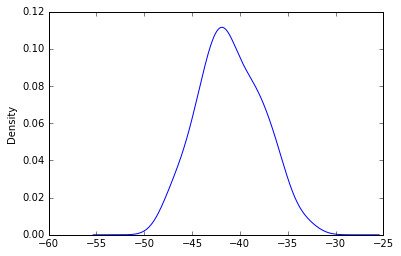

In [681]:
p.Series(ll).plot(kind='kde')

In [696]:
npart = 2000

y0 = 0
st = norm.rvs(size=npart)


def ess(phi):
    wt = norm(scale=np.sqrt(phi)).pdf(y0-st)
    wt = wt / np.sum(wt)
    return np.log((npart/2.0)/(1/(wt**2).sum()) )

from scipy.optimize import fsolve, brentq

z= brentq(ess, 0.1, 4)
print z, ess(z)
z = fsolve(ess, 24)
print z, ess(z)
#x = np.linspace(0.1,4,1000)
#plt.plot(x, [ess(_) for _ in x])

 -0.692356404953


0.148431695867 -2.22044604925e-16
[ 24.]

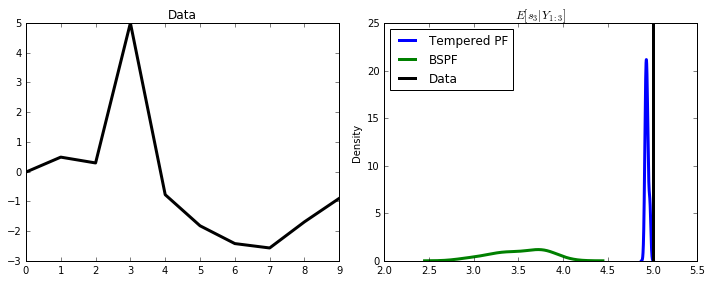

In [575]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=2)
fs.plot(kind='kde',ax=ax[1],linewidth=3)
p.Series(f2).plot(kind='kde',ax=ax[1],linewidth=3)
p.Series(outlier.squeeze()).plot(ax=ax[0],linewidth=3,color='black')
ax[1].axvline(outlier[3,:],color='black',linewidth=3)
ax[0].set_title('Data')
ax[1].set_title(r'$E[s_3|Y_{1:3}]$')
ax[1].legend(['Tempered PF', 'BSPF', 'Data'],loc='upper left')
fig.set_size_inches(10,4)
fig.tight_layout()
fig.savefig('filtered_state.pdf')

In [384]:
nsim = 20
ll = np.zeros((nsim,))
for i in range(nsim):
    q  = simpleAR1.log_lik_pf([0.8,1], y=outlier,npart=1000)
    ll[i] = q['log_lik'].sum()
    print q['filtered_states'][4]
ll = p.Series(ll)
print simpleAR1.log_lik([0.8,1],y=outlier)
print ll.describe()


/home/eherbst/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:170: DeprecationWarning: an index can only have a single Ellipsis (`...`); replace all but one with slices (`:`).



[ 2.74128048]
-33.7114048038
count     20.000000
mean    -156.031087
std       41.804687
min     -274.032295
25%     -170.085797
50%     -151.712705
75%     -131.128141
max     -100.297929
dtype: float64



[ 2.74234665]
[ 2.6428252]


[ 3.21520381]
[ 2.61039991]


[ 2.85390054]
[ 2.89348835]


[ 2.73303746]
[ 2.193701]


[ 2.65582293]
[ 2.88691884]


[ 2.8679946]
[ 2.67083922]


[ 2.93753093]
[ 2.77043225]


[ 3.05823309]
[ 3.32961107]

[ 2.38621609]
[ 2.61772772]
[ 2.54144458]

In [674]:
import sympy

t = sympy.symbols('t')#, cls=sympy.Idx)
eta = sympy.Indexed('eta',t)
phi = sympy.symbols('phi')
d = sympy.symbols('d')


sympy.diff(1/sympy.Sum( (phi**(-d/2)*sympy.exp(eta)**(-1.0/phi))**2, (t,1,3)), phi).simplify()

Sum(-phi**(-d - 2)*(-d*phi + 2.0*log(exp(eta[t])))*exp(eta[t])**(-2.0/phi), (t, 1, 3))/Sum(phi**(-d)*exp(eta[t])**(-2.0/phi), (t, 1, 3))**2